# Afriat

In [1]:
import warnings
import os
import sys
import gc
import warnings

In [2]:
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats

sys.path.append("/home/icb/kemal.inecik/work/codes/tardis")
import tardis
tardis.config = tardis.config_server

In [3]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No CUDA GPUs are available")

No CUDA GPUs are available


In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [5]:
adata_file_path = os.path.join(tardis.config.io_directories["processed"], "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [6]:
model_level_metrics = [
    dict(
        metric_identifier = "metric_mi|status_control",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 256,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|zone",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 128,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|time_cat",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 128,
            latent_subset=None,
            reduce=np.mean
        )
    ),
    dict(
        metric_identifier = "metric_mi|mouse",
        training_set = ["train"],
        every_n_epoch = 5,
        subsample = 1.0,
        progress_bar = True,
        metric_kwargs = dict(
            variation = "normalized",
            discretization_bins = 128,
            latent_subset=None,
            reduce=np.mean
        )
    )
]

In [7]:
warmup_epoch_range = [6, 48]
dtc_w1 = 100
dtc_w2 = 10

counteractive_minibatch_settings = dict(
    method = "categorical_random",
    method_kwargs = dict(
        within_labels = False,
        within_batch = False,
        within_categorical_covs = [False, False, False],
        seed = "forward",
    )
)

disentenglement_targets_configurations=[
    # dict(
    #     obs_key = "status_control",
    #     n_reserved_latent = 8,
    #     counteractive_minibatch_settings = counteractive_minibatch_settings,
    #     auxillary_losses = [
    #         dict(
    #             apply = True, 
    #             target_type="categorical",
    #             progress_bar = True,
    #             weight = dtc_w1,
    #             method = "mse_z", 
    #             latent_group = "reserved",
    #             counteractive_example = "negative",
    #             transformation = "inverse", 
    #             warmup_epoch_range=warmup_epoch_range,
    #             method_kwargs = {}
    #         ),
    #         dict(
    #             apply = True, 
    #             target_type="categorical",
    #             progress_bar = True,
    #             weight = dtc_w2, 
    #             method = "mse_z", 
    #             latent_group = "reserved",
    #             counteractive_example = "positive",
    #             transformation = "none",
    #             warmup_epoch_range=warmup_epoch_range,
    #             method_kwargs = {}
    #         ),
    #     ]
    # )
]

In [8]:
n_epochs_kl_warmup = 600

model_params = dict(
    n_hidden=512,
    n_layers=3, 
    n_latent=(24 + 8 * len(disentenglement_targets_configurations)),
    gene_likelihood = "nb",
    use_batch_norm = "none",
    use_layer_norm = "both",
    dropout_rate = 0.25,
    deeply_inject_disentengled_latents = True,
    include_auxillary_loss = True,
    beta_kl_weight = 0.5,
)

train_params = dict(
    max_epochs=600,
    train_size=0.8,
    batch_size=128,
    check_val_every_n_epoch=10,
    limit_train_batches=1.0, 
    limit_val_batches=1.0,
    learning_rate_monitor=True,
    # early stopping:
    early_stopping=False,
    early_stopping_patience=150,
    early_stopping_monitor="elbo_train",
    plan_kwargs = dict(
        n_epochs_kl_warmup=n_epochs_kl_warmup,
        lr=1e-4,
        weight_decay=1e-4,
        optimizer="AdamW",
        # lr-scheduler:
        reduce_lr_on_plateau=True,
        lr_patience=100,
        lr_scheduler_metric="elbo_train",
    )
)

dataset_params = dict(
    layer=None, 
    labels_key=None,
    batch_key=None,
    categorical_covariate_keys=['zone', 'status_control', 'time_cat'],
    disentenglement_targets_configurations=disentenglement_targets_configurations,
    model_level_metrics=model_level_metrics,
    model_level_metrics_helper_covariates=['zone', 'status_control', 'time_cat', 'mouse']
)

tardis.MyModel.setup_anndata(adata, **dataset_params)
dataset_params["adata_path"] = adata_file_path
dataset_params["adata"] = os.path.split(adata_file_path)[1]

tardis.MyModel.setup_wandb(
    wandb_configurations=tardis.config.wandb,
    hyperparams=dict(
        model_params=model_params,
        train_params=train_params,
        dataset_params=dataset_params,
    )
)

vae = tardis.MyModel(
    adata,
    **model_params
)
vae.train(**train_params)

dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "afriat_scvi"
)

vae.save(
    dir_path,
    overwrite=True,
)

/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


W&B logger initialized with the following parameters: 
Entity: inecik-academic
Project: tardis_conference
ID: f1ieyr4e
Name: legendary-bantha-106
Tags: tardis, conference, figures, final
Notes: Final runs for Tardis before conference.
URL: https://wandb.ai/inecik-academic/tardis_conference/runs/f1ieyr4e
Directory: /lustre/groups/ml01/workspace/kemal.inecik/wandb/run-20240504_155910-f1ieyr4e/files



/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...


GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..


`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_ ...
/home/icb/kemal.inecik/tools/apps/mamba/envs/tardis_env/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch 1/600:   0%|          | 1/600 [00:05<57:21,  5.75s/it]

Epoch 1/600:   0%|          | 1/600 [00:05<57:21,  5.75s/it, v_num=4e_1, total_loss_train=3.71e+3, kl_local_train=45.5]

Epoch 2/600:   0%|          | 1/600 [00:05<57:21,  5.75s/it, v_num=4e_1, total_loss_train=3.71e+3, kl_local_train=45.5]

Epoch 2/600:   0%|          | 2/600 [00:11<57:01,  5.72s/it, v_num=4e_1, total_loss_train=3.71e+3, kl_local_train=45.5]

Epoch 2/600:   0%|          | 2/600 [00:11<57:01,  5.72s/it, v_num=4e_1, total_loss_train=3.22e+3, kl_local_train=67.4]

Epoch 3/600:   0%|          | 2/600 [00:11<57:01,  5.72s/it, v_num=4e_1, total_loss_train=3.22e+3, kl_local_train=67.4]

Epoch 3/600:   0%|          | 3/600 [00:17<56:20,  5.66s/it, v_num=4e_1, total_loss_train=3.22e+3, kl_local_train=67.4]

Epoch 3/600:   0%|          | 3/600 [00:17<56:20,  5.66s/it, v_num=4e_1, total_loss_train=3.2e+3, kl_local_train=65.9] 

Epoch 4/600:   0%|          | 3/600 [00:17<56:20,  5.66s/it, v_num=4e_1, total_loss_train=3.2e+3, kl_local_train=65.9]

Epoch 4/600:   1%|          | 4/600 [00:22<55:33,  5.59s/it, v_num=4e_1, total_loss_train=3.2e+3, kl_local_train=65.9]

Epoch 4/600:   1%|          | 4/600 [00:22<55:33,  5.59s/it, v_num=4e_1, total_loss_train=3.19e+3, kl_local_train=51.2]

Epoch 5/600:   1%|          | 4/600 [00:22<55:33,  5.59s/it, v_num=4e_1, total_loss_train=3.19e+3, kl_local_train=51.2]

Epoch 5/600:   1%|          | 5/600 [00:28<55:48,  5.63s/it, v_num=4e_1, total_loss_train=3.19e+3, kl_local_train=51.2]

Epoch 5/600:   1%|          | 5/600 [00:28<55:48,  5.63s/it, v_num=4e_1, total_loss_train=3.18e+3, kl_local_train=44.9]

Epoch 6/600:   1%|          | 5/600 [00:29<55:48,  5.63s/it, v_num=4e_1, total_loss_train=3.18e+3, kl_local_train=44.9]

Epoch 6/600:   1%|          | 6/600 [00:33<55:50,  5.64s/it, v_num=4e_1, total_loss_train=3.18e+3, kl_local_train=44.9]

Epoch 6/600:   1%|          | 6/600 [00:33<55:50,  5.64s/it, v_num=4e_1, total_loss_train=3.16e+3, kl_local_train=47.5, metric_mi|status_control_train=0.0223, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.0196, metric_mi|mouse_train=0.0449]

Epoch 7/600:   1%|          | 6/600 [00:33<55:50,  5.64s/it, v_num=4e_1, total_loss_train=3.16e+3, kl_local_train=47.5, metric_mi|status_control_train=0.0223, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.0196, metric_mi|mouse_train=0.0449]

Epoch 7/600:   1%|          | 7/600 [00:38<53:20,  5.40s/it, v_num=4e_1, total_loss_train=3.16e+3, kl_local_train=47.5, metric_mi|status_control_train=0.0223, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.0196, metric_mi|mouse_train=0.0449]

Epoch 7/600:   1%|          | 7/600 [00:38<53:20,  5.40s/it, v_num=4e_1, total_loss_train=3.15e+3, kl_local_train=55.3, metric_mi|status_control_train=0.0223, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.0196, metric_mi|mouse_train=0.0449]

Epoch 8/600:   1%|          | 7/600 [00:38<53:20,  5.40s/it, v_num=4e_1, total_loss_train=3.15e+3, kl_local_train=55.3, metric_mi|status_control_train=0.0223, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.0196, metric_mi|mouse_train=0.0449]

Epoch 8/600:   1%|▏         | 8/600 [00:43<51:25,  5.21s/it, v_num=4e_1, total_loss_train=3.15e+3, kl_local_train=55.3, metric_mi|status_control_train=0.0223, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.0196, metric_mi|mouse_train=0.0449]

Epoch 8/600:   1%|▏         | 8/600 [00:43<51:25,  5.21s/it, v_num=4e_1, total_loss_train=3.14e+3, kl_local_train=61.6, metric_mi|status_control_train=0.0223, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.0196, metric_mi|mouse_train=0.0449]

Epoch 9/600:   1%|▏         | 8/600 [00:43<51:25,  5.21s/it, v_num=4e_1, total_loss_train=3.14e+3, kl_local_train=61.6, metric_mi|status_control_train=0.0223, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.0196, metric_mi|mouse_train=0.0449]

Epoch 9/600:   2%|▏         | 9/600 [00:48<50:30,  5.13s/it, v_num=4e_1, total_loss_train=3.14e+3, kl_local_train=61.6, metric_mi|status_control_train=0.0223, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.0196, metric_mi|mouse_train=0.0449]

Epoch 9/600:   2%|▏         | 9/600 [00:48<50:30,  5.13s/it, v_num=4e_1, total_loss_train=3.13e+3, kl_local_train=65.1, metric_mi|status_control_train=0.0223, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.0196, metric_mi|mouse_train=0.0449]

Epoch 10/600:   2%|▏         | 9/600 [00:48<50:30,  5.13s/it, v_num=4e_1, total_loss_train=3.13e+3, kl_local_train=65.1, metric_mi|status_control_train=0.0223, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.0196, metric_mi|mouse_train=0.0449]

Epoch 10/600:   2%|▏         | 10/600 [00:53<50:13,  5.11s/it, v_num=4e_1, total_loss_train=3.13e+3, kl_local_train=65.1, metric_mi|status_control_train=0.0223, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.0196, metric_mi|mouse_train=0.0449]

Epoch 10/600:   2%|▏         | 10/600 [00:53<50:13,  5.11s/it, v_num=4e_1, total_loss_train=3.12e+3, kl_local_train=67.3, metric_mi|status_control_train=0.0223, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.0196, metric_mi|mouse_train=0.0449]

Epoch 11/600:   2%|▏         | 10/600 [00:54<50:13,  5.11s/it, v_num=4e_1, total_loss_train=3.12e+3, kl_local_train=67.3, metric_mi|status_control_train=0.0223, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.0196, metric_mi|mouse_train=0.0449]

Epoch 11/600:   2%|▏         | 11/600 [00:59<51:25,  5.24s/it, v_num=4e_1, total_loss_train=3.12e+3, kl_local_train=67.3, metric_mi|status_control_train=0.0223, metric_mi|zone_train=0.182, metric_mi|time_cat_train=0.0196, metric_mi|mouse_train=0.0449]

Epoch 11/600:   2%|▏         | 11/600 [00:59<51:25,  5.24s/it, v_num=4e_1, total_loss_train=3.11e+3, kl_local_train=68.3, metric_mi|status_control_train=0.0467, metric_mi|zone_train=0.106, metric_mi|time_cat_train=0.0651, metric_mi|mouse_train=0.103] 

Epoch 12/600:   2%|▏         | 11/600 [00:59<51:25,  5.24s/it, v_num=4e_1, total_loss_train=3.11e+3, kl_local_train=68.3, metric_mi|status_control_train=0.0467, metric_mi|zone_train=0.106, metric_mi|time_cat_train=0.0651, metric_mi|mouse_train=0.103]

Epoch 12/600:   2%|▏         | 12/600 [01:03<49:56,  5.10s/it, v_num=4e_1, total_loss_train=3.11e+3, kl_local_train=68.3, metric_mi|status_control_train=0.0467, metric_mi|zone_train=0.106, metric_mi|time_cat_train=0.0651, metric_mi|mouse_train=0.103]

Epoch 12/600:   2%|▏         | 12/600 [01:03<49:56,  5.10s/it, v_num=4e_1, total_loss_train=3.11e+3, kl_local_train=68.5, metric_mi|status_control_train=0.0467, metric_mi|zone_train=0.106, metric_mi|time_cat_train=0.0651, metric_mi|mouse_train=0.103]

Epoch 13/600:   2%|▏         | 12/600 [01:03<49:56,  5.10s/it, v_num=4e_1, total_loss_train=3.11e+3, kl_local_train=68.5, metric_mi|status_control_train=0.0467, metric_mi|zone_train=0.106, metric_mi|time_cat_train=0.0651, metric_mi|mouse_train=0.103]

Epoch 13/600:   2%|▏         | 13/600 [01:08<49:33,  5.07s/it, v_num=4e_1, total_loss_train=3.11e+3, kl_local_train=68.5, metric_mi|status_control_train=0.0467, metric_mi|zone_train=0.106, metric_mi|time_cat_train=0.0651, metric_mi|mouse_train=0.103]

Epoch 13/600:   2%|▏         | 13/600 [01:08<49:33,  5.07s/it, v_num=4e_1, total_loss_train=3.11e+3, kl_local_train=67.7, metric_mi|status_control_train=0.0467, metric_mi|zone_train=0.106, metric_mi|time_cat_train=0.0651, metric_mi|mouse_train=0.103]

Epoch 14/600:   2%|▏         | 13/600 [01:08<49:33,  5.07s/it, v_num=4e_1, total_loss_train=3.11e+3, kl_local_train=67.7, metric_mi|status_control_train=0.0467, metric_mi|zone_train=0.106, metric_mi|time_cat_train=0.0651, metric_mi|mouse_train=0.103]

Epoch 14/600:   2%|▏         | 14/600 [01:13<48:33,  4.97s/it, v_num=4e_1, total_loss_train=3.11e+3, kl_local_train=67.7, metric_mi|status_control_train=0.0467, metric_mi|zone_train=0.106, metric_mi|time_cat_train=0.0651, metric_mi|mouse_train=0.103]

Epoch 14/600:   2%|▏         | 14/600 [01:13<48:33,  4.97s/it, v_num=4e_1, total_loss_train=3.1e+3, kl_local_train=66.9, metric_mi|status_control_train=0.0467, metric_mi|zone_train=0.106, metric_mi|time_cat_train=0.0651, metric_mi|mouse_train=0.103] 

Epoch 15/600:   2%|▏         | 14/600 [01:13<48:33,  4.97s/it, v_num=4e_1, total_loss_train=3.1e+3, kl_local_train=66.9, metric_mi|status_control_train=0.0467, metric_mi|zone_train=0.106, metric_mi|time_cat_train=0.0651, metric_mi|mouse_train=0.103]

Epoch 15/600:   2%|▎         | 15/600 [01:18<48:32,  4.98s/it, v_num=4e_1, total_loss_train=3.1e+3, kl_local_train=66.9, metric_mi|status_control_train=0.0467, metric_mi|zone_train=0.106, metric_mi|time_cat_train=0.0651, metric_mi|mouse_train=0.103]

Epoch 15/600:   2%|▎         | 15/600 [01:18<48:32,  4.98s/it, v_num=4e_1, total_loss_train=3.1e+3, kl_local_train=66.2, metric_mi|status_control_train=0.0467, metric_mi|zone_train=0.106, metric_mi|time_cat_train=0.0651, metric_mi|mouse_train=0.103]

Epoch 16/600:   2%|▎         | 15/600 [01:19<48:32,  4.98s/it, v_num=4e_1, total_loss_train=3.1e+3, kl_local_train=66.2, metric_mi|status_control_train=0.0467, metric_mi|zone_train=0.106, metric_mi|time_cat_train=0.0651, metric_mi|mouse_train=0.103]

Epoch 16/600:   3%|▎         | 16/600 [01:24<50:36,  5.20s/it, v_num=4e_1, total_loss_train=3.1e+3, kl_local_train=66.2, metric_mi|status_control_train=0.0467, metric_mi|zone_train=0.106, metric_mi|time_cat_train=0.0651, metric_mi|mouse_train=0.103]

Epoch 16/600:   3%|▎         | 16/600 [01:24<50:36,  5.20s/it, v_num=4e_1, total_loss_train=3.1e+3, kl_local_train=65.5, metric_mi|status_control_train=0.0426, metric_mi|zone_train=0.0922, metric_mi|time_cat_train=0.0624, metric_mi|mouse_train=0.108]

Epoch 17/600:   3%|▎         | 16/600 [01:24<50:36,  5.20s/it, v_num=4e_1, total_loss_train=3.1e+3, kl_local_train=65.5, metric_mi|status_control_train=0.0426, metric_mi|zone_train=0.0922, metric_mi|time_cat_train=0.0624, metric_mi|mouse_train=0.108]

Epoch 17/600:   3%|▎         | 17/600 [01:29<49:00,  5.04s/it, v_num=4e_1, total_loss_train=3.1e+3, kl_local_train=65.5, metric_mi|status_control_train=0.0426, metric_mi|zone_train=0.0922, metric_mi|time_cat_train=0.0624, metric_mi|mouse_train=0.108]

Epoch 17/600:   3%|▎         | 17/600 [01:29<49:00,  5.04s/it, v_num=4e_1, total_loss_train=3.09e+3, kl_local_train=64.3, metric_mi|status_control_train=0.0426, metric_mi|zone_train=0.0922, metric_mi|time_cat_train=0.0624, metric_mi|mouse_train=0.108]

Epoch 18/600:   3%|▎         | 17/600 [01:29<49:00,  5.04s/it, v_num=4e_1, total_loss_train=3.09e+3, kl_local_train=64.3, metric_mi|status_control_train=0.0426, metric_mi|zone_train=0.0922, metric_mi|time_cat_train=0.0624, metric_mi|mouse_train=0.108]

Epoch 18/600:   3%|▎         | 18/600 [01:33<48:03,  4.95s/it, v_num=4e_1, total_loss_train=3.09e+3, kl_local_train=64.3, metric_mi|status_control_train=0.0426, metric_mi|zone_train=0.0922, metric_mi|time_cat_train=0.0624, metric_mi|mouse_train=0.108]

Epoch 18/600:   3%|▎         | 18/600 [01:33<48:03,  4.95s/it, v_num=4e_1, total_loss_train=3.09e+3, kl_local_train=64, metric_mi|status_control_train=0.0426, metric_mi|zone_train=0.0922, metric_mi|time_cat_train=0.0624, metric_mi|mouse_train=0.108]  

Epoch 19/600:   3%|▎         | 18/600 [01:33<48:03,  4.95s/it, v_num=4e_1, total_loss_train=3.09e+3, kl_local_train=64, metric_mi|status_control_train=0.0426, metric_mi|zone_train=0.0922, metric_mi|time_cat_train=0.0624, metric_mi|mouse_train=0.108]

Epoch 19/600:   3%|▎         | 19/600 [01:38<47:23,  4.89s/it, v_num=4e_1, total_loss_train=3.09e+3, kl_local_train=64, metric_mi|status_control_train=0.0426, metric_mi|zone_train=0.0922, metric_mi|time_cat_train=0.0624, metric_mi|mouse_train=0.108]

Epoch 19/600:   3%|▎         | 19/600 [01:38<47:23,  4.89s/it, v_num=4e_1, total_loss_train=3.09e+3, kl_local_train=63.4, metric_mi|status_control_train=0.0426, metric_mi|zone_train=0.0922, metric_mi|time_cat_train=0.0624, metric_mi|mouse_train=0.108]

Epoch 20/600:   3%|▎         | 19/600 [01:38<47:23,  4.89s/it, v_num=4e_1, total_loss_train=3.09e+3, kl_local_train=63.4, metric_mi|status_control_train=0.0426, metric_mi|zone_train=0.0922, metric_mi|time_cat_train=0.0624, metric_mi|mouse_train=0.108]

Epoch 20/600:   3%|▎         | 20/600 [01:43<47:47,  4.94s/it, v_num=4e_1, total_loss_train=3.09e+3, kl_local_train=63.4, metric_mi|status_control_train=0.0426, metric_mi|zone_train=0.0922, metric_mi|time_cat_train=0.0624, metric_mi|mouse_train=0.108]

Epoch 20/600:   3%|▎         | 20/600 [01:43<47:47,  4.94s/it, v_num=4e_1, total_loss_train=3.08e+3, kl_local_train=62.8, metric_mi|status_control_train=0.0426, metric_mi|zone_train=0.0922, metric_mi|time_cat_train=0.0624, metric_mi|mouse_train=0.108]

Epoch 21/600:   3%|▎         | 20/600 [01:44<47:47,  4.94s/it, v_num=4e_1, total_loss_train=3.08e+3, kl_local_train=62.8, metric_mi|status_control_train=0.0426, metric_mi|zone_train=0.0922, metric_mi|time_cat_train=0.0624, metric_mi|mouse_train=0.108]

Epoch 21/600:   4%|▎         | 21/600 [01:49<49:08,  5.09s/it, v_num=4e_1, total_loss_train=3.08e+3, kl_local_train=62.8, metric_mi|status_control_train=0.0426, metric_mi|zone_train=0.0922, metric_mi|time_cat_train=0.0624, metric_mi|mouse_train=0.108]

Epoch 21/600:   4%|▎         | 21/600 [01:49<49:08,  5.09s/it, v_num=4e_1, total_loss_train=3.08e+3, kl_local_train=62.5, metric_mi|status_control_train=0.0399, metric_mi|zone_train=0.0793, metric_mi|time_cat_train=0.0586, metric_mi|mouse_train=0.11] 

Epoch 22/600:   4%|▎         | 21/600 [01:49<49:08,  5.09s/it, v_num=4e_1, total_loss_train=3.08e+3, kl_local_train=62.5, metric_mi|status_control_train=0.0399, metric_mi|zone_train=0.0793, metric_mi|time_cat_train=0.0586, metric_mi|mouse_train=0.11]

Epoch 22/600:   4%|▎         | 22/600 [01:53<47:49,  4.97s/it, v_num=4e_1, total_loss_train=3.08e+3, kl_local_train=62.5, metric_mi|status_control_train=0.0399, metric_mi|zone_train=0.0793, metric_mi|time_cat_train=0.0586, metric_mi|mouse_train=0.11]

Epoch 22/600:   4%|▎         | 22/600 [01:53<47:49,  4.97s/it, v_num=4e_1, total_loss_train=3.08e+3, kl_local_train=61.8, metric_mi|status_control_train=0.0399, metric_mi|zone_train=0.0793, metric_mi|time_cat_train=0.0586, metric_mi|mouse_train=0.11]

Epoch 23/600:   4%|▎         | 22/600 [01:53<47:49,  4.97s/it, v_num=4e_1, total_loss_train=3.08e+3, kl_local_train=61.8, metric_mi|status_control_train=0.0399, metric_mi|zone_train=0.0793, metric_mi|time_cat_train=0.0586, metric_mi|mouse_train=0.11]

Epoch 23/600:   4%|▍         | 23/600 [01:58<47:30,  4.94s/it, v_num=4e_1, total_loss_train=3.08e+3, kl_local_train=61.8, metric_mi|status_control_train=0.0399, metric_mi|zone_train=0.0793, metric_mi|time_cat_train=0.0586, metric_mi|mouse_train=0.11]

Epoch 23/600:   4%|▍         | 23/600 [01:58<47:30,  4.94s/it, v_num=4e_1, total_loss_train=3.08e+3, kl_local_train=61, metric_mi|status_control_train=0.0399, metric_mi|zone_train=0.0793, metric_mi|time_cat_train=0.0586, metric_mi|mouse_train=0.11]  

Epoch 24/600:   4%|▍         | 23/600 [01:58<47:30,  4.94s/it, v_num=4e_1, total_loss_train=3.08e+3, kl_local_train=61, metric_mi|status_control_train=0.0399, metric_mi|zone_train=0.0793, metric_mi|time_cat_train=0.0586, metric_mi|mouse_train=0.11]

Epoch 24/600:   4%|▍         | 24/600 [02:03<46:38,  4.86s/it, v_num=4e_1, total_loss_train=3.08e+3, kl_local_train=61, metric_mi|status_control_train=0.0399, metric_mi|zone_train=0.0793, metric_mi|time_cat_train=0.0586, metric_mi|mouse_train=0.11]

Epoch 24/600:   4%|▍         | 24/600 [02:03<46:38,  4.86s/it, v_num=4e_1, total_loss_train=3.07e+3, kl_local_train=60.4, metric_mi|status_control_train=0.0399, metric_mi|zone_train=0.0793, metric_mi|time_cat_train=0.0586, metric_mi|mouse_train=0.11]

Epoch 25/600:   4%|▍         | 24/600 [02:03<46:38,  4.86s/it, v_num=4e_1, total_loss_train=3.07e+3, kl_local_train=60.4, metric_mi|status_control_train=0.0399, metric_mi|zone_train=0.0793, metric_mi|time_cat_train=0.0586, metric_mi|mouse_train=0.11]

Epoch 25/600:   4%|▍         | 25/600 [02:07<46:00,  4.80s/it, v_num=4e_1, total_loss_train=3.07e+3, kl_local_train=60.4, metric_mi|status_control_train=0.0399, metric_mi|zone_train=0.0793, metric_mi|time_cat_train=0.0586, metric_mi|mouse_train=0.11]

Epoch 25/600:   4%|▍         | 25/600 [02:07<46:00,  4.80s/it, v_num=4e_1, total_loss_train=3.07e+3, kl_local_train=59.7, metric_mi|status_control_train=0.0399, metric_mi|zone_train=0.0793, metric_mi|time_cat_train=0.0586, metric_mi|mouse_train=0.11]

Epoch 26/600:   4%|▍         | 25/600 [02:08<46:00,  4.80s/it, v_num=4e_1, total_loss_train=3.07e+3, kl_local_train=59.7, metric_mi|status_control_train=0.0399, metric_mi|zone_train=0.0793, metric_mi|time_cat_train=0.0586, metric_mi|mouse_train=0.11]

Epoch 26/600:   4%|▍         | 26/600 [02:13<48:03,  5.02s/it, v_num=4e_1, total_loss_train=3.07e+3, kl_local_train=59.7, metric_mi|status_control_train=0.0399, metric_mi|zone_train=0.0793, metric_mi|time_cat_train=0.0586, metric_mi|mouse_train=0.11]

Epoch 26/600:   4%|▍         | 26/600 [02:13<48:03,  5.02s/it, v_num=4e_1, total_loss_train=3.07e+3, kl_local_train=59, metric_mi|status_control_train=0.0383, metric_mi|zone_train=0.0723, metric_mi|time_cat_train=0.0544, metric_mi|mouse_train=0.111] 

Epoch 27/600:   4%|▍         | 26/600 [02:13<48:03,  5.02s/it, v_num=4e_1, total_loss_train=3.07e+3, kl_local_train=59, metric_mi|status_control_train=0.0383, metric_mi|zone_train=0.0723, metric_mi|time_cat_train=0.0544, metric_mi|mouse_train=0.111]

Epoch 27/600:   4%|▍         | 27/600 [02:18<47:22,  4.96s/it, v_num=4e_1, total_loss_train=3.07e+3, kl_local_train=59, metric_mi|status_control_train=0.0383, metric_mi|zone_train=0.0723, metric_mi|time_cat_train=0.0544, metric_mi|mouse_train=0.111]

Epoch 27/600:   4%|▍         | 27/600 [02:18<47:22,  4.96s/it, v_num=4e_1, total_loss_train=3.07e+3, kl_local_train=58.2, metric_mi|status_control_train=0.0383, metric_mi|zone_train=0.0723, metric_mi|time_cat_train=0.0544, metric_mi|mouse_train=0.111]

Epoch 28/600:   4%|▍         | 27/600 [02:18<47:22,  4.96s/it, v_num=4e_1, total_loss_train=3.07e+3, kl_local_train=58.2, metric_mi|status_control_train=0.0383, metric_mi|zone_train=0.0723, metric_mi|time_cat_train=0.0544, metric_mi|mouse_train=0.111]

Epoch 28/600:   5%|▍         | 28/600 [02:22<46:28,  4.88s/it, v_num=4e_1, total_loss_train=3.07e+3, kl_local_train=58.2, metric_mi|status_control_train=0.0383, metric_mi|zone_train=0.0723, metric_mi|time_cat_train=0.0544, metric_mi|mouse_train=0.111]

Epoch 28/600:   5%|▍         | 28/600 [02:22<46:28,  4.88s/it, v_num=4e_1, total_loss_train=3.07e+3, kl_local_train=57.6, metric_mi|status_control_train=0.0383, metric_mi|zone_train=0.0723, metric_mi|time_cat_train=0.0544, metric_mi|mouse_train=0.111]

Epoch 29/600:   5%|▍         | 28/600 [02:22<46:28,  4.88s/it, v_num=4e_1, total_loss_train=3.07e+3, kl_local_train=57.6, metric_mi|status_control_train=0.0383, metric_mi|zone_train=0.0723, metric_mi|time_cat_train=0.0544, metric_mi|mouse_train=0.111]

Epoch 29/600:   5%|▍         | 29/600 [02:27<45:49,  4.81s/it, v_num=4e_1, total_loss_train=3.07e+3, kl_local_train=57.6, metric_mi|status_control_train=0.0383, metric_mi|zone_train=0.0723, metric_mi|time_cat_train=0.0544, metric_mi|mouse_train=0.111]

Epoch 29/600:   5%|▍         | 29/600 [02:27<45:49,  4.81s/it, v_num=4e_1, total_loss_train=3.06e+3, kl_local_train=56.8, metric_mi|status_control_train=0.0383, metric_mi|zone_train=0.0723, metric_mi|time_cat_train=0.0544, metric_mi|mouse_train=0.111]

Epoch 30/600:   5%|▍         | 29/600 [02:27<45:49,  4.81s/it, v_num=4e_1, total_loss_train=3.06e+3, kl_local_train=56.8, metric_mi|status_control_train=0.0383, metric_mi|zone_train=0.0723, metric_mi|time_cat_train=0.0544, metric_mi|mouse_train=0.111]

Epoch 30/600:   5%|▌         | 30/600 [02:32<46:09,  4.86s/it, v_num=4e_1, total_loss_train=3.06e+3, kl_local_train=56.8, metric_mi|status_control_train=0.0383, metric_mi|zone_train=0.0723, metric_mi|time_cat_train=0.0544, metric_mi|mouse_train=0.111]

Epoch 30/600:   5%|▌         | 30/600 [02:32<46:09,  4.86s/it, v_num=4e_1, total_loss_train=3.06e+3, kl_local_train=56.5, metric_mi|status_control_train=0.0383, metric_mi|zone_train=0.0723, metric_mi|time_cat_train=0.0544, metric_mi|mouse_train=0.111]

Epoch 31/600:   5%|▌         | 30/600 [02:33<46:09,  4.86s/it, v_num=4e_1, total_loss_train=3.06e+3, kl_local_train=56.5, metric_mi|status_control_train=0.0383, metric_mi|zone_train=0.0723, metric_mi|time_cat_train=0.0544, metric_mi|mouse_train=0.111]

Epoch 31/600:   5%|▌         | 31/600 [02:38<47:46,  5.04s/it, v_num=4e_1, total_loss_train=3.06e+3, kl_local_train=56.5, metric_mi|status_control_train=0.0383, metric_mi|zone_train=0.0723, metric_mi|time_cat_train=0.0544, metric_mi|mouse_train=0.111]

Epoch 31/600:   5%|▌         | 31/600 [02:38<47:46,  5.04s/it, v_num=4e_1, total_loss_train=3.06e+3, kl_local_train=55.7, metric_mi|status_control_train=0.0367, metric_mi|zone_train=0.0654, metric_mi|time_cat_train=0.0518, metric_mi|mouse_train=0.111]

Epoch 32/600:   5%|▌         | 31/600 [02:38<47:46,  5.04s/it, v_num=4e_1, total_loss_train=3.06e+3, kl_local_train=55.7, metric_mi|status_control_train=0.0367, metric_mi|zone_train=0.0654, metric_mi|time_cat_train=0.0518, metric_mi|mouse_train=0.111]

Epoch 32/600:   5%|▌         | 32/600 [02:42<46:38,  4.93s/it, v_num=4e_1, total_loss_train=3.06e+3, kl_local_train=55.7, metric_mi|status_control_train=0.0367, metric_mi|zone_train=0.0654, metric_mi|time_cat_train=0.0518, metric_mi|mouse_train=0.111]

Epoch 32/600:   5%|▌         | 32/600 [02:42<46:38,  4.93s/it, v_num=4e_1, total_loss_train=3.06e+3, kl_local_train=55.5, metric_mi|status_control_train=0.0367, metric_mi|zone_train=0.0654, metric_mi|time_cat_train=0.0518, metric_mi|mouse_train=0.111]

Epoch 33/600:   5%|▌         | 32/600 [02:42<46:38,  4.93s/it, v_num=4e_1, total_loss_train=3.06e+3, kl_local_train=55.5, metric_mi|status_control_train=0.0367, metric_mi|zone_train=0.0654, metric_mi|time_cat_train=0.0518, metric_mi|mouse_train=0.111]

Epoch 33/600:   6%|▌         | 33/600 [02:47<45:44,  4.84s/it, v_num=4e_1, total_loss_train=3.06e+3, kl_local_train=55.5, metric_mi|status_control_train=0.0367, metric_mi|zone_train=0.0654, metric_mi|time_cat_train=0.0518, metric_mi|mouse_train=0.111]

Epoch 33/600:   6%|▌         | 33/600 [02:47<45:44,  4.84s/it, v_num=4e_1, total_loss_train=3.06e+3, kl_local_train=55, metric_mi|status_control_train=0.0367, metric_mi|zone_train=0.0654, metric_mi|time_cat_train=0.0518, metric_mi|mouse_train=0.111]  

Epoch 34/600:   6%|▌         | 33/600 [02:47<45:44,  4.84s/it, v_num=4e_1, total_loss_train=3.06e+3, kl_local_train=55, metric_mi|status_control_train=0.0367, metric_mi|zone_train=0.0654, metric_mi|time_cat_train=0.0518, metric_mi|mouse_train=0.111]

Epoch 34/600:   6%|▌         | 34/600 [02:52<45:50,  4.86s/it, v_num=4e_1, total_loss_train=3.06e+3, kl_local_train=55, metric_mi|status_control_train=0.0367, metric_mi|zone_train=0.0654, metric_mi|time_cat_train=0.0518, metric_mi|mouse_train=0.111]

Epoch 34/600:   6%|▌         | 34/600 [02:52<45:50,  4.86s/it, v_num=4e_1, total_loss_train=3.05e+3, kl_local_train=54.6, metric_mi|status_control_train=0.0367, metric_mi|zone_train=0.0654, metric_mi|time_cat_train=0.0518, metric_mi|mouse_train=0.111]

Epoch 35/600:   6%|▌         | 34/600 [02:52<45:50,  4.86s/it, v_num=4e_1, total_loss_train=3.05e+3, kl_local_train=54.6, metric_mi|status_control_train=0.0367, metric_mi|zone_train=0.0654, metric_mi|time_cat_train=0.0518, metric_mi|mouse_train=0.111]

Epoch 35/600:   6%|▌         | 35/600 [02:56<45:22,  4.82s/it, v_num=4e_1, total_loss_train=3.05e+3, kl_local_train=54.6, metric_mi|status_control_train=0.0367, metric_mi|zone_train=0.0654, metric_mi|time_cat_train=0.0518, metric_mi|mouse_train=0.111]

Epoch 35/600:   6%|▌         | 35/600 [02:56<45:22,  4.82s/it, v_num=4e_1, total_loss_train=3.05e+3, kl_local_train=54.3, metric_mi|status_control_train=0.0367, metric_mi|zone_train=0.0654, metric_mi|time_cat_train=0.0518, metric_mi|mouse_train=0.111]

Epoch 36/600:   6%|▌         | 35/600 [02:57<45:22,  4.82s/it, v_num=4e_1, total_loss_train=3.05e+3, kl_local_train=54.3, metric_mi|status_control_train=0.0367, metric_mi|zone_train=0.0654, metric_mi|time_cat_train=0.0518, metric_mi|mouse_train=0.111]

Epoch 36/600:   6%|▌         | 36/600 [03:02<47:06,  5.01s/it, v_num=4e_1, total_loss_train=3.05e+3, kl_local_train=54.3, metric_mi|status_control_train=0.0367, metric_mi|zone_train=0.0654, metric_mi|time_cat_train=0.0518, metric_mi|mouse_train=0.111]

Epoch 36/600:   6%|▌         | 36/600 [03:02<47:06,  5.01s/it, v_num=4e_1, total_loss_train=3.05e+3, kl_local_train=53.8, metric_mi|status_control_train=0.0356, metric_mi|zone_train=0.0613, metric_mi|time_cat_train=0.0499, metric_mi|mouse_train=0.11] 

Epoch 37/600:   6%|▌         | 36/600 [03:02<47:06,  5.01s/it, v_num=4e_1, total_loss_train=3.05e+3, kl_local_train=53.8, metric_mi|status_control_train=0.0356, metric_mi|zone_train=0.0613, metric_mi|time_cat_train=0.0499, metric_mi|mouse_train=0.11]

Epoch 37/600:   6%|▌         | 37/600 [03:07<46:06,  4.91s/it, v_num=4e_1, total_loss_train=3.05e+3, kl_local_train=53.8, metric_mi|status_control_train=0.0356, metric_mi|zone_train=0.0613, metric_mi|time_cat_train=0.0499, metric_mi|mouse_train=0.11]

Epoch 37/600:   6%|▌         | 37/600 [03:07<46:06,  4.91s/it, v_num=4e_1, total_loss_train=3.05e+3, kl_local_train=53.4, metric_mi|status_control_train=0.0356, metric_mi|zone_train=0.0613, metric_mi|time_cat_train=0.0499, metric_mi|mouse_train=0.11]

Epoch 38/600:   6%|▌         | 37/600 [03:07<46:06,  4.91s/it, v_num=4e_1, total_loss_train=3.05e+3, kl_local_train=53.4, metric_mi|status_control_train=0.0356, metric_mi|zone_train=0.0613, metric_mi|time_cat_train=0.0499, metric_mi|mouse_train=0.11]

Epoch 38/600:   6%|▋         | 38/600 [03:12<45:55,  4.90s/it, v_num=4e_1, total_loss_train=3.05e+3, kl_local_train=53.4, metric_mi|status_control_train=0.0356, metric_mi|zone_train=0.0613, metric_mi|time_cat_train=0.0499, metric_mi|mouse_train=0.11]

Epoch 38/600:   6%|▋         | 38/600 [03:12<45:55,  4.90s/it, v_num=4e_1, total_loss_train=3.05e+3, kl_local_train=53.1, metric_mi|status_control_train=0.0356, metric_mi|zone_train=0.0613, metric_mi|time_cat_train=0.0499, metric_mi|mouse_train=0.11]

Epoch 39/600:   6%|▋         | 38/600 [03:12<45:55,  4.90s/it, v_num=4e_1, total_loss_train=3.05e+3, kl_local_train=53.1, metric_mi|status_control_train=0.0356, metric_mi|zone_train=0.0613, metric_mi|time_cat_train=0.0499, metric_mi|mouse_train=0.11]

Epoch 39/600:   6%|▋         | 39/600 [03:16<45:16,  4.84s/it, v_num=4e_1, total_loss_train=3.05e+3, kl_local_train=53.1, metric_mi|status_control_train=0.0356, metric_mi|zone_train=0.0613, metric_mi|time_cat_train=0.0499, metric_mi|mouse_train=0.11]

Epoch 39/600:   6%|▋         | 39/600 [03:16<45:16,  4.84s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=52.8, metric_mi|status_control_train=0.0356, metric_mi|zone_train=0.0613, metric_mi|time_cat_train=0.0499, metric_mi|mouse_train=0.11]

Epoch 40/600:   6%|▋         | 39/600 [03:16<45:16,  4.84s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=52.8, metric_mi|status_control_train=0.0356, metric_mi|zone_train=0.0613, metric_mi|time_cat_train=0.0499, metric_mi|mouse_train=0.11]

Epoch 40/600:   7%|▋         | 40/600 [03:21<44:53,  4.81s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=52.8, metric_mi|status_control_train=0.0356, metric_mi|zone_train=0.0613, metric_mi|time_cat_train=0.0499, metric_mi|mouse_train=0.11]

Epoch 40/600:   7%|▋         | 40/600 [03:21<44:53,  4.81s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=52.5, metric_mi|status_control_train=0.0356, metric_mi|zone_train=0.0613, metric_mi|time_cat_train=0.0499, metric_mi|mouse_train=0.11]

Epoch 41/600:   7%|▋         | 40/600 [03:22<44:53,  4.81s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=52.5, metric_mi|status_control_train=0.0356, metric_mi|zone_train=0.0613, metric_mi|time_cat_train=0.0499, metric_mi|mouse_train=0.11]

Epoch 41/600:   7%|▋         | 41/600 [03:27<47:10,  5.06s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=52.5, metric_mi|status_control_train=0.0356, metric_mi|zone_train=0.0613, metric_mi|time_cat_train=0.0499, metric_mi|mouse_train=0.11]

Epoch 41/600:   7%|▋         | 41/600 [03:27<47:10,  5.06s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=52.2, metric_mi|status_control_train=0.0349, metric_mi|zone_train=0.0576, metric_mi|time_cat_train=0.0478, metric_mi|mouse_train=0.109]

Epoch 42/600:   7%|▋         | 41/600 [03:27<47:10,  5.06s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=52.2, metric_mi|status_control_train=0.0349, metric_mi|zone_train=0.0576, metric_mi|time_cat_train=0.0478, metric_mi|mouse_train=0.109]

Epoch 42/600:   7%|▋         | 42/600 [03:31<46:04,  4.95s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=52.2, metric_mi|status_control_train=0.0349, metric_mi|zone_train=0.0576, metric_mi|time_cat_train=0.0478, metric_mi|mouse_train=0.109]

Epoch 42/600:   7%|▋         | 42/600 [03:31<46:04,  4.95s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=52.2, metric_mi|status_control_train=0.0349, metric_mi|zone_train=0.0576, metric_mi|time_cat_train=0.0478, metric_mi|mouse_train=0.109]

Epoch 43/600:   7%|▋         | 42/600 [03:31<46:04,  4.95s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=52.2, metric_mi|status_control_train=0.0349, metric_mi|zone_train=0.0576, metric_mi|time_cat_train=0.0478, metric_mi|mouse_train=0.109]

Epoch 43/600:   7%|▋         | 43/600 [03:36<45:16,  4.88s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=52.2, metric_mi|status_control_train=0.0349, metric_mi|zone_train=0.0576, metric_mi|time_cat_train=0.0478, metric_mi|mouse_train=0.109]

Epoch 43/600:   7%|▋         | 43/600 [03:36<45:16,  4.88s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=51.8, metric_mi|status_control_train=0.0349, metric_mi|zone_train=0.0576, metric_mi|time_cat_train=0.0478, metric_mi|mouse_train=0.109]

Epoch 44/600:   7%|▋         | 43/600 [03:36<45:16,  4.88s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=51.8, metric_mi|status_control_train=0.0349, metric_mi|zone_train=0.0576, metric_mi|time_cat_train=0.0478, metric_mi|mouse_train=0.109]

Epoch 44/600:   7%|▋         | 44/600 [03:41<44:40,  4.82s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=51.8, metric_mi|status_control_train=0.0349, metric_mi|zone_train=0.0576, metric_mi|time_cat_train=0.0478, metric_mi|mouse_train=0.109]

Epoch 44/600:   7%|▋         | 44/600 [03:41<44:40,  4.82s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=51.8, metric_mi|status_control_train=0.0349, metric_mi|zone_train=0.0576, metric_mi|time_cat_train=0.0478, metric_mi|mouse_train=0.109]

Epoch 45/600:   7%|▋         | 44/600 [03:41<44:40,  4.82s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=51.8, metric_mi|status_control_train=0.0349, metric_mi|zone_train=0.0576, metric_mi|time_cat_train=0.0478, metric_mi|mouse_train=0.109]

Epoch 45/600:   8%|▊         | 45/600 [03:46<44:54,  4.85s/it, v_num=4e_1, total_loss_train=3.04e+3, kl_local_train=51.8, metric_mi|status_control_train=0.0349, metric_mi|zone_train=0.0576, metric_mi|time_cat_train=0.0478, metric_mi|mouse_train=0.109]

Epoch 45/600:   8%|▊         | 45/600 [03:46<44:54,  4.85s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=51.3, metric_mi|status_control_train=0.0349, metric_mi|zone_train=0.0576, metric_mi|time_cat_train=0.0478, metric_mi|mouse_train=0.109]

Epoch 46/600:   8%|▊         | 45/600 [03:46<44:54,  4.85s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=51.3, metric_mi|status_control_train=0.0349, metric_mi|zone_train=0.0576, metric_mi|time_cat_train=0.0478, metric_mi|mouse_train=0.109]

Epoch 46/600:   8%|▊         | 46/600 [03:51<46:32,  5.04s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=51.3, metric_mi|status_control_train=0.0349, metric_mi|zone_train=0.0576, metric_mi|time_cat_train=0.0478, metric_mi|mouse_train=0.109]

Epoch 46/600:   8%|▊         | 46/600 [03:51<46:32,  5.04s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=51.1, metric_mi|status_control_train=0.0327, metric_mi|zone_train=0.0536, metric_mi|time_cat_train=0.0449, metric_mi|mouse_train=0.106]

Epoch 47/600:   8%|▊         | 46/600 [03:51<46:32,  5.04s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=51.1, metric_mi|status_control_train=0.0327, metric_mi|zone_train=0.0536, metric_mi|time_cat_train=0.0449, metric_mi|mouse_train=0.106]

Epoch 47/600:   8%|▊         | 47/600 [03:56<45:32,  4.94s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=51.1, metric_mi|status_control_train=0.0327, metric_mi|zone_train=0.0536, metric_mi|time_cat_train=0.0449, metric_mi|mouse_train=0.106]

Epoch 47/600:   8%|▊         | 47/600 [03:56<45:32,  4.94s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=50.8, metric_mi|status_control_train=0.0327, metric_mi|zone_train=0.0536, metric_mi|time_cat_train=0.0449, metric_mi|mouse_train=0.106]

Epoch 48/600:   8%|▊         | 47/600 [03:56<45:32,  4.94s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=50.8, metric_mi|status_control_train=0.0327, metric_mi|zone_train=0.0536, metric_mi|time_cat_train=0.0449, metric_mi|mouse_train=0.106]

Epoch 48/600:   8%|▊         | 48/600 [04:01<44:49,  4.87s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=50.8, metric_mi|status_control_train=0.0327, metric_mi|zone_train=0.0536, metric_mi|time_cat_train=0.0449, metric_mi|mouse_train=0.106]

Epoch 48/600:   8%|▊         | 48/600 [04:01<44:49,  4.87s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=50.8, metric_mi|status_control_train=0.0327, metric_mi|zone_train=0.0536, metric_mi|time_cat_train=0.0449, metric_mi|mouse_train=0.106]

Epoch 49/600:   8%|▊         | 48/600 [04:01<44:49,  4.87s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=50.8, metric_mi|status_control_train=0.0327, metric_mi|zone_train=0.0536, metric_mi|time_cat_train=0.0449, metric_mi|mouse_train=0.106]

Epoch 49/600:   8%|▊         | 49/600 [04:06<45:02,  4.91s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=50.8, metric_mi|status_control_train=0.0327, metric_mi|zone_train=0.0536, metric_mi|time_cat_train=0.0449, metric_mi|mouse_train=0.106]

Epoch 49/600:   8%|▊         | 49/600 [04:06<45:02,  4.91s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=50.6, metric_mi|status_control_train=0.0327, metric_mi|zone_train=0.0536, metric_mi|time_cat_train=0.0449, metric_mi|mouse_train=0.106]

Epoch 50/600:   8%|▊         | 49/600 [04:06<45:02,  4.91s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=50.6, metric_mi|status_control_train=0.0327, metric_mi|zone_train=0.0536, metric_mi|time_cat_train=0.0449, metric_mi|mouse_train=0.106]

Epoch 50/600:   8%|▊         | 50/600 [04:10<44:22,  4.84s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=50.6, metric_mi|status_control_train=0.0327, metric_mi|zone_train=0.0536, metric_mi|time_cat_train=0.0449, metric_mi|mouse_train=0.106]

Epoch 50/600:   8%|▊         | 50/600 [04:10<44:22,  4.84s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=50.5, metric_mi|status_control_train=0.0327, metric_mi|zone_train=0.0536, metric_mi|time_cat_train=0.0449, metric_mi|mouse_train=0.106]

Epoch 51/600:   8%|▊         | 50/600 [04:11<44:22,  4.84s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=50.5, metric_mi|status_control_train=0.0327, metric_mi|zone_train=0.0536, metric_mi|time_cat_train=0.0449, metric_mi|mouse_train=0.106]

Epoch 51/600:   8%|▊         | 51/600 [04:16<46:07,  5.04s/it, v_num=4e_1, total_loss_train=3.03e+3, kl_local_train=50.5, metric_mi|status_control_train=0.0327, metric_mi|zone_train=0.0536, metric_mi|time_cat_train=0.0449, metric_mi|mouse_train=0.106]

Epoch 51/600:   8%|▊         | 51/600 [04:16<46:07,  5.04s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=50.1, metric_mi|status_control_train=0.0311, metric_mi|zone_train=0.0493, metric_mi|time_cat_train=0.0426, metric_mi|mouse_train=0.104]

Epoch 52/600:   8%|▊         | 51/600 [04:16<46:07,  5.04s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=50.1, metric_mi|status_control_train=0.0311, metric_mi|zone_train=0.0493, metric_mi|time_cat_train=0.0426, metric_mi|mouse_train=0.104]

Epoch 52/600:   9%|▊         | 52/600 [04:21<45:40,  5.00s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=50.1, metric_mi|status_control_train=0.0311, metric_mi|zone_train=0.0493, metric_mi|time_cat_train=0.0426, metric_mi|mouse_train=0.104]

Epoch 52/600:   9%|▊         | 52/600 [04:21<45:40,  5.00s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=50.1, metric_mi|status_control_train=0.0311, metric_mi|zone_train=0.0493, metric_mi|time_cat_train=0.0426, metric_mi|mouse_train=0.104]

Epoch 53/600:   9%|▊         | 52/600 [04:21<45:40,  5.00s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=50.1, metric_mi|status_control_train=0.0311, metric_mi|zone_train=0.0493, metric_mi|time_cat_train=0.0426, metric_mi|mouse_train=0.104]

Epoch 53/600:   9%|▉         | 53/600 [04:25<44:47,  4.91s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=50.1, metric_mi|status_control_train=0.0311, metric_mi|zone_train=0.0493, metric_mi|time_cat_train=0.0426, metric_mi|mouse_train=0.104]

Epoch 53/600:   9%|▉         | 53/600 [04:25<44:47,  4.91s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=49.9, metric_mi|status_control_train=0.0311, metric_mi|zone_train=0.0493, metric_mi|time_cat_train=0.0426, metric_mi|mouse_train=0.104]

Epoch 54/600:   9%|▉         | 53/600 [04:25<44:47,  4.91s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=49.9, metric_mi|status_control_train=0.0311, metric_mi|zone_train=0.0493, metric_mi|time_cat_train=0.0426, metric_mi|mouse_train=0.104]

Epoch 54/600:   9%|▉         | 54/600 [04:30<44:07,  4.85s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=49.9, metric_mi|status_control_train=0.0311, metric_mi|zone_train=0.0493, metric_mi|time_cat_train=0.0426, metric_mi|mouse_train=0.104]

Epoch 54/600:   9%|▉         | 54/600 [04:30<44:07,  4.85s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=49.7, metric_mi|status_control_train=0.0311, metric_mi|zone_train=0.0493, metric_mi|time_cat_train=0.0426, metric_mi|mouse_train=0.104]

Epoch 55/600:   9%|▉         | 54/600 [04:30<44:07,  4.85s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=49.7, metric_mi|status_control_train=0.0311, metric_mi|zone_train=0.0493, metric_mi|time_cat_train=0.0426, metric_mi|mouse_train=0.104]

Epoch 55/600:   9%|▉         | 55/600 [04:35<43:39,  4.81s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=49.7, metric_mi|status_control_train=0.0311, metric_mi|zone_train=0.0493, metric_mi|time_cat_train=0.0426, metric_mi|mouse_train=0.104]

Epoch 55/600:   9%|▉         | 55/600 [04:35<43:39,  4.81s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=49.5, metric_mi|status_control_train=0.0311, metric_mi|zone_train=0.0493, metric_mi|time_cat_train=0.0426, metric_mi|mouse_train=0.104]

Epoch 56/600:   9%|▉         | 55/600 [04:35<43:39,  4.81s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=49.5, metric_mi|status_control_train=0.0311, metric_mi|zone_train=0.0493, metric_mi|time_cat_train=0.0426, metric_mi|mouse_train=0.104]

Epoch 56/600:   9%|▉         | 56/600 [04:40<46:04,  5.08s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=49.5, metric_mi|status_control_train=0.0311, metric_mi|zone_train=0.0493, metric_mi|time_cat_train=0.0426, metric_mi|mouse_train=0.104]

Epoch 56/600:   9%|▉         | 56/600 [04:40<46:04,  5.08s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=49.5, metric_mi|status_control_train=0.0297, metric_mi|zone_train=0.0467, metric_mi|time_cat_train=0.0398, metric_mi|mouse_train=0.101]

Epoch 57/600:   9%|▉         | 56/600 [04:40<46:04,  5.08s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=49.5, metric_mi|status_control_train=0.0297, metric_mi|zone_train=0.0467, metric_mi|time_cat_train=0.0398, metric_mi|mouse_train=0.101]

Epoch 57/600:  10%|▉         | 57/600 [04:45<44:58,  4.97s/it, v_num=4e_1, total_loss_train=3.02e+3, kl_local_train=49.5, metric_mi|status_control_train=0.0297, metric_mi|zone_train=0.0467, metric_mi|time_cat_train=0.0398, metric_mi|mouse_train=0.101]

Epoch 57/600:  10%|▉         | 57/600 [04:45<44:58,  4.97s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=49.3, metric_mi|status_control_train=0.0297, metric_mi|zone_train=0.0467, metric_mi|time_cat_train=0.0398, metric_mi|mouse_train=0.101]

Epoch 58/600:  10%|▉         | 57/600 [04:45<44:58,  4.97s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=49.3, metric_mi|status_control_train=0.0297, metric_mi|zone_train=0.0467, metric_mi|time_cat_train=0.0398, metric_mi|mouse_train=0.101]

Epoch 58/600:  10%|▉         | 58/600 [04:50<44:01,  4.87s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=49.3, metric_mi|status_control_train=0.0297, metric_mi|zone_train=0.0467, metric_mi|time_cat_train=0.0398, metric_mi|mouse_train=0.101]

Epoch 58/600:  10%|▉         | 58/600 [04:50<44:01,  4.87s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=49.2, metric_mi|status_control_train=0.0297, metric_mi|zone_train=0.0467, metric_mi|time_cat_train=0.0398, metric_mi|mouse_train=0.101]

Epoch 59/600:  10%|▉         | 58/600 [04:50<44:01,  4.87s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=49.2, metric_mi|status_control_train=0.0297, metric_mi|zone_train=0.0467, metric_mi|time_cat_train=0.0398, metric_mi|mouse_train=0.101]

Epoch 59/600:  10%|▉         | 59/600 [04:54<43:26,  4.82s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=49.2, metric_mi|status_control_train=0.0297, metric_mi|zone_train=0.0467, metric_mi|time_cat_train=0.0398, metric_mi|mouse_train=0.101]

Epoch 59/600:  10%|▉         | 59/600 [04:54<43:26,  4.82s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=49.1, metric_mi|status_control_train=0.0297, metric_mi|zone_train=0.0467, metric_mi|time_cat_train=0.0398, metric_mi|mouse_train=0.101]

Epoch 60/600:  10%|▉         | 59/600 [04:55<43:26,  4.82s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=49.1, metric_mi|status_control_train=0.0297, metric_mi|zone_train=0.0467, metric_mi|time_cat_train=0.0398, metric_mi|mouse_train=0.101]

Epoch 60/600:  10%|█         | 60/600 [04:59<43:49,  4.87s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=49.1, metric_mi|status_control_train=0.0297, metric_mi|zone_train=0.0467, metric_mi|time_cat_train=0.0398, metric_mi|mouse_train=0.101]

Epoch 60/600:  10%|█         | 60/600 [04:59<43:49,  4.87s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=49, metric_mi|status_control_train=0.0297, metric_mi|zone_train=0.0467, metric_mi|time_cat_train=0.0398, metric_mi|mouse_train=0.101]  

Epoch 61/600:  10%|█         | 60/600 [05:00<43:49,  4.87s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=49, metric_mi|status_control_train=0.0297, metric_mi|zone_train=0.0467, metric_mi|time_cat_train=0.0398, metric_mi|mouse_train=0.101]

Epoch 61/600:  10%|█         | 61/600 [05:05<45:17,  5.04s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=49, metric_mi|status_control_train=0.0297, metric_mi|zone_train=0.0467, metric_mi|time_cat_train=0.0398, metric_mi|mouse_train=0.101]

Epoch 61/600:  10%|█         | 61/600 [05:05<45:17,  5.04s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=48.6, metric_mi|status_control_train=0.0284, metric_mi|zone_train=0.0431, metric_mi|time_cat_train=0.0374, metric_mi|mouse_train=0.0986]

Epoch 62/600:  10%|█         | 61/600 [05:05<45:17,  5.04s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=48.6, metric_mi|status_control_train=0.0284, metric_mi|zone_train=0.0431, metric_mi|time_cat_train=0.0374, metric_mi|mouse_train=0.0986]

Epoch 62/600:  10%|█         | 62/600 [05:10<44:17,  4.94s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=48.6, metric_mi|status_control_train=0.0284, metric_mi|zone_train=0.0431, metric_mi|time_cat_train=0.0374, metric_mi|mouse_train=0.0986]

Epoch 62/600:  10%|█         | 62/600 [05:10<44:17,  4.94s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=48.6, metric_mi|status_control_train=0.0284, metric_mi|zone_train=0.0431, metric_mi|time_cat_train=0.0374, metric_mi|mouse_train=0.0986]

Epoch 63/600:  10%|█         | 62/600 [05:10<44:17,  4.94s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=48.6, metric_mi|status_control_train=0.0284, metric_mi|zone_train=0.0431, metric_mi|time_cat_train=0.0374, metric_mi|mouse_train=0.0986]

Epoch 63/600:  10%|█         | 63/600 [05:14<43:33,  4.87s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=48.6, metric_mi|status_control_train=0.0284, metric_mi|zone_train=0.0431, metric_mi|time_cat_train=0.0374, metric_mi|mouse_train=0.0986]

Epoch 63/600:  10%|█         | 63/600 [05:14<43:33,  4.87s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=48.4, metric_mi|status_control_train=0.0284, metric_mi|zone_train=0.0431, metric_mi|time_cat_train=0.0374, metric_mi|mouse_train=0.0986]

Epoch 64/600:  10%|█         | 63/600 [05:14<43:33,  4.87s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=48.4, metric_mi|status_control_train=0.0284, metric_mi|zone_train=0.0431, metric_mi|time_cat_train=0.0374, metric_mi|mouse_train=0.0986]

Epoch 64/600:  11%|█         | 64/600 [05:19<43:46,  4.90s/it, v_num=4e_1, total_loss_train=3.01e+3, kl_local_train=48.4, metric_mi|status_control_train=0.0284, metric_mi|zone_train=0.0431, metric_mi|time_cat_train=0.0374, metric_mi|mouse_train=0.0986]

Epoch 64/600:  11%|█         | 64/600 [05:19<43:46,  4.90s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=48.5, metric_mi|status_control_train=0.0284, metric_mi|zone_train=0.0431, metric_mi|time_cat_train=0.0374, metric_mi|mouse_train=0.0986]   

Epoch 65/600:  11%|█         | 64/600 [05:19<43:46,  4.90s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=48.5, metric_mi|status_control_train=0.0284, metric_mi|zone_train=0.0431, metric_mi|time_cat_train=0.0374, metric_mi|mouse_train=0.0986]

Epoch 65/600:  11%|█         | 65/600 [05:24<43:11,  4.84s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=48.5, metric_mi|status_control_train=0.0284, metric_mi|zone_train=0.0431, metric_mi|time_cat_train=0.0374, metric_mi|mouse_train=0.0986]

Epoch 65/600:  11%|█         | 65/600 [05:24<43:11,  4.84s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=48.3, metric_mi|status_control_train=0.0284, metric_mi|zone_train=0.0431, metric_mi|time_cat_train=0.0374, metric_mi|mouse_train=0.0986]

Epoch 66/600:  11%|█         | 65/600 [05:25<43:11,  4.84s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=48.3, metric_mi|status_control_train=0.0284, metric_mi|zone_train=0.0431, metric_mi|time_cat_train=0.0374, metric_mi|mouse_train=0.0986]

Epoch 66/600:  11%|█         | 66/600 [05:29<44:41,  5.02s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=48.3, metric_mi|status_control_train=0.0284, metric_mi|zone_train=0.0431, metric_mi|time_cat_train=0.0374, metric_mi|mouse_train=0.0986]

Epoch 66/600:  11%|█         | 66/600 [05:29<44:41,  5.02s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=48.1, metric_mi|status_control_train=0.0276, metric_mi|zone_train=0.0405, metric_mi|time_cat_train=0.0355, metric_mi|mouse_train=0.0968]

Epoch 67/600:  11%|█         | 66/600 [05:29<44:41,  5.02s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=48.1, metric_mi|status_control_train=0.0276, metric_mi|zone_train=0.0405, metric_mi|time_cat_train=0.0355, metric_mi|mouse_train=0.0968]

Epoch 67/600:  11%|█         | 67/600 [05:34<43:36,  4.91s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=48.1, metric_mi|status_control_train=0.0276, metric_mi|zone_train=0.0405, metric_mi|time_cat_train=0.0355, metric_mi|mouse_train=0.0968]

Epoch 67/600:  11%|█         | 67/600 [05:34<43:36,  4.91s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=48.1, metric_mi|status_control_train=0.0276, metric_mi|zone_train=0.0405, metric_mi|time_cat_train=0.0355, metric_mi|mouse_train=0.0968]

Epoch 68/600:  11%|█         | 67/600 [05:34<43:36,  4.91s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=48.1, metric_mi|status_control_train=0.0276, metric_mi|zone_train=0.0405, metric_mi|time_cat_train=0.0355, metric_mi|mouse_train=0.0968]

Epoch 68/600:  11%|█▏        | 68/600 [05:39<43:29,  4.91s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=48.1, metric_mi|status_control_train=0.0276, metric_mi|zone_train=0.0405, metric_mi|time_cat_train=0.0355, metric_mi|mouse_train=0.0968]

Epoch 68/600:  11%|█▏        | 68/600 [05:39<43:29,  4.91s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=48.2, metric_mi|status_control_train=0.0276, metric_mi|zone_train=0.0405, metric_mi|time_cat_train=0.0355, metric_mi|mouse_train=0.0968]

Epoch 69/600:  11%|█▏        | 68/600 [05:39<43:29,  4.91s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=48.2, metric_mi|status_control_train=0.0276, metric_mi|zone_train=0.0405, metric_mi|time_cat_train=0.0355, metric_mi|mouse_train=0.0968]

Epoch 69/600:  12%|█▏        | 69/600 [05:44<42:47,  4.84s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=48.2, metric_mi|status_control_train=0.0276, metric_mi|zone_train=0.0405, metric_mi|time_cat_train=0.0355, metric_mi|mouse_train=0.0968]

Epoch 69/600:  12%|█▏        | 69/600 [05:44<42:47,  4.84s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=47.9, metric_mi|status_control_train=0.0276, metric_mi|zone_train=0.0405, metric_mi|time_cat_train=0.0355, metric_mi|mouse_train=0.0968]

Epoch 70/600:  12%|█▏        | 69/600 [05:44<42:47,  4.84s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=47.9, metric_mi|status_control_train=0.0276, metric_mi|zone_train=0.0405, metric_mi|time_cat_train=0.0355, metric_mi|mouse_train=0.0968]

Epoch 70/600:  12%|█▏        | 70/600 [05:48<42:20,  4.79s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=47.9, metric_mi|status_control_train=0.0276, metric_mi|zone_train=0.0405, metric_mi|time_cat_train=0.0355, metric_mi|mouse_train=0.0968]

Epoch 70/600:  12%|█▏        | 70/600 [05:48<42:20,  4.79s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=47.7, metric_mi|status_control_train=0.0276, metric_mi|zone_train=0.0405, metric_mi|time_cat_train=0.0355, metric_mi|mouse_train=0.0968]

Epoch 71/600:  12%|█▏        | 70/600 [05:49<42:20,  4.79s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=47.7, metric_mi|status_control_train=0.0276, metric_mi|zone_train=0.0405, metric_mi|time_cat_train=0.0355, metric_mi|mouse_train=0.0968]

Epoch 71/600:  12%|█▏        | 71/600 [05:54<44:03,  5.00s/it, v_num=4e_1, total_loss_train=3e+3, kl_local_train=47.7, metric_mi|status_control_train=0.0276, metric_mi|zone_train=0.0405, metric_mi|time_cat_train=0.0355, metric_mi|mouse_train=0.0968]

Epoch 71/600:  12%|█▏        | 71/600 [05:54<44:03,  5.00s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.7, metric_mi|status_control_train=0.0275, metric_mi|zone_train=0.038, metric_mi|time_cat_train=0.0337, metric_mi|mouse_train=0.0942]

Epoch 72/600:  12%|█▏        | 71/600 [05:54<44:03,  5.00s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.7, metric_mi|status_control_train=0.0275, metric_mi|zone_train=0.038, metric_mi|time_cat_train=0.0337, metric_mi|mouse_train=0.0942]

Epoch 72/600:  12%|█▏        | 72/600 [05:59<43:51,  4.98s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.7, metric_mi|status_control_train=0.0275, metric_mi|zone_train=0.038, metric_mi|time_cat_train=0.0337, metric_mi|mouse_train=0.0942]

Epoch 72/600:  12%|█▏        | 72/600 [05:59<43:51,  4.98s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.5, metric_mi|status_control_train=0.0275, metric_mi|zone_train=0.038, metric_mi|time_cat_train=0.0337, metric_mi|mouse_train=0.0942]

Epoch 73/600:  12%|█▏        | 72/600 [05:59<43:51,  4.98s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.5, metric_mi|status_control_train=0.0275, metric_mi|zone_train=0.038, metric_mi|time_cat_train=0.0337, metric_mi|mouse_train=0.0942]

Epoch 73/600:  12%|█▏        | 73/600 [06:03<43:02,  4.90s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.5, metric_mi|status_control_train=0.0275, metric_mi|zone_train=0.038, metric_mi|time_cat_train=0.0337, metric_mi|mouse_train=0.0942]

Epoch 73/600:  12%|█▏        | 73/600 [06:03<43:02,  4.90s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.4, metric_mi|status_control_train=0.0275, metric_mi|zone_train=0.038, metric_mi|time_cat_train=0.0337, metric_mi|mouse_train=0.0942]

Epoch 74/600:  12%|█▏        | 73/600 [06:04<43:02,  4.90s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.4, metric_mi|status_control_train=0.0275, metric_mi|zone_train=0.038, metric_mi|time_cat_train=0.0337, metric_mi|mouse_train=0.0942]

Epoch 74/600:  12%|█▏        | 74/600 [06:08<42:26,  4.84s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.4, metric_mi|status_control_train=0.0275, metric_mi|zone_train=0.038, metric_mi|time_cat_train=0.0337, metric_mi|mouse_train=0.0942]

Epoch 74/600:  12%|█▏        | 74/600 [06:08<42:26,  4.84s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.3, metric_mi|status_control_train=0.0275, metric_mi|zone_train=0.038, metric_mi|time_cat_train=0.0337, metric_mi|mouse_train=0.0942]

Epoch 75/600:  12%|█▏        | 74/600 [06:08<42:26,  4.84s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.3, metric_mi|status_control_train=0.0275, metric_mi|zone_train=0.038, metric_mi|time_cat_train=0.0337, metric_mi|mouse_train=0.0942]

Epoch 75/600:  12%|█▎        | 75/600 [06:13<42:31,  4.86s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.3, metric_mi|status_control_train=0.0275, metric_mi|zone_train=0.038, metric_mi|time_cat_train=0.0337, metric_mi|mouse_train=0.0942]

Epoch 75/600:  12%|█▎        | 75/600 [06:13<42:31,  4.86s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.1, metric_mi|status_control_train=0.0275, metric_mi|zone_train=0.038, metric_mi|time_cat_train=0.0337, metric_mi|mouse_train=0.0942]

Epoch 76/600:  12%|█▎        | 75/600 [06:14<42:31,  4.86s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.1, metric_mi|status_control_train=0.0275, metric_mi|zone_train=0.038, metric_mi|time_cat_train=0.0337, metric_mi|mouse_train=0.0942]

Epoch 76/600:  13%|█▎        | 76/600 [06:19<44:06,  5.05s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.1, metric_mi|status_control_train=0.0275, metric_mi|zone_train=0.038, metric_mi|time_cat_train=0.0337, metric_mi|mouse_train=0.0942]

Epoch 76/600:  13%|█▎        | 76/600 [06:19<44:06,  5.05s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.2, metric_mi|status_control_train=0.0263, metric_mi|zone_train=0.0369, metric_mi|time_cat_train=0.0323, metric_mi|mouse_train=0.0926]

Epoch 77/600:  13%|█▎        | 76/600 [06:19<44:06,  5.05s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.2, metric_mi|status_control_train=0.0263, metric_mi|zone_train=0.0369, metric_mi|time_cat_train=0.0323, metric_mi|mouse_train=0.0926]

Epoch 77/600:  13%|█▎        | 77/600 [06:23<43:06,  4.95s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.2, metric_mi|status_control_train=0.0263, metric_mi|zone_train=0.0369, metric_mi|time_cat_train=0.0323, metric_mi|mouse_train=0.0926]

Epoch 77/600:  13%|█▎        | 77/600 [06:23<43:06,  4.95s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.1, metric_mi|status_control_train=0.0263, metric_mi|zone_train=0.0369, metric_mi|time_cat_train=0.0323, metric_mi|mouse_train=0.0926]

Epoch 78/600:  13%|█▎        | 77/600 [06:23<43:06,  4.95s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.1, metric_mi|status_control_train=0.0263, metric_mi|zone_train=0.0369, metric_mi|time_cat_train=0.0323, metric_mi|mouse_train=0.0926]

Epoch 78/600:  13%|█▎        | 78/600 [06:28<43:04,  4.95s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.1, metric_mi|status_control_train=0.0263, metric_mi|zone_train=0.0369, metric_mi|time_cat_train=0.0323, metric_mi|mouse_train=0.0926]

Epoch 78/600:  13%|█▎        | 78/600 [06:28<43:04,  4.95s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.1, metric_mi|status_control_train=0.0263, metric_mi|zone_train=0.0369, metric_mi|time_cat_train=0.0323, metric_mi|mouse_train=0.0926]

Epoch 79/600:  13%|█▎        | 78/600 [06:28<43:04,  4.95s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.1, metric_mi|status_control_train=0.0263, metric_mi|zone_train=0.0369, metric_mi|time_cat_train=0.0323, metric_mi|mouse_train=0.0926]

Epoch 79/600:  13%|█▎        | 79/600 [06:33<42:18,  4.87s/it, v_num=4e_1, total_loss_train=2.99e+3, kl_local_train=47.1, metric_mi|status_control_train=0.0263, metric_mi|zone_train=0.0369, metric_mi|time_cat_train=0.0323, metric_mi|mouse_train=0.0926]

Epoch 79/600:  13%|█▎        | 79/600 [06:33<42:18,  4.87s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=47.1, metric_mi|status_control_train=0.0263, metric_mi|zone_train=0.0369, metric_mi|time_cat_train=0.0323, metric_mi|mouse_train=0.0926]

Epoch 80/600:  13%|█▎        | 79/600 [06:33<42:18,  4.87s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=47.1, metric_mi|status_control_train=0.0263, metric_mi|zone_train=0.0369, metric_mi|time_cat_train=0.0323, metric_mi|mouse_train=0.0926]

Epoch 80/600:  13%|█▎        | 80/600 [06:38<41:53,  4.83s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=47.1, metric_mi|status_control_train=0.0263, metric_mi|zone_train=0.0369, metric_mi|time_cat_train=0.0323, metric_mi|mouse_train=0.0926]

Epoch 80/600:  13%|█▎        | 80/600 [06:38<41:53,  4.83s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.8, metric_mi|status_control_train=0.0263, metric_mi|zone_train=0.0369, metric_mi|time_cat_train=0.0323, metric_mi|mouse_train=0.0926]

Epoch 81/600:  13%|█▎        | 80/600 [06:38<41:53,  4.83s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.8, metric_mi|status_control_train=0.0263, metric_mi|zone_train=0.0369, metric_mi|time_cat_train=0.0323, metric_mi|mouse_train=0.0926]

Epoch 81/600:  14%|█▎        | 81/600 [06:43<44:02,  5.09s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.8, metric_mi|status_control_train=0.0263, metric_mi|zone_train=0.0369, metric_mi|time_cat_train=0.0323, metric_mi|mouse_train=0.0926]

Epoch 81/600:  14%|█▎        | 81/600 [06:43<44:02,  5.09s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.7, metric_mi|status_control_train=0.0256, metric_mi|zone_train=0.0347, metric_mi|time_cat_train=0.0307, metric_mi|mouse_train=0.091] 

Epoch 82/600:  14%|█▎        | 81/600 [06:43<44:02,  5.09s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.7, metric_mi|status_control_train=0.0256, metric_mi|zone_train=0.0347, metric_mi|time_cat_train=0.0307, metric_mi|mouse_train=0.091]

Epoch 82/600:  14%|█▎        | 82/600 [06:48<42:55,  4.97s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.7, metric_mi|status_control_train=0.0256, metric_mi|zone_train=0.0347, metric_mi|time_cat_train=0.0307, metric_mi|mouse_train=0.091]

Epoch 82/600:  14%|█▎        | 82/600 [06:48<42:55,  4.97s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.6, metric_mi|status_control_train=0.0256, metric_mi|zone_train=0.0347, metric_mi|time_cat_train=0.0307, metric_mi|mouse_train=0.091]

Epoch 83/600:  14%|█▎        | 82/600 [06:48<42:55,  4.97s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.6, metric_mi|status_control_train=0.0256, metric_mi|zone_train=0.0347, metric_mi|time_cat_train=0.0307, metric_mi|mouse_train=0.091]

Epoch 83/600:  14%|█▍        | 83/600 [06:53<41:53,  4.86s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.6, metric_mi|status_control_train=0.0256, metric_mi|zone_train=0.0347, metric_mi|time_cat_train=0.0307, metric_mi|mouse_train=0.091]

Epoch 83/600:  14%|█▍        | 83/600 [06:53<41:53,  4.86s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.6, metric_mi|status_control_train=0.0256, metric_mi|zone_train=0.0347, metric_mi|time_cat_train=0.0307, metric_mi|mouse_train=0.091]

Epoch 84/600:  14%|█▍        | 83/600 [06:53<41:53,  4.86s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.6, metric_mi|status_control_train=0.0256, metric_mi|zone_train=0.0347, metric_mi|time_cat_train=0.0307, metric_mi|mouse_train=0.091]

Epoch 84/600:  14%|█▍        | 84/600 [06:57<41:38,  4.84s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.6, metric_mi|status_control_train=0.0256, metric_mi|zone_train=0.0347, metric_mi|time_cat_train=0.0307, metric_mi|mouse_train=0.091]

Epoch 84/600:  14%|█▍        | 84/600 [06:57<41:38,  4.84s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.6, metric_mi|status_control_train=0.0256, metric_mi|zone_train=0.0347, metric_mi|time_cat_train=0.0307, metric_mi|mouse_train=0.091]

Epoch 85/600:  14%|█▍        | 84/600 [06:57<41:38,  4.84s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.6, metric_mi|status_control_train=0.0256, metric_mi|zone_train=0.0347, metric_mi|time_cat_train=0.0307, metric_mi|mouse_train=0.091]

Epoch 85/600:  14%|█▍        | 85/600 [07:02<41:28,  4.83s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.6, metric_mi|status_control_train=0.0256, metric_mi|zone_train=0.0347, metric_mi|time_cat_train=0.0307, metric_mi|mouse_train=0.091]

Epoch 85/600:  14%|█▍        | 85/600 [07:02<41:28,  4.83s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.5, metric_mi|status_control_train=0.0256, metric_mi|zone_train=0.0347, metric_mi|time_cat_train=0.0307, metric_mi|mouse_train=0.091]

Epoch 86/600:  14%|█▍        | 85/600 [07:03<41:28,  4.83s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.5, metric_mi|status_control_train=0.0256, metric_mi|zone_train=0.0347, metric_mi|time_cat_train=0.0307, metric_mi|mouse_train=0.091]

Epoch 86/600:  14%|█▍        | 86/600 [07:08<43:00,  5.02s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.5, metric_mi|status_control_train=0.0256, metric_mi|zone_train=0.0347, metric_mi|time_cat_train=0.0307, metric_mi|mouse_train=0.091]

Epoch 86/600:  14%|█▍        | 86/600 [07:08<43:00,  5.02s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.4, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0339, metric_mi|time_cat_train=0.0298, metric_mi|mouse_train=0.0896]

Epoch 87/600:  14%|█▍        | 86/600 [07:08<43:00,  5.02s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.4, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0339, metric_mi|time_cat_train=0.0298, metric_mi|mouse_train=0.0896]

Epoch 87/600:  14%|█▍        | 87/600 [07:13<42:32,  4.98s/it, v_num=4e_1, total_loss_train=2.98e+3, kl_local_train=46.4, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0339, metric_mi|time_cat_train=0.0298, metric_mi|mouse_train=0.0896]

Epoch 87/600:  14%|█▍        | 87/600 [07:13<42:32,  4.98s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.4, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0339, metric_mi|time_cat_train=0.0298, metric_mi|mouse_train=0.0896]

Epoch 88/600:  14%|█▍        | 87/600 [07:13<42:32,  4.98s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.4, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0339, metric_mi|time_cat_train=0.0298, metric_mi|mouse_train=0.0896]

Epoch 88/600:  15%|█▍        | 88/600 [07:17<41:43,  4.89s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.4, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0339, metric_mi|time_cat_train=0.0298, metric_mi|mouse_train=0.0896]

Epoch 88/600:  15%|█▍        | 88/600 [07:17<41:43,  4.89s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.4, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0339, metric_mi|time_cat_train=0.0298, metric_mi|mouse_train=0.0896]

Epoch 89/600:  15%|█▍        | 88/600 [07:17<41:43,  4.89s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.4, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0339, metric_mi|time_cat_train=0.0298, metric_mi|mouse_train=0.0896]

Epoch 89/600:  15%|█▍        | 89/600 [07:22<41:09,  4.83s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.4, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0339, metric_mi|time_cat_train=0.0298, metric_mi|mouse_train=0.0896]

Epoch 89/600:  15%|█▍        | 89/600 [07:22<41:09,  4.83s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.2, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0339, metric_mi|time_cat_train=0.0298, metric_mi|mouse_train=0.0896]

Epoch 90/600:  15%|█▍        | 89/600 [07:22<41:09,  4.83s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.2, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0339, metric_mi|time_cat_train=0.0298, metric_mi|mouse_train=0.0896]

Epoch 90/600:  15%|█▌        | 90/600 [07:27<40:41,  4.79s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.2, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0339, metric_mi|time_cat_train=0.0298, metric_mi|mouse_train=0.0896]

Epoch 90/600:  15%|█▌        | 90/600 [07:27<40:41,  4.79s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.2, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0339, metric_mi|time_cat_train=0.0298, metric_mi|mouse_train=0.0896]

Epoch 91/600:  15%|█▌        | 90/600 [07:27<40:41,  4.79s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.2, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0339, metric_mi|time_cat_train=0.0298, metric_mi|mouse_train=0.0896]

Epoch 91/600:  15%|█▌        | 91/600 [07:32<42:59,  5.07s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.2, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0339, metric_mi|time_cat_train=0.0298, metric_mi|mouse_train=0.0896]

Epoch 91/600:  15%|█▌        | 91/600 [07:32<42:59,  5.07s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.1, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0324, metric_mi|time_cat_train=0.0285, metric_mi|mouse_train=0.0881]

Epoch 92/600:  15%|█▌        | 91/600 [07:32<42:59,  5.07s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.1, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0324, metric_mi|time_cat_train=0.0285, metric_mi|mouse_train=0.0881]

Epoch 92/600:  15%|█▌        | 92/600 [07:37<41:50,  4.94s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.1, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0324, metric_mi|time_cat_train=0.0285, metric_mi|mouse_train=0.0881]

Epoch 92/600:  15%|█▌        | 92/600 [07:37<41:50,  4.94s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.1, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0324, metric_mi|time_cat_train=0.0285, metric_mi|mouse_train=0.0881]

Epoch 93/600:  15%|█▌        | 92/600 [07:37<41:50,  4.94s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.1, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0324, metric_mi|time_cat_train=0.0285, metric_mi|mouse_train=0.0881]

Epoch 93/600:  16%|█▌        | 93/600 [07:42<41:04,  4.86s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.1, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0324, metric_mi|time_cat_train=0.0285, metric_mi|mouse_train=0.0881]

Epoch 93/600:  16%|█▌        | 93/600 [07:42<41:04,  4.86s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.2, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0324, metric_mi|time_cat_train=0.0285, metric_mi|mouse_train=0.0881]

Epoch 94/600:  16%|█▌        | 93/600 [07:42<41:04,  4.86s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.2, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0324, metric_mi|time_cat_train=0.0285, metric_mi|mouse_train=0.0881]

Epoch 94/600:  16%|█▌        | 94/600 [07:46<40:41,  4.83s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.2, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0324, metric_mi|time_cat_train=0.0285, metric_mi|mouse_train=0.0881]

Epoch 94/600:  16%|█▌        | 94/600 [07:46<40:41,  4.83s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.3, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0324, metric_mi|time_cat_train=0.0285, metric_mi|mouse_train=0.0881]

Epoch 95/600:  16%|█▌        | 94/600 [07:46<40:41,  4.83s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.3, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0324, metric_mi|time_cat_train=0.0285, metric_mi|mouse_train=0.0881]

Epoch 95/600:  16%|█▌        | 95/600 [07:51<40:37,  4.83s/it, v_num=4e_1, total_loss_train=2.97e+3, kl_local_train=46.3, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0324, metric_mi|time_cat_train=0.0285, metric_mi|mouse_train=0.0881]

Epoch 95/600:  16%|█▌        | 95/600 [07:51<40:37,  4.83s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=46.1, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0324, metric_mi|time_cat_train=0.0285, metric_mi|mouse_train=0.0881]

Epoch 96/600:  16%|█▌        | 95/600 [07:52<40:37,  4.83s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=46.1, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0324, metric_mi|time_cat_train=0.0285, metric_mi|mouse_train=0.0881]

Epoch 96/600:  16%|█▌        | 96/600 [07:57<42:09,  5.02s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=46.1, metric_mi|status_control_train=0.0249, metric_mi|zone_train=0.0324, metric_mi|time_cat_train=0.0285, metric_mi|mouse_train=0.0881]

Epoch 96/600:  16%|█▌        | 96/600 [07:57<42:09,  5.02s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.9, metric_mi|status_control_train=0.0241, metric_mi|zone_train=0.0303, metric_mi|time_cat_train=0.0281, metric_mi|mouse_train=0.0872]

Epoch 97/600:  16%|█▌        | 96/600 [07:57<42:09,  5.02s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.9, metric_mi|status_control_train=0.0241, metric_mi|zone_train=0.0303, metric_mi|time_cat_train=0.0281, metric_mi|mouse_train=0.0872]

Epoch 97/600:  16%|█▌        | 97/600 [08:01<41:12,  4.92s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.9, metric_mi|status_control_train=0.0241, metric_mi|zone_train=0.0303, metric_mi|time_cat_train=0.0281, metric_mi|mouse_train=0.0872]

Epoch 97/600:  16%|█▌        | 97/600 [08:01<41:12,  4.92s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.9, metric_mi|status_control_train=0.0241, metric_mi|zone_train=0.0303, metric_mi|time_cat_train=0.0281, metric_mi|mouse_train=0.0872]

Epoch 98/600:  16%|█▌        | 97/600 [08:01<41:12,  4.92s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.9, metric_mi|status_control_train=0.0241, metric_mi|zone_train=0.0303, metric_mi|time_cat_train=0.0281, metric_mi|mouse_train=0.0872]

Epoch 98/600:  16%|█▋        | 98/600 [08:06<40:32,  4.85s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.9, metric_mi|status_control_train=0.0241, metric_mi|zone_train=0.0303, metric_mi|time_cat_train=0.0281, metric_mi|mouse_train=0.0872]

Epoch 98/600:  16%|█▋        | 98/600 [08:06<40:32,  4.85s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=46, metric_mi|status_control_train=0.0241, metric_mi|zone_train=0.0303, metric_mi|time_cat_train=0.0281, metric_mi|mouse_train=0.0872]  

Epoch 99/600:  16%|█▋        | 98/600 [08:06<40:32,  4.85s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=46, metric_mi|status_control_train=0.0241, metric_mi|zone_train=0.0303, metric_mi|time_cat_train=0.0281, metric_mi|mouse_train=0.0872]

Epoch 99/600:  16%|█▋        | 99/600 [08:11<40:36,  4.86s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=46, metric_mi|status_control_train=0.0241, metric_mi|zone_train=0.0303, metric_mi|time_cat_train=0.0281, metric_mi|mouse_train=0.0872]

Epoch 99/600:  16%|█▋        | 99/600 [08:11<40:36,  4.86s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.9, metric_mi|status_control_train=0.0241, metric_mi|zone_train=0.0303, metric_mi|time_cat_train=0.0281, metric_mi|mouse_train=0.0872]

Epoch 100/600:  16%|█▋        | 99/600 [08:11<40:36,  4.86s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.9, metric_mi|status_control_train=0.0241, metric_mi|zone_train=0.0303, metric_mi|time_cat_train=0.0281, metric_mi|mouse_train=0.0872]

Epoch 100/600:  17%|█▋        | 100/600 [08:16<39:56,  4.79s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.9, metric_mi|status_control_train=0.0241, metric_mi|zone_train=0.0303, metric_mi|time_cat_train=0.0281, metric_mi|mouse_train=0.0872]

Epoch 100/600:  17%|█▋        | 100/600 [08:16<39:56,  4.79s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0241, metric_mi|zone_train=0.0303, metric_mi|time_cat_train=0.0281, metric_mi|mouse_train=0.0872]

Epoch 101/600:  17%|█▋        | 100/600 [08:16<39:56,  4.79s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0241, metric_mi|zone_train=0.0303, metric_mi|time_cat_train=0.0281, metric_mi|mouse_train=0.0872]

Epoch 101/600:  17%|█▋        | 101/600 [08:21<41:30,  4.99s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0241, metric_mi|zone_train=0.0303, metric_mi|time_cat_train=0.0281, metric_mi|mouse_train=0.0872]

Epoch 101/600:  17%|█▋        | 101/600 [08:21<41:30,  4.99s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.9, metric_mi|status_control_train=0.0238, metric_mi|zone_train=0.0296, metric_mi|time_cat_train=0.027, metric_mi|mouse_train=0.0858] 

Epoch 102/600:  17%|█▋        | 101/600 [08:21<41:30,  4.99s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.9, metric_mi|status_control_train=0.0238, metric_mi|zone_train=0.0296, metric_mi|time_cat_train=0.027, metric_mi|mouse_train=0.0858]

Epoch 102/600:  17%|█▋        | 102/600 [08:26<41:10,  4.96s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.9, metric_mi|status_control_train=0.0238, metric_mi|zone_train=0.0296, metric_mi|time_cat_train=0.027, metric_mi|mouse_train=0.0858]

Epoch 102/600:  17%|█▋        | 102/600 [08:26<41:10,  4.96s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0238, metric_mi|zone_train=0.0296, metric_mi|time_cat_train=0.027, metric_mi|mouse_train=0.0858]

Epoch 103/600:  17%|█▋        | 102/600 [08:26<41:10,  4.96s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0238, metric_mi|zone_train=0.0296, metric_mi|time_cat_train=0.027, metric_mi|mouse_train=0.0858]

Epoch 103/600:  17%|█▋        | 103/600 [08:31<40:24,  4.88s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0238, metric_mi|zone_train=0.0296, metric_mi|time_cat_train=0.027, metric_mi|mouse_train=0.0858]

Epoch 103/600:  17%|█▋        | 103/600 [08:31<40:24,  4.88s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0238, metric_mi|zone_train=0.0296, metric_mi|time_cat_train=0.027, metric_mi|mouse_train=0.0858]

Epoch 104/600:  17%|█▋        | 103/600 [08:31<40:24,  4.88s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0238, metric_mi|zone_train=0.0296, metric_mi|time_cat_train=0.027, metric_mi|mouse_train=0.0858]

Epoch 104/600:  17%|█▋        | 104/600 [08:35<39:50,  4.82s/it, v_num=4e_1, total_loss_train=2.96e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0238, metric_mi|zone_train=0.0296, metric_mi|time_cat_train=0.027, metric_mi|mouse_train=0.0858]

Epoch 104/600:  17%|█▋        | 104/600 [08:35<39:50,  4.82s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0238, metric_mi|zone_train=0.0296, metric_mi|time_cat_train=0.027, metric_mi|mouse_train=0.0858]

Epoch 105/600:  17%|█▋        | 104/600 [08:35<39:50,  4.82s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0238, metric_mi|zone_train=0.0296, metric_mi|time_cat_train=0.027, metric_mi|mouse_train=0.0858]

Epoch 105/600:  18%|█▊        | 105/600 [08:40<39:24,  4.78s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0238, metric_mi|zone_train=0.0296, metric_mi|time_cat_train=0.027, metric_mi|mouse_train=0.0858]

Epoch 105/600:  18%|█▊        | 105/600 [08:40<39:24,  4.78s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.9, metric_mi|status_control_train=0.0238, metric_mi|zone_train=0.0296, metric_mi|time_cat_train=0.027, metric_mi|mouse_train=0.0858]

Epoch 106/600:  18%|█▊        | 105/600 [08:41<39:24,  4.78s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.9, metric_mi|status_control_train=0.0238, metric_mi|zone_train=0.0296, metric_mi|time_cat_train=0.027, metric_mi|mouse_train=0.0858]

Epoch 106/600:  18%|█▊        | 106/600 [08:46<41:29,  5.04s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.9, metric_mi|status_control_train=0.0238, metric_mi|zone_train=0.0296, metric_mi|time_cat_train=0.027, metric_mi|mouse_train=0.0858]

Epoch 106/600:  18%|█▊        | 106/600 [08:46<41:29,  5.04s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.7, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0285, metric_mi|time_cat_train=0.0259, metric_mi|mouse_train=0.0844]

Epoch 107/600:  18%|█▊        | 106/600 [08:46<41:29,  5.04s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.7, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0285, metric_mi|time_cat_train=0.0259, metric_mi|mouse_train=0.0844]

Epoch 107/600:  18%|█▊        | 107/600 [08:50<40:31,  4.93s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.7, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0285, metric_mi|time_cat_train=0.0259, metric_mi|mouse_train=0.0844]

Epoch 107/600:  18%|█▊        | 107/600 [08:50<40:31,  4.93s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0285, metric_mi|time_cat_train=0.0259, metric_mi|mouse_train=0.0844]

Epoch 108/600:  18%|█▊        | 107/600 [08:50<40:31,  4.93s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0285, metric_mi|time_cat_train=0.0259, metric_mi|mouse_train=0.0844]

Epoch 108/600:  18%|█▊        | 108/600 [08:55<39:40,  4.84s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0285, metric_mi|time_cat_train=0.0259, metric_mi|mouse_train=0.0844]

Epoch 108/600:  18%|█▊        | 108/600 [08:55<39:40,  4.84s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.6, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0285, metric_mi|time_cat_train=0.0259, metric_mi|mouse_train=0.0844]

Epoch 109/600:  18%|█▊        | 108/600 [08:55<39:40,  4.84s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.6, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0285, metric_mi|time_cat_train=0.0259, metric_mi|mouse_train=0.0844]

Epoch 109/600:  18%|█▊        | 109/600 [09:00<39:39,  4.85s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.6, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0285, metric_mi|time_cat_train=0.0259, metric_mi|mouse_train=0.0844]

Epoch 109/600:  18%|█▊        | 109/600 [09:00<39:39,  4.85s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.6, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0285, metric_mi|time_cat_train=0.0259, metric_mi|mouse_train=0.0844]

Epoch 110/600:  18%|█▊        | 109/600 [09:00<39:39,  4.85s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.6, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0285, metric_mi|time_cat_train=0.0259, metric_mi|mouse_train=0.0844]

Epoch 110/600:  18%|█▊        | 110/600 [09:05<39:13,  4.80s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.6, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0285, metric_mi|time_cat_train=0.0259, metric_mi|mouse_train=0.0844]

Epoch 110/600:  18%|█▊        | 110/600 [09:05<39:13,  4.80s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0285, metric_mi|time_cat_train=0.0259, metric_mi|mouse_train=0.0844]

Epoch 111/600:  18%|█▊        | 110/600 [09:05<39:13,  4.80s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0285, metric_mi|time_cat_train=0.0259, metric_mi|mouse_train=0.0844]

Epoch 111/600:  18%|█▊        | 111/600 [09:10<40:53,  5.02s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0285, metric_mi|time_cat_train=0.0259, metric_mi|mouse_train=0.0844]

Epoch 111/600:  18%|█▊        | 111/600 [09:10<40:53,  5.02s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.7, metric_mi|status_control_train=0.0233, metric_mi|zone_train=0.0274, metric_mi|time_cat_train=0.0256, metric_mi|mouse_train=0.0834]

Epoch 112/600:  18%|█▊        | 111/600 [09:10<40:53,  5.02s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.7, metric_mi|status_control_train=0.0233, metric_mi|zone_train=0.0274, metric_mi|time_cat_train=0.0256, metric_mi|mouse_train=0.0834]

Epoch 112/600:  19%|█▊        | 112/600 [09:15<39:59,  4.92s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.7, metric_mi|status_control_train=0.0233, metric_mi|zone_train=0.0274, metric_mi|time_cat_train=0.0256, metric_mi|mouse_train=0.0834]

Epoch 112/600:  19%|█▊        | 112/600 [09:15<39:59,  4.92s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0233, metric_mi|zone_train=0.0274, metric_mi|time_cat_train=0.0256, metric_mi|mouse_train=0.0834]

Epoch 113/600:  19%|█▊        | 112/600 [09:15<39:59,  4.92s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0233, metric_mi|zone_train=0.0274, metric_mi|time_cat_train=0.0256, metric_mi|mouse_train=0.0834]

Epoch 113/600:  19%|█▉        | 113/600 [09:20<39:55,  4.92s/it, v_num=4e_1, total_loss_train=2.95e+3, kl_local_train=45.8, metric_mi|status_control_train=0.0233, metric_mi|zone_train=0.0274, metric_mi|time_cat_train=0.0256, metric_mi|mouse_train=0.0834]

Epoch 113/600:  19%|█▉        | 113/600 [09:20<39:55,  4.92s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.7, metric_mi|status_control_train=0.0233, metric_mi|zone_train=0.0274, metric_mi|time_cat_train=0.0256, metric_mi|mouse_train=0.0834]

Epoch 114/600:  19%|█▉        | 113/600 [09:20<39:55,  4.92s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.7, metric_mi|status_control_train=0.0233, metric_mi|zone_train=0.0274, metric_mi|time_cat_train=0.0256, metric_mi|mouse_train=0.0834]

Epoch 114/600:  19%|█▉        | 114/600 [09:24<39:12,  4.84s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.7, metric_mi|status_control_train=0.0233, metric_mi|zone_train=0.0274, metric_mi|time_cat_train=0.0256, metric_mi|mouse_train=0.0834]

Epoch 114/600:  19%|█▉        | 114/600 [09:24<39:12,  4.84s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.7, metric_mi|status_control_train=0.0233, metric_mi|zone_train=0.0274, metric_mi|time_cat_train=0.0256, metric_mi|mouse_train=0.0834]

Epoch 115/600:  19%|█▉        | 114/600 [09:24<39:12,  4.84s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.7, metric_mi|status_control_train=0.0233, metric_mi|zone_train=0.0274, metric_mi|time_cat_train=0.0256, metric_mi|mouse_train=0.0834]

Epoch 115/600:  19%|█▉        | 115/600 [09:29<38:42,  4.79s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.7, metric_mi|status_control_train=0.0233, metric_mi|zone_train=0.0274, metric_mi|time_cat_train=0.0256, metric_mi|mouse_train=0.0834]

Epoch 115/600:  19%|█▉        | 115/600 [09:29<38:42,  4.79s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.6, metric_mi|status_control_train=0.0233, metric_mi|zone_train=0.0274, metric_mi|time_cat_train=0.0256, metric_mi|mouse_train=0.0834]

Epoch 116/600:  19%|█▉        | 115/600 [09:30<38:42,  4.79s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.6, metric_mi|status_control_train=0.0233, metric_mi|zone_train=0.0274, metric_mi|time_cat_train=0.0256, metric_mi|mouse_train=0.0834]

Epoch 116/600:  19%|█▉        | 116/600 [09:35<40:41,  5.05s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.6, metric_mi|status_control_train=0.0233, metric_mi|zone_train=0.0274, metric_mi|time_cat_train=0.0256, metric_mi|mouse_train=0.0834]

Epoch 116/600:  19%|█▉        | 116/600 [09:35<40:41,  5.05s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.7, metric_mi|status_control_train=0.023, metric_mi|zone_train=0.0265, metric_mi|time_cat_train=0.0252, metric_mi|mouse_train=0.0829] 

Epoch 117/600:  19%|█▉        | 116/600 [09:35<40:41,  5.05s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.7, metric_mi|status_control_train=0.023, metric_mi|zone_train=0.0265, metric_mi|time_cat_train=0.0252, metric_mi|mouse_train=0.0829]

Epoch 117/600:  20%|█▉        | 117/600 [09:39<39:35,  4.92s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.7, metric_mi|status_control_train=0.023, metric_mi|zone_train=0.0265, metric_mi|time_cat_train=0.0252, metric_mi|mouse_train=0.0829]

Epoch 117/600:  20%|█▉        | 117/600 [09:39<39:35,  4.92s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.5, metric_mi|status_control_train=0.023, metric_mi|zone_train=0.0265, metric_mi|time_cat_train=0.0252, metric_mi|mouse_train=0.0829]

Epoch 118/600:  20%|█▉        | 117/600 [09:39<39:35,  4.92s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.5, metric_mi|status_control_train=0.023, metric_mi|zone_train=0.0265, metric_mi|time_cat_train=0.0252, metric_mi|mouse_train=0.0829]

Epoch 118/600:  20%|█▉        | 118/600 [09:44<38:58,  4.85s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.5, metric_mi|status_control_train=0.023, metric_mi|zone_train=0.0265, metric_mi|time_cat_train=0.0252, metric_mi|mouse_train=0.0829]

Epoch 118/600:  20%|█▉        | 118/600 [09:44<38:58,  4.85s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.5, metric_mi|status_control_train=0.023, metric_mi|zone_train=0.0265, metric_mi|time_cat_train=0.0252, metric_mi|mouse_train=0.0829]

Epoch 119/600:  20%|█▉        | 118/600 [09:44<38:58,  4.85s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.5, metric_mi|status_control_train=0.023, metric_mi|zone_train=0.0265, metric_mi|time_cat_train=0.0252, metric_mi|mouse_train=0.0829]

Epoch 119/600:  20%|█▉        | 119/600 [09:49<38:37,  4.82s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.5, metric_mi|status_control_train=0.023, metric_mi|zone_train=0.0265, metric_mi|time_cat_train=0.0252, metric_mi|mouse_train=0.0829]

Epoch 119/600:  20%|█▉        | 119/600 [09:49<38:37,  4.82s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.4, metric_mi|status_control_train=0.023, metric_mi|zone_train=0.0265, metric_mi|time_cat_train=0.0252, metric_mi|mouse_train=0.0829]

Epoch 120/600:  20%|█▉        | 119/600 [09:49<38:37,  4.82s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.4, metric_mi|status_control_train=0.023, metric_mi|zone_train=0.0265, metric_mi|time_cat_train=0.0252, metric_mi|mouse_train=0.0829]

Epoch 120/600:  20%|██        | 120/600 [09:54<39:00,  4.88s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.4, metric_mi|status_control_train=0.023, metric_mi|zone_train=0.0265, metric_mi|time_cat_train=0.0252, metric_mi|mouse_train=0.0829]

Epoch 120/600:  20%|██        | 120/600 [09:54<39:00,  4.88s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.5, metric_mi|status_control_train=0.023, metric_mi|zone_train=0.0265, metric_mi|time_cat_train=0.0252, metric_mi|mouse_train=0.0829]

Epoch 121/600:  20%|██        | 120/600 [09:55<39:00,  4.88s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.5, metric_mi|status_control_train=0.023, metric_mi|zone_train=0.0265, metric_mi|time_cat_train=0.0252, metric_mi|mouse_train=0.0829]

Epoch 121/600:  20%|██        | 121/600 [09:59<40:28,  5.07s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.5, metric_mi|status_control_train=0.023, metric_mi|zone_train=0.0265, metric_mi|time_cat_train=0.0252, metric_mi|mouse_train=0.0829]

Epoch 121/600:  20%|██        | 121/600 [09:59<40:28,  5.07s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0229, metric_mi|zone_train=0.0254, metric_mi|time_cat_train=0.0243, metric_mi|mouse_train=0.0813]

Epoch 122/600:  20%|██        | 121/600 [09:59<40:28,  5.07s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0229, metric_mi|zone_train=0.0254, metric_mi|time_cat_train=0.0243, metric_mi|mouse_train=0.0813]

Epoch 122/600:  20%|██        | 122/600 [10:04<39:33,  4.97s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0229, metric_mi|zone_train=0.0254, metric_mi|time_cat_train=0.0243, metric_mi|mouse_train=0.0813]

Epoch 122/600:  20%|██        | 122/600 [10:04<39:33,  4.97s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0229, metric_mi|zone_train=0.0254, metric_mi|time_cat_train=0.0243, metric_mi|mouse_train=0.0813]

Epoch 123/600:  20%|██        | 122/600 [10:04<39:33,  4.97s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0229, metric_mi|zone_train=0.0254, metric_mi|time_cat_train=0.0243, metric_mi|mouse_train=0.0813]

Epoch 123/600:  20%|██        | 123/600 [10:09<39:09,  4.93s/it, v_num=4e_1, total_loss_train=2.94e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0229, metric_mi|zone_train=0.0254, metric_mi|time_cat_train=0.0243, metric_mi|mouse_train=0.0813]

Epoch 123/600:  20%|██        | 123/600 [10:09<39:09,  4.93s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0229, metric_mi|zone_train=0.0254, metric_mi|time_cat_train=0.0243, metric_mi|mouse_train=0.0813]

Epoch 124/600:  20%|██        | 123/600 [10:09<39:09,  4.93s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0229, metric_mi|zone_train=0.0254, metric_mi|time_cat_train=0.0243, metric_mi|mouse_train=0.0813]

Epoch 124/600:  21%|██        | 124/600 [10:14<38:50,  4.90s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0229, metric_mi|zone_train=0.0254, metric_mi|time_cat_train=0.0243, metric_mi|mouse_train=0.0813]

Epoch 124/600:  21%|██        | 124/600 [10:14<38:50,  4.90s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0229, metric_mi|zone_train=0.0254, metric_mi|time_cat_train=0.0243, metric_mi|mouse_train=0.0813]

Epoch 125/600:  21%|██        | 124/600 [10:14<38:50,  4.90s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0229, metric_mi|zone_train=0.0254, metric_mi|time_cat_train=0.0243, metric_mi|mouse_train=0.0813]

Epoch 125/600:  21%|██        | 125/600 [10:18<38:16,  4.84s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0229, metric_mi|zone_train=0.0254, metric_mi|time_cat_train=0.0243, metric_mi|mouse_train=0.0813]

Epoch 125/600:  21%|██        | 125/600 [10:18<38:16,  4.84s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.6, metric_mi|status_control_train=0.0229, metric_mi|zone_train=0.0254, metric_mi|time_cat_train=0.0243, metric_mi|mouse_train=0.0813]

Epoch 126/600:  21%|██        | 125/600 [10:19<38:16,  4.84s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.6, metric_mi|status_control_train=0.0229, metric_mi|zone_train=0.0254, metric_mi|time_cat_train=0.0243, metric_mi|mouse_train=0.0813]

Epoch 126/600:  21%|██        | 126/600 [10:24<39:44,  5.03s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.6, metric_mi|status_control_train=0.0229, metric_mi|zone_train=0.0254, metric_mi|time_cat_train=0.0243, metric_mi|mouse_train=0.0813]

Epoch 126/600:  21%|██        | 126/600 [10:24<39:44,  5.03s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0245, metric_mi|time_cat_train=0.0239, metric_mi|mouse_train=0.081] 

Epoch 127/600:  21%|██        | 126/600 [10:24<39:44,  5.03s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0245, metric_mi|time_cat_train=0.0239, metric_mi|mouse_train=0.081]

Epoch 127/600:  21%|██        | 127/600 [10:29<39:32,  5.02s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0245, metric_mi|time_cat_train=0.0239, metric_mi|mouse_train=0.081]

Epoch 127/600:  21%|██        | 127/600 [10:29<39:32,  5.02s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0245, metric_mi|time_cat_train=0.0239, metric_mi|mouse_train=0.081]

Epoch 128/600:  21%|██        | 127/600 [10:29<39:32,  5.02s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0245, metric_mi|time_cat_train=0.0239, metric_mi|mouse_train=0.081]

Epoch 128/600:  21%|██▏       | 128/600 [10:34<38:46,  4.93s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0245, metric_mi|time_cat_train=0.0239, metric_mi|mouse_train=0.081]

Epoch 128/600:  21%|██▏       | 128/600 [10:34<38:46,  4.93s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0245, metric_mi|time_cat_train=0.0239, metric_mi|mouse_train=0.081]

Epoch 129/600:  21%|██▏       | 128/600 [10:34<38:46,  4.93s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0245, metric_mi|time_cat_train=0.0239, metric_mi|mouse_train=0.081]

Epoch 129/600:  22%|██▏       | 129/600 [10:38<38:11,  4.87s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0245, metric_mi|time_cat_train=0.0239, metric_mi|mouse_train=0.081]

Epoch 129/600:  22%|██▏       | 129/600 [10:38<38:11,  4.87s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0245, metric_mi|time_cat_train=0.0239, metric_mi|mouse_train=0.081]

Epoch 130/600:  22%|██▏       | 129/600 [10:38<38:11,  4.87s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0245, metric_mi|time_cat_train=0.0239, metric_mi|mouse_train=0.081]

Epoch 130/600:  22%|██▏       | 130/600 [10:43<38:13,  4.88s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0245, metric_mi|time_cat_train=0.0239, metric_mi|mouse_train=0.081]

Epoch 130/600:  22%|██▏       | 130/600 [10:43<38:13,  4.88s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0245, metric_mi|time_cat_train=0.0239, metric_mi|mouse_train=0.081]

Epoch 131/600:  22%|██▏       | 130/600 [10:44<38:13,  4.88s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0245, metric_mi|time_cat_train=0.0239, metric_mi|mouse_train=0.081]

Epoch 131/600:  22%|██▏       | 131/600 [10:49<39:37,  5.07s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0236, metric_mi|zone_train=0.0245, metric_mi|time_cat_train=0.0239, metric_mi|mouse_train=0.081]

Epoch 131/600:  22%|██▏       | 131/600 [10:49<39:37,  5.07s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0221, metric_mi|zone_train=0.0244, metric_mi|time_cat_train=0.0229, metric_mi|mouse_train=0.08] 

Epoch 132/600:  22%|██▏       | 131/600 [10:49<39:37,  5.07s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0221, metric_mi|zone_train=0.0244, metric_mi|time_cat_train=0.0229, metric_mi|mouse_train=0.08]

Epoch 132/600:  22%|██▏       | 132/600 [10:53<38:45,  4.97s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0221, metric_mi|zone_train=0.0244, metric_mi|time_cat_train=0.0229, metric_mi|mouse_train=0.08]

Epoch 132/600:  22%|██▏       | 132/600 [10:53<38:45,  4.97s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0221, metric_mi|zone_train=0.0244, metric_mi|time_cat_train=0.0229, metric_mi|mouse_train=0.08]

Epoch 133/600:  22%|██▏       | 132/600 [10:53<38:45,  4.97s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0221, metric_mi|zone_train=0.0244, metric_mi|time_cat_train=0.0229, metric_mi|mouse_train=0.08]

Epoch 133/600:  22%|██▏       | 133/600 [10:58<37:59,  4.88s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0221, metric_mi|zone_train=0.0244, metric_mi|time_cat_train=0.0229, metric_mi|mouse_train=0.08]

Epoch 133/600:  22%|██▏       | 133/600 [10:58<37:59,  4.88s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0221, metric_mi|zone_train=0.0244, metric_mi|time_cat_train=0.0229, metric_mi|mouse_train=0.08]

Epoch 134/600:  22%|██▏       | 133/600 [10:58<37:59,  4.88s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0221, metric_mi|zone_train=0.0244, metric_mi|time_cat_train=0.0229, metric_mi|mouse_train=0.08]

Epoch 134/600:  22%|██▏       | 134/600 [11:03<38:09,  4.91s/it, v_num=4e_1, total_loss_train=2.93e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0221, metric_mi|zone_train=0.0244, metric_mi|time_cat_train=0.0229, metric_mi|mouse_train=0.08]

Epoch 134/600:  22%|██▏       | 134/600 [11:03<38:09,  4.91s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0221, metric_mi|zone_train=0.0244, metric_mi|time_cat_train=0.0229, metric_mi|mouse_train=0.08]

Epoch 135/600:  22%|██▏       | 134/600 [11:03<38:09,  4.91s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0221, metric_mi|zone_train=0.0244, metric_mi|time_cat_train=0.0229, metric_mi|mouse_train=0.08]

Epoch 135/600:  22%|██▎       | 135/600 [11:08<37:43,  4.87s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0221, metric_mi|zone_train=0.0244, metric_mi|time_cat_train=0.0229, metric_mi|mouse_train=0.08]

Epoch 135/600:  22%|██▎       | 135/600 [11:08<37:43,  4.87s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0221, metric_mi|zone_train=0.0244, metric_mi|time_cat_train=0.0229, metric_mi|mouse_train=0.08]

Epoch 136/600:  22%|██▎       | 135/600 [11:09<37:43,  4.87s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0221, metric_mi|zone_train=0.0244, metric_mi|time_cat_train=0.0229, metric_mi|mouse_train=0.08]

Epoch 136/600:  23%|██▎       | 136/600 [11:13<39:09,  5.06s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0221, metric_mi|zone_train=0.0244, metric_mi|time_cat_train=0.0229, metric_mi|mouse_train=0.08]

Epoch 136/600:  23%|██▎       | 136/600 [11:13<39:09,  5.06s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.6, metric_mi|status_control_train=0.0222, metric_mi|zone_train=0.0234, metric_mi|time_cat_train=0.0228, metric_mi|mouse_train=0.0798]

Epoch 137/600:  23%|██▎       | 136/600 [11:13<39:09,  5.06s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.6, metric_mi|status_control_train=0.0222, metric_mi|zone_train=0.0234, metric_mi|time_cat_train=0.0228, metric_mi|mouse_train=0.0798]

Epoch 137/600:  23%|██▎       | 137/600 [11:18<38:33,  5.00s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.6, metric_mi|status_control_train=0.0222, metric_mi|zone_train=0.0234, metric_mi|time_cat_train=0.0228, metric_mi|mouse_train=0.0798]

Epoch 137/600:  23%|██▎       | 137/600 [11:18<38:33,  5.00s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0222, metric_mi|zone_train=0.0234, metric_mi|time_cat_train=0.0228, metric_mi|mouse_train=0.0798]

Epoch 138/600:  23%|██▎       | 137/600 [11:18<38:33,  5.00s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0222, metric_mi|zone_train=0.0234, metric_mi|time_cat_train=0.0228, metric_mi|mouse_train=0.0798]

Epoch 138/600:  23%|██▎       | 138/600 [11:23<38:04,  4.94s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0222, metric_mi|zone_train=0.0234, metric_mi|time_cat_train=0.0228, metric_mi|mouse_train=0.0798]

Epoch 138/600:  23%|██▎       | 138/600 [11:23<38:04,  4.94s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0222, metric_mi|zone_train=0.0234, metric_mi|time_cat_train=0.0228, metric_mi|mouse_train=0.0798]

Epoch 139/600:  23%|██▎       | 138/600 [11:23<38:04,  4.94s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0222, metric_mi|zone_train=0.0234, metric_mi|time_cat_train=0.0228, metric_mi|mouse_train=0.0798]

Epoch 139/600:  23%|██▎       | 139/600 [11:28<37:30,  4.88s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0222, metric_mi|zone_train=0.0234, metric_mi|time_cat_train=0.0228, metric_mi|mouse_train=0.0798]

Epoch 139/600:  23%|██▎       | 139/600 [11:28<37:30,  4.88s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0222, metric_mi|zone_train=0.0234, metric_mi|time_cat_train=0.0228, metric_mi|mouse_train=0.0798]

Epoch 140/600:  23%|██▎       | 139/600 [11:28<37:30,  4.88s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0222, metric_mi|zone_train=0.0234, metric_mi|time_cat_train=0.0228, metric_mi|mouse_train=0.0798]

Epoch 140/600:  23%|██▎       | 140/600 [11:33<37:12,  4.85s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0222, metric_mi|zone_train=0.0234, metric_mi|time_cat_train=0.0228, metric_mi|mouse_train=0.0798]

Epoch 140/600:  23%|██▎       | 140/600 [11:33<37:12,  4.85s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0222, metric_mi|zone_train=0.0234, metric_mi|time_cat_train=0.0228, metric_mi|mouse_train=0.0798]

Epoch 141/600:  23%|██▎       | 140/600 [11:33<37:12,  4.85s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0222, metric_mi|zone_train=0.0234, metric_mi|time_cat_train=0.0228, metric_mi|mouse_train=0.0798]

Epoch 141/600:  24%|██▎       | 141/600 [11:38<39:06,  5.11s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0222, metric_mi|zone_train=0.0234, metric_mi|time_cat_train=0.0228, metric_mi|mouse_train=0.0798]

Epoch 141/600:  24%|██▎       | 141/600 [11:38<39:06,  5.11s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0228, metric_mi|time_cat_train=0.0223, metric_mi|mouse_train=0.0789]

Epoch 142/600:  24%|██▎       | 141/600 [11:38<39:06,  5.11s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0228, metric_mi|time_cat_train=0.0223, metric_mi|mouse_train=0.0789]

Epoch 142/600:  24%|██▎       | 142/600 [11:43<38:06,  4.99s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0228, metric_mi|time_cat_train=0.0223, metric_mi|mouse_train=0.0789]

Epoch 142/600:  24%|██▎       | 142/600 [11:43<38:06,  4.99s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0228, metric_mi|time_cat_train=0.0223, metric_mi|mouse_train=0.0789]

Epoch 143/600:  24%|██▎       | 142/600 [11:43<38:06,  4.99s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0228, metric_mi|time_cat_train=0.0223, metric_mi|mouse_train=0.0789]

Epoch 143/600:  24%|██▍       | 143/600 [11:48<37:28,  4.92s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0228, metric_mi|time_cat_train=0.0223, metric_mi|mouse_train=0.0789]

Epoch 143/600:  24%|██▍       | 143/600 [11:48<37:28,  4.92s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0228, metric_mi|time_cat_train=0.0223, metric_mi|mouse_train=0.0789]

Epoch 144/600:  24%|██▍       | 143/600 [11:48<37:28,  4.92s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0228, metric_mi|time_cat_train=0.0223, metric_mi|mouse_train=0.0789]

Epoch 144/600:  24%|██▍       | 144/600 [11:53<37:10,  4.89s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0228, metric_mi|time_cat_train=0.0223, metric_mi|mouse_train=0.0789]

Epoch 144/600:  24%|██▍       | 144/600 [11:53<37:10,  4.89s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0228, metric_mi|time_cat_train=0.0223, metric_mi|mouse_train=0.0789]

Epoch 145/600:  24%|██▍       | 144/600 [11:53<37:10,  4.89s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0228, metric_mi|time_cat_train=0.0223, metric_mi|mouse_train=0.0789]

Epoch 145/600:  24%|██▍       | 145/600 [11:57<37:01,  4.88s/it, v_num=4e_1, total_loss_train=2.92e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0228, metric_mi|time_cat_train=0.0223, metric_mi|mouse_train=0.0789]

Epoch 145/600:  24%|██▍       | 145/600 [11:57<37:01,  4.88s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0228, metric_mi|time_cat_train=0.0223, metric_mi|mouse_train=0.0789]

Epoch 146/600:  24%|██▍       | 145/600 [11:58<37:01,  4.88s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0228, metric_mi|time_cat_train=0.0223, metric_mi|mouse_train=0.0789]

Epoch 146/600:  24%|██▍       | 146/600 [12:03<38:23,  5.07s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0228, metric_mi|time_cat_train=0.0223, metric_mi|mouse_train=0.0789]

Epoch 146/600:  24%|██▍       | 146/600 [12:03<38:23,  5.07s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0219, metric_mi|zone_train=0.0219, metric_mi|time_cat_train=0.022, metric_mi|mouse_train=0.0785] 

Epoch 147/600:  24%|██▍       | 146/600 [12:03<38:23,  5.07s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0219, metric_mi|zone_train=0.0219, metric_mi|time_cat_train=0.022, metric_mi|mouse_train=0.0785]

Epoch 147/600:  24%|██▍       | 147/600 [12:08<37:34,  4.98s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0219, metric_mi|zone_train=0.0219, metric_mi|time_cat_train=0.022, metric_mi|mouse_train=0.0785]

Epoch 147/600:  24%|██▍       | 147/600 [12:08<37:34,  4.98s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0219, metric_mi|zone_train=0.0219, metric_mi|time_cat_train=0.022, metric_mi|mouse_train=0.0785]

Epoch 148/600:  24%|██▍       | 147/600 [12:08<37:34,  4.98s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0219, metric_mi|zone_train=0.0219, metric_mi|time_cat_train=0.022, metric_mi|mouse_train=0.0785]

Epoch 148/600:  25%|██▍       | 148/600 [12:13<37:30,  4.98s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0219, metric_mi|zone_train=0.0219, metric_mi|time_cat_train=0.022, metric_mi|mouse_train=0.0785]

Epoch 148/600:  25%|██▍       | 148/600 [12:13<37:30,  4.98s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0219, metric_mi|zone_train=0.0219, metric_mi|time_cat_train=0.022, metric_mi|mouse_train=0.0785]

Epoch 149/600:  25%|██▍       | 148/600 [12:13<37:30,  4.98s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0219, metric_mi|zone_train=0.0219, metric_mi|time_cat_train=0.022, metric_mi|mouse_train=0.0785]

Epoch 149/600:  25%|██▍       | 149/600 [12:17<36:53,  4.91s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0219, metric_mi|zone_train=0.0219, metric_mi|time_cat_train=0.022, metric_mi|mouse_train=0.0785]

Epoch 149/600:  25%|██▍       | 149/600 [12:17<36:53,  4.91s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0219, metric_mi|zone_train=0.0219, metric_mi|time_cat_train=0.022, metric_mi|mouse_train=0.0785]

Epoch 150/600:  25%|██▍       | 149/600 [12:17<36:53,  4.91s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0219, metric_mi|zone_train=0.0219, metric_mi|time_cat_train=0.022, metric_mi|mouse_train=0.0785]

Epoch 150/600:  25%|██▌       | 150/600 [12:22<36:17,  4.84s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0219, metric_mi|zone_train=0.0219, metric_mi|time_cat_train=0.022, metric_mi|mouse_train=0.0785]

Epoch 150/600:  25%|██▌       | 150/600 [12:22<36:17,  4.84s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0219, metric_mi|zone_train=0.0219, metric_mi|time_cat_train=0.022, metric_mi|mouse_train=0.0785]

Epoch 151/600:  25%|██▌       | 150/600 [12:23<36:17,  4.84s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0219, metric_mi|zone_train=0.0219, metric_mi|time_cat_train=0.022, metric_mi|mouse_train=0.0785]

Epoch 151/600:  25%|██▌       | 151/600 [12:28<38:03,  5.09s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0219, metric_mi|zone_train=0.0219, metric_mi|time_cat_train=0.022, metric_mi|mouse_train=0.0785]

Epoch 151/600:  25%|██▌       | 151/600 [12:28<38:03,  5.09s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0213, metric_mi|time_cat_train=0.0217, metric_mi|mouse_train=0.078]

Epoch 152/600:  25%|██▌       | 151/600 [12:28<38:03,  5.09s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0213, metric_mi|time_cat_train=0.0217, metric_mi|mouse_train=0.078]

Epoch 152/600:  25%|██▌       | 152/600 [12:33<37:19,  5.00s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.5, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0213, metric_mi|time_cat_train=0.0217, metric_mi|mouse_train=0.078]

Epoch 152/600:  25%|██▌       | 152/600 [12:33<37:19,  5.00s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0213, metric_mi|time_cat_train=0.0217, metric_mi|mouse_train=0.078]

Epoch 153/600:  25%|██▌       | 152/600 [12:33<37:19,  5.00s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0213, metric_mi|time_cat_train=0.0217, metric_mi|mouse_train=0.078]

Epoch 153/600:  26%|██▌       | 153/600 [12:37<36:40,  4.92s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0213, metric_mi|time_cat_train=0.0217, metric_mi|mouse_train=0.078]

Epoch 153/600:  26%|██▌       | 153/600 [12:37<36:40,  4.92s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0213, metric_mi|time_cat_train=0.0217, metric_mi|mouse_train=0.078]

Epoch 154/600:  26%|██▌       | 153/600 [12:37<36:40,  4.92s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0213, metric_mi|time_cat_train=0.0217, metric_mi|mouse_train=0.078]

Epoch 154/600:  26%|██▌       | 154/600 [12:42<36:12,  4.87s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0213, metric_mi|time_cat_train=0.0217, metric_mi|mouse_train=0.078]

Epoch 154/600:  26%|██▌       | 154/600 [12:42<36:12,  4.87s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0213, metric_mi|time_cat_train=0.0217, metric_mi|mouse_train=0.078]

Epoch 155/600:  26%|██▌       | 154/600 [12:42<36:12,  4.87s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0213, metric_mi|time_cat_train=0.0217, metric_mi|mouse_train=0.078]

Epoch 155/600:  26%|██▌       | 155/600 [12:47<36:16,  4.89s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0213, metric_mi|time_cat_train=0.0217, metric_mi|mouse_train=0.078]

Epoch 155/600:  26%|██▌       | 155/600 [12:47<36:16,  4.89s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0213, metric_mi|time_cat_train=0.0217, metric_mi|mouse_train=0.078]

Epoch 156/600:  26%|██▌       | 155/600 [12:48<36:16,  4.89s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0213, metric_mi|time_cat_train=0.0217, metric_mi|mouse_train=0.078]

Epoch 156/600:  26%|██▌       | 156/600 [12:53<37:44,  5.10s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0218, metric_mi|zone_train=0.0213, metric_mi|time_cat_train=0.0217, metric_mi|mouse_train=0.078]

Epoch 156/600:  26%|██▌       | 156/600 [12:53<37:44,  5.10s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0211, metric_mi|zone_train=0.0212, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0768]

Epoch 157/600:  26%|██▌       | 156/600 [12:53<37:44,  5.10s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0211, metric_mi|zone_train=0.0212, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0768]

Epoch 157/600:  26%|██▌       | 157/600 [12:57<36:53,  5.00s/it, v_num=4e_1, total_loss_train=2.91e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0211, metric_mi|zone_train=0.0212, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0768]

Epoch 157/600:  26%|██▌       | 157/600 [12:57<36:53,  5.00s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0211, metric_mi|zone_train=0.0212, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0768] 

Epoch 158/600:  26%|██▌       | 157/600 [12:57<36:53,  5.00s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0211, metric_mi|zone_train=0.0212, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0768]

Epoch 158/600:  26%|██▋       | 158/600 [13:02<36:17,  4.93s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0211, metric_mi|zone_train=0.0212, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0768]

Epoch 158/600:  26%|██▋       | 158/600 [13:02<36:17,  4.93s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0211, metric_mi|zone_train=0.0212, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0768]

Epoch 159/600:  26%|██▋       | 158/600 [13:02<36:17,  4.93s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0211, metric_mi|zone_train=0.0212, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0768]

Epoch 159/600:  26%|██▋       | 159/600 [13:07<36:01,  4.90s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0211, metric_mi|zone_train=0.0212, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0768]

Epoch 159/600:  26%|██▋       | 159/600 [13:07<36:01,  4.90s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0211, metric_mi|zone_train=0.0212, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0768]

Epoch 160/600:  26%|██▋       | 159/600 [13:07<36:01,  4.90s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0211, metric_mi|zone_train=0.0212, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0768]

Epoch 160/600:  27%|██▋       | 160/600 [13:12<35:40,  4.87s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0211, metric_mi|zone_train=0.0212, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0768]

Epoch 160/600:  27%|██▋       | 160/600 [13:12<35:40,  4.87s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0211, metric_mi|zone_train=0.0212, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0768]

Epoch 161/600:  27%|██▋       | 160/600 [13:12<35:40,  4.87s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0211, metric_mi|zone_train=0.0212, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0768]

Epoch 161/600:  27%|██▋       | 161/600 [13:17<37:08,  5.08s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0211, metric_mi|zone_train=0.0212, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0768]

Epoch 161/600:  27%|██▋       | 161/600 [13:17<37:08,  5.08s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0217, metric_mi|zone_train=0.0203, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0767]

Epoch 162/600:  27%|██▋       | 161/600 [13:17<37:08,  5.08s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0217, metric_mi|zone_train=0.0203, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0767]

Epoch 162/600:  27%|██▋       | 162/600 [13:22<36:55,  5.06s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0217, metric_mi|zone_train=0.0203, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0767]

Epoch 162/600:  27%|██▋       | 162/600 [13:22<36:55,  5.06s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0217, metric_mi|zone_train=0.0203, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0767]

Epoch 163/600:  27%|██▋       | 162/600 [13:22<36:55,  5.06s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0217, metric_mi|zone_train=0.0203, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0767]

Epoch 163/600:  27%|██▋       | 163/600 [13:27<36:11,  4.97s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0217, metric_mi|zone_train=0.0203, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0767]

Epoch 163/600:  27%|██▋       | 163/600 [13:27<36:11,  4.97s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0217, metric_mi|zone_train=0.0203, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0767]

Epoch 164/600:  27%|██▋       | 163/600 [13:27<36:11,  4.97s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0217, metric_mi|zone_train=0.0203, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0767]

Epoch 164/600:  27%|██▋       | 164/600 [13:32<35:42,  4.91s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0217, metric_mi|zone_train=0.0203, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0767]

Epoch 164/600:  27%|██▋       | 164/600 [13:32<35:42,  4.91s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0217, metric_mi|zone_train=0.0203, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0767]

Epoch 165/600:  27%|██▋       | 164/600 [13:32<35:42,  4.91s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0217, metric_mi|zone_train=0.0203, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0767]

Epoch 165/600:  28%|██▊       | 165/600 [13:37<35:38,  4.92s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0217, metric_mi|zone_train=0.0203, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0767]

Epoch 165/600:  28%|██▊       | 165/600 [13:37<35:38,  4.92s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0217, metric_mi|zone_train=0.0203, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0767]

Epoch 166/600:  28%|██▊       | 165/600 [13:38<35:38,  4.92s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0217, metric_mi|zone_train=0.0203, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0767]

Epoch 166/600:  28%|██▊       | 166/600 [13:42<36:46,  5.08s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0217, metric_mi|zone_train=0.0203, metric_mi|time_cat_train=0.0213, metric_mi|mouse_train=0.0767]

Epoch 166/600:  28%|██▊       | 166/600 [13:42<36:46,  5.08s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.02, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0757]  

Epoch 167/600:  28%|██▊       | 166/600 [13:42<36:46,  5.08s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.02, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0757]

Epoch 167/600:  28%|██▊       | 167/600 [13:47<36:02,  4.99s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.02, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0757]

Epoch 167/600:  28%|██▊       | 167/600 [13:47<36:02,  4.99s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.02, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0757]

Epoch 168/600:  28%|██▊       | 167/600 [13:47<36:02,  4.99s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.02, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0757]

Epoch 168/600:  28%|██▊       | 168/600 [13:52<35:26,  4.92s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.02, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0757]

Epoch 168/600:  28%|██▊       | 168/600 [13:52<35:26,  4.92s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.02, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0757]

Epoch 169/600:  28%|██▊       | 168/600 [13:52<35:26,  4.92s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.02, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0757]

Epoch 169/600:  28%|██▊       | 169/600 [13:57<35:30,  4.94s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.02, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0757]

Epoch 169/600:  28%|██▊       | 169/600 [13:57<35:30,  4.94s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.02, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0757]

Epoch 170/600:  28%|██▊       | 169/600 [13:57<35:30,  4.94s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.02, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0757]

Epoch 170/600:  28%|██▊       | 170/600 [14:02<35:06,  4.90s/it, v_num=4e_1, total_loss_train=2.9e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.02, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0757]

Epoch 170/600:  28%|██▊       | 170/600 [14:02<35:06,  4.90s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.02, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0757]

Epoch 171/600:  28%|██▊       | 170/600 [14:02<35:06,  4.90s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.02, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0757]

Epoch 171/600:  28%|██▊       | 171/600 [14:07<36:24,  5.09s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.02, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0757]

Epoch 171/600:  28%|██▊       | 171/600 [14:07<36:24,  5.09s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0216, metric_mi|zone_train=0.0192, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0756]

Epoch 172/600:  28%|██▊       | 171/600 [14:07<36:24,  5.09s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0216, metric_mi|zone_train=0.0192, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0756]

Epoch 172/600:  29%|██▊       | 172/600 [14:12<36:00,  5.05s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0216, metric_mi|zone_train=0.0192, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0756]

Epoch 172/600:  29%|██▊       | 172/600 [14:12<36:00,  5.05s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0216, metric_mi|zone_train=0.0192, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0756]

Epoch 173/600:  29%|██▊       | 172/600 [14:12<36:00,  5.05s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0216, metric_mi|zone_train=0.0192, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0756]

Epoch 173/600:  29%|██▉       | 173/600 [14:17<35:19,  4.96s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0216, metric_mi|zone_train=0.0192, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0756]

Epoch 173/600:  29%|██▉       | 173/600 [14:17<35:19,  4.96s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0216, metric_mi|zone_train=0.0192, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0756]

Epoch 174/600:  29%|██▉       | 173/600 [14:17<35:19,  4.96s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0216, metric_mi|zone_train=0.0192, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0756]

Epoch 174/600:  29%|██▉       | 174/600 [14:21<34:38,  4.88s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0216, metric_mi|zone_train=0.0192, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0756]

Epoch 174/600:  29%|██▉       | 174/600 [14:22<34:38,  4.88s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0216, metric_mi|zone_train=0.0192, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0756]

Epoch 175/600:  29%|██▉       | 174/600 [14:22<34:38,  4.88s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0216, metric_mi|zone_train=0.0192, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0756]

Epoch 175/600:  29%|██▉       | 175/600 [14:26<34:36,  4.89s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0216, metric_mi|zone_train=0.0192, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0756]

Epoch 175/600:  29%|██▉       | 175/600 [14:26<34:36,  4.89s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0216, metric_mi|zone_train=0.0192, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0756]

Epoch 176/600:  29%|██▉       | 175/600 [14:27<34:36,  4.89s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0216, metric_mi|zone_train=0.0192, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0756]

Epoch 176/600:  29%|██▉       | 176/600 [14:32<36:01,  5.10s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0216, metric_mi|zone_train=0.0192, metric_mi|time_cat_train=0.0207, metric_mi|mouse_train=0.0756]

Epoch 176/600:  29%|██▉       | 176/600 [14:32<36:01,  5.10s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.0191, metric_mi|time_cat_train=0.0203, metric_mi|mouse_train=0.0749]

Epoch 177/600:  29%|██▉       | 176/600 [14:32<36:01,  5.10s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.0191, metric_mi|time_cat_train=0.0203, metric_mi|mouse_train=0.0749]

Epoch 177/600:  30%|██▉       | 177/600 [14:37<35:12,  5.00s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.0191, metric_mi|time_cat_train=0.0203, metric_mi|mouse_train=0.0749]

Epoch 177/600:  30%|██▉       | 177/600 [14:37<35:12,  5.00s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.0191, metric_mi|time_cat_train=0.0203, metric_mi|mouse_train=0.0749]

Epoch 178/600:  30%|██▉       | 177/600 [14:37<35:12,  5.00s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.0191, metric_mi|time_cat_train=0.0203, metric_mi|mouse_train=0.0749]

Epoch 178/600:  30%|██▉       | 178/600 [14:42<34:48,  4.95s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.0191, metric_mi|time_cat_train=0.0203, metric_mi|mouse_train=0.0749]

Epoch 178/600:  30%|██▉       | 178/600 [14:42<34:48,  4.95s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.0191, metric_mi|time_cat_train=0.0203, metric_mi|mouse_train=0.0749]

Epoch 179/600:  30%|██▉       | 178/600 [14:42<34:48,  4.95s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.0191, metric_mi|time_cat_train=0.0203, metric_mi|mouse_train=0.0749]

Epoch 179/600:  30%|██▉       | 179/600 [14:46<34:33,  4.92s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.0191, metric_mi|time_cat_train=0.0203, metric_mi|mouse_train=0.0749]

Epoch 179/600:  30%|██▉       | 179/600 [14:46<34:33,  4.92s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.0191, metric_mi|time_cat_train=0.0203, metric_mi|mouse_train=0.0749]

Epoch 180/600:  30%|██▉       | 179/600 [14:46<34:33,  4.92s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.0191, metric_mi|time_cat_train=0.0203, metric_mi|mouse_train=0.0749]

Epoch 180/600:  30%|███       | 180/600 [14:51<34:07,  4.88s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.0191, metric_mi|time_cat_train=0.0203, metric_mi|mouse_train=0.0749]

Epoch 180/600:  30%|███       | 180/600 [14:51<34:07,  4.88s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.0191, metric_mi|time_cat_train=0.0203, metric_mi|mouse_train=0.0749]

Epoch 181/600:  30%|███       | 180/600 [14:52<34:07,  4.88s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.0191, metric_mi|time_cat_train=0.0203, metric_mi|mouse_train=0.0749]

Epoch 181/600:  30%|███       | 181/600 [14:57<35:33,  5.09s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.0191, metric_mi|time_cat_train=0.0203, metric_mi|mouse_train=0.0749]

Epoch 181/600:  30%|███       | 181/600 [14:57<35:33,  5.09s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.019, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0747]   

Epoch 182/600:  30%|███       | 181/600 [14:57<35:33,  5.09s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.019, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0747]

Epoch 182/600:  30%|███       | 182/600 [15:02<35:18,  5.07s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.019, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0747]

Epoch 182/600:  30%|███       | 182/600 [15:02<35:18,  5.07s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.019, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0747]

Epoch 183/600:  30%|███       | 182/600 [15:02<35:18,  5.07s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.019, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0747]

Epoch 183/600:  30%|███       | 183/600 [15:07<34:30,  4.97s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.019, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0747]

Epoch 183/600:  30%|███       | 183/600 [15:07<34:30,  4.97s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.019, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0747]

Epoch 184/600:  30%|███       | 183/600 [15:07<34:30,  4.97s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.019, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0747]

Epoch 184/600:  31%|███       | 184/600 [15:11<33:58,  4.90s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.019, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0747]

Epoch 184/600:  31%|███       | 184/600 [15:11<33:58,  4.90s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.019, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0747]

Epoch 185/600:  31%|███       | 184/600 [15:11<33:58,  4.90s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.019, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0747]

Epoch 185/600:  31%|███       | 185/600 [15:16<33:48,  4.89s/it, v_num=4e_1, total_loss_train=2.89e+3, kl_local_train=45.4, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.019, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0747]

Epoch 185/600:  31%|███       | 185/600 [15:16<33:48,  4.89s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.019, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0747]

Epoch 186/600:  31%|███       | 185/600 [15:17<33:48,  4.89s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.019, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0747]

Epoch 186/600:  31%|███       | 186/600 [15:22<35:12,  5.10s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0208, metric_mi|zone_train=0.019, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0747]

Epoch 186/600:  31%|███       | 186/600 [15:22<35:12,  5.10s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.0185, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0745]

Epoch 187/600:  31%|███       | 186/600 [15:22<35:12,  5.10s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.0185, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0745]

Epoch 187/600:  31%|███       | 187/600 [15:26<34:19,  4.99s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.0185, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0745]

Epoch 187/600:  31%|███       | 187/600 [15:26<34:19,  4.99s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.1, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.0185, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0745]

Epoch 188/600:  31%|███       | 187/600 [15:26<34:19,  4.99s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.1, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.0185, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0745]

Epoch 188/600:  31%|███▏      | 188/600 [15:31<33:51,  4.93s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.1, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.0185, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0745]

Epoch 188/600:  31%|███▏      | 188/600 [15:31<33:51,  4.93s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.0185, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0745]  

Epoch 189/600:  31%|███▏      | 188/600 [15:31<33:51,  4.93s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.0185, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0745]

Epoch 189/600:  32%|███▏      | 189/600 [15:36<33:41,  4.92s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.0185, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0745]

Epoch 189/600:  32%|███▏      | 189/600 [15:36<33:41,  4.92s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.0185, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0745]

Epoch 190/600:  32%|███▏      | 189/600 [15:36<33:41,  4.92s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.0185, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0745]

Epoch 190/600:  32%|███▏      | 190/600 [15:41<33:12,  4.86s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.3, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.0185, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0745]

Epoch 190/600:  32%|███▏      | 190/600 [15:41<33:12,  4.86s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.0185, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0745]

Epoch 191/600:  32%|███▏      | 190/600 [15:42<33:12,  4.86s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.0185, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0745]

Epoch 191/600:  32%|███▏      | 191/600 [15:46<34:35,  5.07s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0213, metric_mi|zone_train=0.0185, metric_mi|time_cat_train=0.02, metric_mi|mouse_train=0.0745]

Epoch 191/600:  32%|███▏      | 191/600 [15:46<34:35,  5.07s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0186, metric_mi|time_cat_train=0.0197, metric_mi|mouse_train=0.0739]

Epoch 192/600:  32%|███▏      | 191/600 [15:46<34:35,  5.07s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0186, metric_mi|time_cat_train=0.0197, metric_mi|mouse_train=0.0739]

Epoch 192/600:  32%|███▏      | 192/600 [15:51<34:04,  5.01s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0186, metric_mi|time_cat_train=0.0197, metric_mi|mouse_train=0.0739]

Epoch 192/600:  32%|███▏      | 192/600 [15:51<34:04,  5.01s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0186, metric_mi|time_cat_train=0.0197, metric_mi|mouse_train=0.0739]

Epoch 193/600:  32%|███▏      | 192/600 [15:51<34:04,  5.01s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0186, metric_mi|time_cat_train=0.0197, metric_mi|mouse_train=0.0739]

Epoch 193/600:  32%|███▏      | 193/600 [15:56<33:26,  4.93s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0186, metric_mi|time_cat_train=0.0197, metric_mi|mouse_train=0.0739]

Epoch 193/600:  32%|███▏      | 193/600 [15:56<33:26,  4.93s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0186, metric_mi|time_cat_train=0.0197, metric_mi|mouse_train=0.0739]  

Epoch 194/600:  32%|███▏      | 193/600 [15:56<33:26,  4.93s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0186, metric_mi|time_cat_train=0.0197, metric_mi|mouse_train=0.0739]

Epoch 194/600:  32%|███▏      | 194/600 [16:01<32:59,  4.87s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0186, metric_mi|time_cat_train=0.0197, metric_mi|mouse_train=0.0739]

Epoch 194/600:  32%|███▏      | 194/600 [16:01<32:59,  4.87s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.1, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0186, metric_mi|time_cat_train=0.0197, metric_mi|mouse_train=0.0739]

Epoch 195/600:  32%|███▏      | 194/600 [16:01<32:59,  4.87s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.1, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0186, metric_mi|time_cat_train=0.0197, metric_mi|mouse_train=0.0739]

Epoch 195/600:  32%|███▎      | 195/600 [16:06<32:43,  4.85s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.1, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0186, metric_mi|time_cat_train=0.0197, metric_mi|mouse_train=0.0739]

Epoch 195/600:  32%|███▎      | 195/600 [16:06<32:43,  4.85s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0186, metric_mi|time_cat_train=0.0197, metric_mi|mouse_train=0.0739]  

Epoch 196/600:  32%|███▎      | 195/600 [16:07<32:43,  4.85s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0186, metric_mi|time_cat_train=0.0197, metric_mi|mouse_train=0.0739]

Epoch 196/600:  33%|███▎      | 196/600 [16:11<34:24,  5.11s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0186, metric_mi|time_cat_train=0.0197, metric_mi|mouse_train=0.0739]

Epoch 196/600:  33%|███▎      | 196/600 [16:11<34:24,  5.11s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.021, metric_mi|zone_train=0.0174, metric_mi|time_cat_train=0.0195, metric_mi|mouse_train=0.0734]

Epoch 197/600:  33%|███▎      | 196/600 [16:11<34:24,  5.11s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.021, metric_mi|zone_train=0.0174, metric_mi|time_cat_train=0.0195, metric_mi|mouse_train=0.0734]

Epoch 197/600:  33%|███▎      | 197/600 [16:16<33:37,  5.01s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45.2, metric_mi|status_control_train=0.021, metric_mi|zone_train=0.0174, metric_mi|time_cat_train=0.0195, metric_mi|mouse_train=0.0734]

Epoch 197/600:  33%|███▎      | 197/600 [16:16<33:37,  5.01s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.021, metric_mi|zone_train=0.0174, metric_mi|time_cat_train=0.0195, metric_mi|mouse_train=0.0734]  

Epoch 198/600:  33%|███▎      | 197/600 [16:16<33:37,  5.01s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.021, metric_mi|zone_train=0.0174, metric_mi|time_cat_train=0.0195, metric_mi|mouse_train=0.0734]

Epoch 198/600:  33%|███▎      | 198/600 [16:21<33:02,  4.93s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.021, metric_mi|zone_train=0.0174, metric_mi|time_cat_train=0.0195, metric_mi|mouse_train=0.0734]

Epoch 198/600:  33%|███▎      | 198/600 [16:21<33:02,  4.93s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.021, metric_mi|zone_train=0.0174, metric_mi|time_cat_train=0.0195, metric_mi|mouse_train=0.0734]

Epoch 199/600:  33%|███▎      | 198/600 [16:21<33:02,  4.93s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.021, metric_mi|zone_train=0.0174, metric_mi|time_cat_train=0.0195, metric_mi|mouse_train=0.0734]

Epoch 199/600:  33%|███▎      | 199/600 [16:26<32:44,  4.90s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.021, metric_mi|zone_train=0.0174, metric_mi|time_cat_train=0.0195, metric_mi|mouse_train=0.0734]

Epoch 199/600:  33%|███▎      | 199/600 [16:26<32:44,  4.90s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.021, metric_mi|zone_train=0.0174, metric_mi|time_cat_train=0.0195, metric_mi|mouse_train=0.0734]

Epoch 200/600:  33%|███▎      | 199/600 [16:26<32:44,  4.90s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.021, metric_mi|zone_train=0.0174, metric_mi|time_cat_train=0.0195, metric_mi|mouse_train=0.0734]

Epoch 200/600:  33%|███▎      | 200/600 [16:30<32:22,  4.86s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=45, metric_mi|status_control_train=0.021, metric_mi|zone_train=0.0174, metric_mi|time_cat_train=0.0195, metric_mi|mouse_train=0.0734]

Epoch 200/600:  33%|███▎      | 200/600 [16:30<32:22,  4.86s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=44.9, metric_mi|status_control_train=0.021, metric_mi|zone_train=0.0174, metric_mi|time_cat_train=0.0195, metric_mi|mouse_train=0.0734]

Epoch 201/600:  33%|███▎      | 200/600 [16:31<32:22,  4.86s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=44.9, metric_mi|status_control_train=0.021, metric_mi|zone_train=0.0174, metric_mi|time_cat_train=0.0195, metric_mi|mouse_train=0.0734]

Epoch 201/600:  34%|███▎      | 201/600 [16:36<33:36,  5.06s/it, v_num=4e_1, total_loss_train=2.88e+3, kl_local_train=44.9, metric_mi|status_control_train=0.021, metric_mi|zone_train=0.0174, metric_mi|time_cat_train=0.0195, metric_mi|mouse_train=0.0734]

Epoch 201/600:  34%|███▎      | 201/600 [16:36<33:36,  5.06s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45.1, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.017, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0728]

Epoch 202/600:  34%|███▎      | 201/600 [16:36<33:36,  5.06s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45.1, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.017, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0728]

Epoch 202/600:  34%|███▎      | 202/600 [16:41<33:24,  5.04s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45.1, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.017, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0728]

Epoch 202/600:  34%|███▎      | 202/600 [16:41<33:24,  5.04s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.017, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0728]  

Epoch 203/600:  34%|███▎      | 202/600 [16:41<33:24,  5.04s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.017, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0728]

Epoch 203/600:  34%|███▍      | 203/600 [16:46<32:46,  4.95s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.017, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0728]

Epoch 203/600:  34%|███▍      | 203/600 [16:46<32:46,  4.95s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.017, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0728]

Epoch 204/600:  34%|███▍      | 203/600 [16:46<32:46,  4.95s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.017, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0728]

Epoch 204/600:  34%|███▍      | 204/600 [16:50<32:16,  4.89s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.017, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0728]

Epoch 204/600:  34%|███▍      | 204/600 [16:50<32:16,  4.89s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.017, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0728]

Epoch 205/600:  34%|███▍      | 204/600 [16:50<32:16,  4.89s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.017, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0728]

Epoch 205/600:  34%|███▍      | 205/600 [16:55<31:40,  4.81s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45.2, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.017, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0728]

Epoch 205/600:  34%|███▍      | 205/600 [16:55<31:40,  4.81s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.017, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0728]  

Epoch 206/600:  34%|███▍      | 205/600 [16:56<31:40,  4.81s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.017, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0728]

Epoch 206/600:  34%|███▍      | 206/600 [17:00<31:50,  4.85s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.017, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0728]

Epoch 206/600:  34%|███▍      | 206/600 [17:00<31:50,  4.85s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0171, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0721]

Epoch 207/600:  34%|███▍      | 206/600 [17:00<31:50,  4.85s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0171, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0721]

Epoch 207/600:  34%|███▍      | 207/600 [17:04<30:21,  4.64s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0171, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0721]

Epoch 207/600:  34%|███▍      | 207/600 [17:04<30:21,  4.64s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0171, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0721]

Epoch 208/600:  34%|███▍      | 207/600 [17:04<30:21,  4.64s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0171, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0721]

Epoch 208/600:  35%|███▍      | 208/600 [17:08<29:23,  4.50s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0171, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0721]

Epoch 208/600:  35%|███▍      | 208/600 [17:08<29:23,  4.50s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0171, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0721]  

Epoch 209/600:  35%|███▍      | 208/600 [17:08<29:23,  4.50s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0171, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0721]

Epoch 209/600:  35%|███▍      | 209/600 [17:13<28:42,  4.41s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=45, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0171, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0721]

Epoch 209/600:  35%|███▍      | 209/600 [17:13<28:42,  4.41s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.9, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0171, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0721]

Epoch 210/600:  35%|███▍      | 209/600 [17:13<28:42,  4.41s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.9, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0171, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0721]

Epoch 210/600:  35%|███▌      | 210/600 [17:17<28:08,  4.33s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.9, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0171, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0721]

Epoch 210/600:  35%|███▌      | 210/600 [17:17<28:08,  4.33s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.9, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0171, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0721]

Epoch 211/600:  35%|███▌      | 210/600 [17:17<28:08,  4.33s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.9, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0171, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0721]

Epoch 211/600:  35%|███▌      | 211/600 [17:22<29:12,  4.51s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.9, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0171, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0721]

Epoch 211/600:  35%|███▌      | 211/600 [17:22<29:12,  4.51s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.9, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0724]

Epoch 212/600:  35%|███▌      | 211/600 [17:22<29:12,  4.51s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.9, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0724]

Epoch 212/600:  35%|███▌      | 212/600 [17:26<28:30,  4.41s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.9, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0724]

Epoch 212/600:  35%|███▌      | 212/600 [17:26<28:30,  4.41s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0724]

Epoch 213/600:  35%|███▌      | 212/600 [17:26<28:30,  4.41s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0724]

Epoch 213/600:  36%|███▌      | 213/600 [17:30<28:01,  4.35s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0724]

Epoch 213/600:  36%|███▌      | 213/600 [17:30<28:01,  4.35s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0724]

Epoch 214/600:  36%|███▌      | 213/600 [17:30<28:01,  4.35s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0724]

Epoch 214/600:  36%|███▌      | 214/600 [17:34<27:38,  4.30s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0724]

Epoch 214/600:  36%|███▌      | 214/600 [17:34<27:38,  4.30s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.9, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0724]

Epoch 215/600:  36%|███▌      | 214/600 [17:34<27:38,  4.30s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.9, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0724]

Epoch 215/600:  36%|███▌      | 215/600 [17:38<27:24,  4.27s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.9, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0724]

Epoch 215/600:  36%|███▌      | 215/600 [17:38<27:24,  4.27s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.9, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0724]

Epoch 216/600:  36%|███▌      | 215/600 [17:39<27:24,  4.27s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.9, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0724]

Epoch 216/600:  36%|███▌      | 216/600 [17:43<28:33,  4.46s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.9, metric_mi|status_control_train=0.0207, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0189, metric_mi|mouse_train=0.0724]

Epoch 216/600:  36%|███▌      | 216/600 [17:43<28:33,  4.46s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0717]

Epoch 217/600:  36%|███▌      | 216/600 [17:43<28:33,  4.46s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0717]

Epoch 217/600:  36%|███▌      | 217/600 [17:47<27:53,  4.37s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0717]

Epoch 217/600:  36%|███▌      | 217/600 [17:47<27:53,  4.37s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0717]

Epoch 218/600:  36%|███▌      | 217/600 [17:47<27:53,  4.37s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0717]

Epoch 218/600:  36%|███▋      | 218/600 [17:52<27:23,  4.30s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0717]

Epoch 218/600:  36%|███▋      | 218/600 [17:52<27:23,  4.30s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0717]

Epoch 219/600:  36%|███▋      | 218/600 [17:52<27:23,  4.30s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0717]

Epoch 219/600:  36%|███▋      | 219/600 [17:56<27:10,  4.28s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0717]

Epoch 219/600:  36%|███▋      | 219/600 [17:56<27:10,  4.28s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0717]

Epoch 220/600:  36%|███▋      | 219/600 [17:56<27:10,  4.28s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0717]

Epoch 220/600:  37%|███▋      | 220/600 [18:00<26:56,  4.25s/it, v_num=4e_1, total_loss_train=2.87e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0717]

Epoch 220/600:  37%|███▋      | 220/600 [18:00<26:56,  4.25s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0717]

Epoch 221/600:  37%|███▋      | 220/600 [18:01<26:56,  4.25s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0717]

Epoch 221/600:  37%|███▋      | 221/600 [18:05<28:11,  4.46s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.8, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0168, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0717]

Epoch 221/600:  37%|███▋      | 221/600 [18:05<28:11,  4.46s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0164, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0716]

Epoch 222/600:  37%|███▋      | 221/600 [18:05<28:11,  4.46s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0164, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0716]

Epoch 222/600:  37%|███▋      | 222/600 [18:09<27:36,  4.38s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0164, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0716]

Epoch 222/600:  37%|███▋      | 222/600 [18:09<27:36,  4.38s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0164, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0716]

Epoch 223/600:  37%|███▋      | 222/600 [18:09<27:36,  4.38s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0164, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0716]

Epoch 223/600:  37%|███▋      | 223/600 [18:13<27:13,  4.33s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0164, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0716]

Epoch 223/600:  37%|███▋      | 223/600 [18:13<27:13,  4.33s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0164, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0716]

Epoch 224/600:  37%|███▋      | 223/600 [18:13<27:13,  4.33s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0164, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0716]

Epoch 224/600:  37%|███▋      | 224/600 [18:18<26:55,  4.30s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0164, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0716]

Epoch 224/600:  37%|███▋      | 224/600 [18:18<26:55,  4.30s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0164, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0716]

Epoch 225/600:  37%|███▋      | 224/600 [18:18<26:55,  4.30s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0164, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0716]

Epoch 225/600:  38%|███▊      | 225/600 [18:22<26:41,  4.27s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0164, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0716]

Epoch 225/600:  38%|███▊      | 225/600 [18:22<26:41,  4.27s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0164, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0716]

Epoch 226/600:  38%|███▊      | 225/600 [18:23<26:41,  4.27s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0164, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0716]

Epoch 226/600:  38%|███▊      | 226/600 [18:27<27:50,  4.47s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0164, metric_mi|time_cat_train=0.0186, metric_mi|mouse_train=0.0716]

Epoch 226/600:  38%|███▊      | 226/600 [18:27<27:50,  4.47s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.02, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0713]  

Epoch 227/600:  38%|███▊      | 226/600 [18:27<27:50,  4.47s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.02, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0713]

Epoch 227/600:  38%|███▊      | 227/600 [18:31<27:20,  4.40s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.02, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0713]

Epoch 227/600:  38%|███▊      | 227/600 [18:31<27:20,  4.40s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.02, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0713]

Epoch 228/600:  38%|███▊      | 227/600 [18:31<27:20,  4.40s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.02, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0713]

Epoch 228/600:  38%|███▊      | 228/600 [18:35<26:56,  4.34s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.02, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0713]

Epoch 228/600:  38%|███▊      | 228/600 [18:35<26:56,  4.34s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.02, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0713]

Epoch 229/600:  38%|███▊      | 228/600 [18:35<26:56,  4.34s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.02, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0713]

Epoch 229/600:  38%|███▊      | 229/600 [18:39<26:37,  4.31s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.02, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0713]

Epoch 229/600:  38%|███▊      | 229/600 [18:39<26:37,  4.31s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.02, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0713]

Epoch 230/600:  38%|███▊      | 229/600 [18:39<26:37,  4.31s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.02, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0713]

Epoch 230/600:  38%|███▊      | 230/600 [18:44<26:23,  4.28s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.02, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0713]

Epoch 230/600:  38%|███▊      | 230/600 [18:44<26:23,  4.28s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.6, metric_mi|status_control_train=0.02, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0713]

Epoch 231/600:  38%|███▊      | 230/600 [18:44<26:23,  4.28s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.6, metric_mi|status_control_train=0.02, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0713]

Epoch 231/600:  38%|███▊      | 231/600 [18:49<27:31,  4.47s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.6, metric_mi|status_control_train=0.02, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0713]

Epoch 231/600:  38%|███▊      | 231/600 [18:49<27:31,  4.47s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0159, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0708]

Epoch 232/600:  38%|███▊      | 231/600 [18:49<27:31,  4.47s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0159, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0708]

Epoch 232/600:  39%|███▊      | 232/600 [18:53<26:58,  4.40s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0159, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0708]

Epoch 232/600:  39%|███▊      | 232/600 [18:53<26:58,  4.40s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.4, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0159, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0708]

Epoch 233/600:  39%|███▊      | 232/600 [18:53<26:58,  4.40s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.4, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0159, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0708]

Epoch 233/600:  39%|███▉      | 233/600 [18:57<26:33,  4.34s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.4, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0159, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0708]

Epoch 233/600:  39%|███▉      | 233/600 [18:57<26:33,  4.34s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0159, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0708]

Epoch 234/600:  39%|███▉      | 233/600 [18:57<26:33,  4.34s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0159, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0708]

Epoch 234/600:  39%|███▉      | 234/600 [19:01<26:16,  4.31s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0159, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0708]

Epoch 234/600:  39%|███▉      | 234/600 [19:01<26:16,  4.31s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.6, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0159, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0708]

Epoch 235/600:  39%|███▉      | 234/600 [19:01<26:16,  4.31s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.6, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0159, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0708]

Epoch 235/600:  39%|███▉      | 235/600 [19:05<26:00,  4.27s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.6, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0159, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0708]

Epoch 235/600:  39%|███▉      | 235/600 [19:05<26:00,  4.27s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0159, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0708]

Epoch 236/600:  39%|███▉      | 235/600 [19:06<26:00,  4.27s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0159, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0708]

Epoch 236/600:  39%|███▉      | 236/600 [19:10<27:09,  4.48s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.0202, metric_mi|zone_train=0.0159, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0708]

Epoch 236/600:  39%|███▉      | 236/600 [19:10<27:09,  4.48s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0704]

Epoch 237/600:  39%|███▉      | 236/600 [19:10<27:09,  4.48s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0704]

Epoch 237/600:  40%|███▉      | 237/600 [19:15<27:07,  4.48s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.7, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0704]

Epoch 237/600:  40%|███▉      | 237/600 [19:15<27:07,  4.48s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0704]

Epoch 238/600:  40%|███▉      | 237/600 [19:15<27:07,  4.48s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0704]

Epoch 238/600:  40%|███▉      | 238/600 [19:20<27:26,  4.55s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0704]

Epoch 238/600:  40%|███▉      | 238/600 [19:20<27:26,  4.55s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0704]

Epoch 239/600:  40%|███▉      | 238/600 [19:20<27:26,  4.55s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0704]

Epoch 239/600:  40%|███▉      | 239/600 [19:24<27:38,  4.59s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.5, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0704]

Epoch 239/600:  40%|███▉      | 239/600 [19:24<27:38,  4.59s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.3, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0704]

Epoch 240/600:  40%|███▉      | 239/600 [19:24<27:38,  4.59s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.3, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0704]

Epoch 240/600:  40%|████      | 240/600 [19:29<27:43,  4.62s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.3, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0704]

Epoch 240/600:  40%|████      | 240/600 [19:29<27:43,  4.62s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.4, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0704]

Epoch 241/600:  40%|████      | 240/600 [19:30<27:43,  4.62s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.4, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0704]

Epoch 241/600:  40%|████      | 241/600 [19:35<29:35,  4.95s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.4, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0156, metric_mi|time_cat_train=0.0182, metric_mi|mouse_train=0.0704]

Epoch 241/600:  40%|████      | 241/600 [19:35<29:35,  4.95s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.4, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0154, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0702]

Epoch 242/600:  40%|████      | 241/600 [19:35<29:35,  4.95s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.4, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0154, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0702]

Epoch 242/600:  40%|████      | 242/600 [19:39<29:02,  4.87s/it, v_num=4e_1, total_loss_train=2.86e+3, kl_local_train=44.4, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0154, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0702]

Epoch 242/600:  40%|████      | 242/600 [19:39<29:02,  4.87s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.4, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0154, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0702]

Epoch 243/600:  40%|████      | 242/600 [19:39<29:02,  4.87s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.4, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0154, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0702]

Epoch 243/600:  40%|████      | 243/600 [19:44<28:48,  4.84s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.4, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0154, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0702]

Epoch 243/600:  40%|████      | 243/600 [19:44<28:48,  4.84s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.3, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0154, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0702]

Epoch 244/600:  40%|████      | 243/600 [19:44<28:48,  4.84s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.3, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0154, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0702]

Epoch 244/600:  41%|████      | 244/600 [19:49<28:54,  4.87s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.3, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0154, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0702]

Epoch 244/600:  41%|████      | 244/600 [19:49<28:54,  4.87s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.4, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0154, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0702]

Epoch 245/600:  41%|████      | 244/600 [19:49<28:54,  4.87s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.4, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0154, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0702]

Epoch 245/600:  41%|████      | 245/600 [19:54<28:27,  4.81s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.4, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0154, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0702]

Epoch 245/600:  41%|████      | 245/600 [19:54<28:27,  4.81s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.2, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0154, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0702]

Epoch 246/600:  41%|████      | 245/600 [19:54<28:27,  4.81s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.2, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0154, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0702]

Epoch 246/600:  41%|████      | 246/600 [19:59<29:32,  5.01s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.2, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0154, metric_mi|time_cat_train=0.0183, metric_mi|mouse_train=0.0702]

Epoch 246/600:  41%|████      | 246/600 [19:59<29:32,  5.01s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.3, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0155, metric_mi|time_cat_train=0.0179, metric_mi|mouse_train=0.07]  

Epoch 247/600:  41%|████      | 246/600 [19:59<29:32,  5.01s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.3, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0155, metric_mi|time_cat_train=0.0179, metric_mi|mouse_train=0.07]

Epoch 247/600:  41%|████      | 247/600 [20:04<28:56,  4.92s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.3, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0155, metric_mi|time_cat_train=0.0179, metric_mi|mouse_train=0.07]

Epoch 247/600:  41%|████      | 247/600 [20:04<28:56,  4.92s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.2, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0155, metric_mi|time_cat_train=0.0179, metric_mi|mouse_train=0.07]

Epoch 248/600:  41%|████      | 247/600 [20:04<28:56,  4.92s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.2, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0155, metric_mi|time_cat_train=0.0179, metric_mi|mouse_train=0.07]

Epoch 248/600:  41%|████▏     | 248/600 [20:09<28:45,  4.90s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.2, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0155, metric_mi|time_cat_train=0.0179, metric_mi|mouse_train=0.07]

Epoch 248/600:  41%|████▏     | 248/600 [20:09<28:45,  4.90s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.2, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0155, metric_mi|time_cat_train=0.0179, metric_mi|mouse_train=0.07]

Epoch 249/600:  41%|████▏     | 248/600 [20:09<28:45,  4.90s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.2, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0155, metric_mi|time_cat_train=0.0179, metric_mi|mouse_train=0.07]

Epoch 249/600:  42%|████▏     | 249/600 [20:13<28:17,  4.84s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.2, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0155, metric_mi|time_cat_train=0.0179, metric_mi|mouse_train=0.07]

Epoch 249/600:  42%|████▏     | 249/600 [20:13<28:17,  4.84s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.1, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0155, metric_mi|time_cat_train=0.0179, metric_mi|mouse_train=0.07]

Epoch 250/600:  42%|████▏     | 249/600 [20:13<28:17,  4.84s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.1, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0155, metric_mi|time_cat_train=0.0179, metric_mi|mouse_train=0.07]

Epoch 250/600:  42%|████▏     | 250/600 [20:18<28:01,  4.80s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.1, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0155, metric_mi|time_cat_train=0.0179, metric_mi|mouse_train=0.07]

Epoch 250/600:  42%|████▏     | 250/600 [20:18<28:01,  4.80s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0155, metric_mi|time_cat_train=0.0179, metric_mi|mouse_train=0.07]  

Epoch 251/600:  42%|████▏     | 250/600 [20:19<28:01,  4.80s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0155, metric_mi|time_cat_train=0.0179, metric_mi|mouse_train=0.07]

Epoch 251/600:  42%|████▏     | 251/600 [20:24<29:05,  5.00s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0155, metric_mi|time_cat_train=0.0179, metric_mi|mouse_train=0.07]

Epoch 251/600:  42%|████▏     | 251/600 [20:24<29:05,  5.00s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0147, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0692]

Epoch 252/600:  42%|████▏     | 251/600 [20:24<29:05,  5.00s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0147, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0692]

Epoch 252/600:  42%|████▏     | 252/600 [20:28<28:47,  4.96s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0147, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0692]

Epoch 252/600:  42%|████▏     | 252/600 [20:28<28:47,  4.96s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0147, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0692]

Epoch 253/600:  42%|████▏     | 252/600 [20:28<28:47,  4.96s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0147, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0692]

Epoch 253/600:  42%|████▏     | 253/600 [20:33<28:12,  4.88s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0147, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0692]

Epoch 253/600:  42%|████▏     | 253/600 [20:33<28:12,  4.88s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0147, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0692]

Epoch 254/600:  42%|████▏     | 253/600 [20:33<28:12,  4.88s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0147, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0692]

Epoch 254/600:  42%|████▏     | 254/600 [20:38<27:45,  4.81s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0147, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0692]

Epoch 254/600:  42%|████▏     | 254/600 [20:38<27:45,  4.81s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0147, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0692]

Epoch 255/600:  42%|████▏     | 254/600 [20:38<27:45,  4.81s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0147, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0692]

Epoch 255/600:  42%|████▎     | 255/600 [20:43<27:28,  4.78s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0147, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0692]

Epoch 255/600:  42%|████▎     | 255/600 [20:43<27:28,  4.78s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.2, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0147, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0692]

Epoch 256/600:  42%|████▎     | 255/600 [20:43<27:28,  4.78s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.2, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0147, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0692]

Epoch 256/600:  43%|████▎     | 256/600 [20:48<29:04,  5.07s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44.2, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0147, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0692]

Epoch 256/600:  43%|████▎     | 256/600 [20:48<29:04,  5.07s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0146, metric_mi|time_cat_train=0.0174, metric_mi|mouse_train=0.0692]  

Epoch 257/600:  43%|████▎     | 256/600 [20:48<29:04,  5.07s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0146, metric_mi|time_cat_train=0.0174, metric_mi|mouse_train=0.0692]

Epoch 257/600:  43%|████▎     | 257/600 [20:53<28:12,  4.94s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0146, metric_mi|time_cat_train=0.0174, metric_mi|mouse_train=0.0692]

Epoch 257/600:  43%|████▎     | 257/600 [20:53<28:12,  4.94s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.8, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0146, metric_mi|time_cat_train=0.0174, metric_mi|mouse_train=0.0692]

Epoch 258/600:  43%|████▎     | 257/600 [20:53<28:12,  4.94s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.8, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0146, metric_mi|time_cat_train=0.0174, metric_mi|mouse_train=0.0692]

Epoch 258/600:  43%|████▎     | 258/600 [20:58<27:43,  4.86s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.8, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0146, metric_mi|time_cat_train=0.0174, metric_mi|mouse_train=0.0692]

Epoch 258/600:  43%|████▎     | 258/600 [20:58<27:43,  4.86s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0146, metric_mi|time_cat_train=0.0174, metric_mi|mouse_train=0.0692]  

Epoch 259/600:  43%|████▎     | 258/600 [20:58<27:43,  4.86s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0146, metric_mi|time_cat_train=0.0174, metric_mi|mouse_train=0.0692]

Epoch 259/600:  43%|████▎     | 259/600 [21:02<27:40,  4.87s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0146, metric_mi|time_cat_train=0.0174, metric_mi|mouse_train=0.0692]

Epoch 259/600:  43%|████▎     | 259/600 [21:02<27:40,  4.87s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.9, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0146, metric_mi|time_cat_train=0.0174, metric_mi|mouse_train=0.0692]

Epoch 260/600:  43%|████▎     | 259/600 [21:02<27:40,  4.87s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.9, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0146, metric_mi|time_cat_train=0.0174, metric_mi|mouse_train=0.0692]

Epoch 260/600:  43%|████▎     | 260/600 [21:07<27:17,  4.82s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.9, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0146, metric_mi|time_cat_train=0.0174, metric_mi|mouse_train=0.0692]

Epoch 260/600:  43%|████▎     | 260/600 [21:07<27:17,  4.82s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.8, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0146, metric_mi|time_cat_train=0.0174, metric_mi|mouse_train=0.0692]

Epoch 261/600:  43%|████▎     | 260/600 [21:08<27:17,  4.82s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.8, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0146, metric_mi|time_cat_train=0.0174, metric_mi|mouse_train=0.0692]

Epoch 261/600:  44%|████▎     | 261/600 [21:13<28:19,  5.01s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.8, metric_mi|status_control_train=0.0203, metric_mi|zone_train=0.0146, metric_mi|time_cat_train=0.0174, metric_mi|mouse_train=0.0692]

Epoch 261/600:  44%|████▎     | 261/600 [21:13<28:19,  5.01s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.9, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0145, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0689]

Epoch 262/600:  44%|████▎     | 261/600 [21:13<28:19,  5.01s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.9, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0145, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0689]

Epoch 262/600:  44%|████▎     | 262/600 [21:17<27:42,  4.92s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.9, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0145, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0689]

Epoch 262/600:  44%|████▎     | 262/600 [21:17<27:42,  4.92s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0145, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0689]  

Epoch 263/600:  44%|████▎     | 262/600 [21:17<27:42,  4.92s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0145, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0689]

Epoch 263/600:  44%|████▍     | 263/600 [21:22<27:40,  4.93s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=44, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0145, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0689]

Epoch 263/600:  44%|████▍     | 263/600 [21:22<27:40,  4.93s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0145, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0689]

Epoch 264/600:  44%|████▍     | 263/600 [21:22<27:40,  4.93s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0145, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0689]

Epoch 264/600:  44%|████▍     | 264/600 [21:27<27:11,  4.86s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.7, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0145, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0689]

Epoch 264/600:  44%|████▍     | 264/600 [21:27<27:11,  4.86s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.8, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0145, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0689]

Epoch 265/600:  44%|████▍     | 264/600 [21:27<27:11,  4.86s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.8, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0145, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0689]

Epoch 265/600:  44%|████▍     | 265/600 [21:32<26:56,  4.82s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.8, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0145, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0689]

Epoch 265/600:  44%|████▍     | 265/600 [21:32<26:56,  4.82s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.9, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0145, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0689]

Epoch 266/600:  44%|████▍     | 265/600 [21:32<26:56,  4.82s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.9, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0145, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0689]

Epoch 266/600:  44%|████▍     | 266/600 [21:37<28:01,  5.03s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.9, metric_mi|status_control_train=0.0206, metric_mi|zone_train=0.0145, metric_mi|time_cat_train=0.0173, metric_mi|mouse_train=0.0689]

Epoch 266/600:  44%|████▍     | 266/600 [21:37<28:01,  5.03s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.7, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0143, metric_mi|time_cat_train=0.0172, metric_mi|mouse_train=0.0684]

Epoch 267/600:  44%|████▍     | 266/600 [21:37<28:01,  5.03s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.7, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0143, metric_mi|time_cat_train=0.0172, metric_mi|mouse_train=0.0684]

Epoch 267/600:  44%|████▍     | 267/600 [21:42<27:34,  4.97s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.7, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0143, metric_mi|time_cat_train=0.0172, metric_mi|mouse_train=0.0684]

Epoch 267/600:  44%|████▍     | 267/600 [21:42<27:34,  4.97s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.6, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0143, metric_mi|time_cat_train=0.0172, metric_mi|mouse_train=0.0684]

Epoch 268/600:  44%|████▍     | 267/600 [21:42<27:34,  4.97s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.6, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0143, metric_mi|time_cat_train=0.0172, metric_mi|mouse_train=0.0684]

Epoch 268/600:  45%|████▍     | 268/600 [21:47<27:03,  4.89s/it, v_num=4e_1, total_loss_train=2.85e+3, kl_local_train=43.6, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0143, metric_mi|time_cat_train=0.0172, metric_mi|mouse_train=0.0684]

Epoch 268/600:  45%|████▍     | 268/600 [21:47<27:03,  4.89s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.8, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0143, metric_mi|time_cat_train=0.0172, metric_mi|mouse_train=0.0684]

Epoch 269/600:  45%|████▍     | 268/600 [21:47<27:03,  4.89s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.8, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0143, metric_mi|time_cat_train=0.0172, metric_mi|mouse_train=0.0684]

Epoch 269/600:  45%|████▍     | 269/600 [21:51<26:38,  4.83s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.8, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0143, metric_mi|time_cat_train=0.0172, metric_mi|mouse_train=0.0684]

Epoch 269/600:  45%|████▍     | 269/600 [21:51<26:38,  4.83s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.7, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0143, metric_mi|time_cat_train=0.0172, metric_mi|mouse_train=0.0684]

Epoch 270/600:  45%|████▍     | 269/600 [21:51<26:38,  4.83s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.7, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0143, metric_mi|time_cat_train=0.0172, metric_mi|mouse_train=0.0684]

Epoch 270/600:  45%|████▌     | 270/600 [21:56<26:18,  4.78s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.7, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0143, metric_mi|time_cat_train=0.0172, metric_mi|mouse_train=0.0684]

Epoch 270/600:  45%|████▌     | 270/600 [21:56<26:18,  4.78s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.6, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0143, metric_mi|time_cat_train=0.0172, metric_mi|mouse_train=0.0684]

Epoch 271/600:  45%|████▌     | 270/600 [21:57<26:18,  4.78s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.6, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0143, metric_mi|time_cat_train=0.0172, metric_mi|mouse_train=0.0684]

Epoch 271/600:  45%|████▌     | 271/600 [22:02<27:45,  5.06s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.6, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0143, metric_mi|time_cat_train=0.0172, metric_mi|mouse_train=0.0684]

Epoch 271/600:  45%|████▌     | 271/600 [22:02<27:45,  5.06s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.6, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0141, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0682] 

Epoch 272/600:  45%|████▌     | 271/600 [22:02<27:45,  5.06s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.6, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0141, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0682]

Epoch 272/600:  45%|████▌     | 272/600 [22:07<27:04,  4.95s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.6, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0141, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0682]

Epoch 272/600:  45%|████▌     | 272/600 [22:07<27:04,  4.95s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.5, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0141, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0682]

Epoch 273/600:  45%|████▌     | 272/600 [22:07<27:04,  4.95s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.5, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0141, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0682]

Epoch 273/600:  46%|████▌     | 273/600 [22:11<26:33,  4.87s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.5, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0141, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0682]

Epoch 273/600:  46%|████▌     | 273/600 [22:11<26:33,  4.87s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.6, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0141, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0682]

Epoch 274/600:  46%|████▌     | 273/600 [22:11<26:33,  4.87s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.6, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0141, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0682]

Epoch 274/600:  46%|████▌     | 274/600 [22:16<26:12,  4.82s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.6, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0141, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0682]

Epoch 274/600:  46%|████▌     | 274/600 [22:16<26:12,  4.82s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.6, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0141, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0682]

Epoch 275/600:  46%|████▌     | 274/600 [22:16<26:12,  4.82s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.6, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0141, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0682]

Epoch 275/600:  46%|████▌     | 275/600 [22:21<26:07,  4.82s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.6, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0141, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0682]

Epoch 275/600:  46%|████▌     | 275/600 [22:21<26:07,  4.82s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.5, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0141, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0682]

Epoch 276/600:  46%|████▌     | 275/600 [22:22<26:07,  4.82s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.5, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0141, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0682]

Epoch 276/600:  46%|████▌     | 276/600 [22:26<27:07,  5.02s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.5, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0141, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0682]

Epoch 276/600:  46%|████▌     | 276/600 [22:26<27:07,  5.02s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0139, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0679]

Epoch 277/600:  46%|████▌     | 276/600 [22:26<27:07,  5.02s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0139, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0679]

Epoch 277/600:  46%|████▌     | 277/600 [22:31<26:32,  4.93s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0139, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0679]

Epoch 277/600:  46%|████▌     | 277/600 [22:31<26:32,  4.93s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0139, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0679]

Epoch 278/600:  46%|████▌     | 277/600 [22:31<26:32,  4.93s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0139, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0679]

Epoch 278/600:  46%|████▋     | 278/600 [22:36<26:30,  4.94s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0139, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0679]

Epoch 278/600:  46%|████▋     | 278/600 [22:36<26:30,  4.94s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0139, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0679]

Epoch 279/600:  46%|████▋     | 278/600 [22:36<26:30,  4.94s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0139, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0679]

Epoch 279/600:  46%|████▋     | 279/600 [22:41<26:01,  4.86s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0139, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0679]

Epoch 279/600:  46%|████▋     | 279/600 [22:41<26:01,  4.86s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0139, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0679]

Epoch 280/600:  46%|████▋     | 279/600 [22:41<26:01,  4.86s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0139, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0679]

Epoch 280/600:  47%|████▋     | 280/600 [22:45<25:44,  4.83s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0139, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0679]

Epoch 280/600:  47%|████▋     | 280/600 [22:45<25:44,  4.83s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0139, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0679]

Epoch 281/600:  47%|████▋     | 280/600 [22:46<25:44,  4.83s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0139, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0679]

Epoch 281/600:  47%|████▋     | 281/600 [22:51<26:59,  5.08s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0139, metric_mi|time_cat_train=0.017, metric_mi|mouse_train=0.0679]

Epoch 281/600:  47%|████▋     | 281/600 [22:51<26:59,  5.08s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.5, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0138, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0674]

Epoch 282/600:  47%|████▋     | 281/600 [22:51<26:59,  5.08s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.5, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0138, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0674]

Epoch 282/600:  47%|████▋     | 282/600 [22:56<26:11,  4.94s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.5, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0138, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0674]

Epoch 282/600:  47%|████▋     | 282/600 [22:56<26:11,  4.94s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.3, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0138, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0674]

Epoch 283/600:  47%|████▋     | 282/600 [22:56<26:11,  4.94s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.3, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0138, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0674]

Epoch 283/600:  47%|████▋     | 283/600 [23:00<25:42,  4.87s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.3, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0138, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0674]

Epoch 283/600:  47%|████▋     | 283/600 [23:00<25:42,  4.87s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0138, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0674]

Epoch 284/600:  47%|████▋     | 283/600 [23:00<25:42,  4.87s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0138, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0674]

Epoch 284/600:  47%|████▋     | 284/600 [23:05<25:21,  4.81s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0138, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0674]

Epoch 284/600:  47%|████▋     | 284/600 [23:05<25:21,  4.81s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0138, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0674]

Epoch 285/600:  47%|████▋     | 284/600 [23:05<25:21,  4.81s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0138, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0674]

Epoch 285/600:  48%|████▊     | 285/600 [23:10<25:03,  4.77s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0138, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0674]

Epoch 285/600:  48%|████▊     | 285/600 [23:10<25:03,  4.77s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.2, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0138, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0674]

Epoch 286/600:  48%|████▊     | 285/600 [23:11<25:03,  4.77s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.2, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0138, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0674]

Epoch 286/600:  48%|████▊     | 286/600 [23:15<26:28,  5.06s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.2, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0138, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0674]

Epoch 286/600:  48%|████▊     | 286/600 [23:15<26:28,  5.06s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0169, metric_mi|mouse_train=0.0677]

Epoch 287/600:  48%|████▊     | 286/600 [23:15<26:28,  5.06s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0169, metric_mi|mouse_train=0.0677]

Epoch 287/600:  48%|████▊     | 287/600 [23:20<25:57,  4.98s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.4, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0169, metric_mi|mouse_train=0.0677]

Epoch 287/600:  48%|████▊     | 287/600 [23:20<25:57,  4.98s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.2, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0169, metric_mi|mouse_train=0.0677]

Epoch 288/600:  48%|████▊     | 287/600 [23:20<25:57,  4.98s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.2, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0169, metric_mi|mouse_train=0.0677]

Epoch 288/600:  48%|████▊     | 288/600 [23:25<25:27,  4.90s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.2, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0169, metric_mi|mouse_train=0.0677]

Epoch 288/600:  48%|████▊     | 288/600 [23:25<25:27,  4.90s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.3, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0169, metric_mi|mouse_train=0.0677]

Epoch 289/600:  48%|████▊     | 288/600 [23:25<25:27,  4.90s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.3, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0169, metric_mi|mouse_train=0.0677]

Epoch 289/600:  48%|████▊     | 289/600 [23:30<25:28,  4.91s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.3, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0169, metric_mi|mouse_train=0.0677]

Epoch 289/600:  48%|████▊     | 289/600 [23:30<25:28,  4.91s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.2, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0169, metric_mi|mouse_train=0.0677]

Epoch 290/600:  48%|████▊     | 289/600 [23:30<25:28,  4.91s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.2, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0169, metric_mi|mouse_train=0.0677]

Epoch 290/600:  48%|████▊     | 290/600 [23:34<24:58,  4.83s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.2, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0169, metric_mi|mouse_train=0.0677]

Epoch 290/600:  48%|████▊     | 290/600 [23:34<24:58,  4.83s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.1, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0169, metric_mi|mouse_train=0.0677]

Epoch 291/600:  48%|████▊     | 290/600 [23:35<24:58,  4.83s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.1, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0169, metric_mi|mouse_train=0.0677]

Epoch 291/600:  48%|████▊     | 291/600 [23:40<25:57,  5.04s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.1, metric_mi|status_control_train=0.0201, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0169, metric_mi|mouse_train=0.0677]

Epoch 291/600:  48%|████▊     | 291/600 [23:40<25:57,  5.04s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.3, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.014, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0671] 

Epoch 292/600:  48%|████▊     | 291/600 [23:40<25:57,  5.04s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.3, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.014, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0671]

Epoch 292/600:  49%|████▊     | 292/600 [23:45<25:49,  5.03s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.3, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.014, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0671]

Epoch 292/600:  49%|████▊     | 292/600 [23:45<25:49,  5.03s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.1, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.014, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0671]

Epoch 293/600:  49%|████▊     | 292/600 [23:45<25:49,  5.03s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.1, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.014, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0671]

Epoch 293/600:  49%|████▉     | 293/600 [23:50<25:16,  4.94s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.1, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.014, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0671]

Epoch 293/600:  49%|████▉     | 293/600 [23:50<25:16,  4.94s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.014, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0671]  

Epoch 294/600:  49%|████▉     | 293/600 [23:50<25:16,  4.94s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.014, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0671]

Epoch 294/600:  49%|████▉     | 294/600 [23:54<24:49,  4.87s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.014, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0671]

Epoch 294/600:  49%|████▉     | 294/600 [23:54<24:49,  4.87s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.1, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.014, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0671]

Epoch 295/600:  49%|████▉     | 294/600 [23:54<24:49,  4.87s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.1, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.014, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0671]

Epoch 295/600:  49%|████▉     | 295/600 [23:59<24:32,  4.83s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.1, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.014, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0671]

Epoch 295/600:  49%|████▉     | 295/600 [23:59<24:32,  4.83s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.014, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0671]  

Epoch 296/600:  49%|████▉     | 295/600 [24:00<24:32,  4.83s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.014, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0671]

Epoch 296/600:  49%|████▉     | 296/600 [24:05<25:43,  5.08s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.014, metric_mi|time_cat_train=0.0167, metric_mi|mouse_train=0.0671]

Epoch 296/600:  49%|████▉     | 296/600 [24:05<25:43,  5.08s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0133, metric_mi|time_cat_train=0.0164, metric_mi|mouse_train=0.0665]

Epoch 297/600:  49%|████▉     | 296/600 [24:05<25:43,  5.08s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0133, metric_mi|time_cat_train=0.0164, metric_mi|mouse_train=0.0665]

Epoch 297/600:  50%|████▉     | 297/600 [24:10<25:04,  4.97s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0133, metric_mi|time_cat_train=0.0164, metric_mi|mouse_train=0.0665]

Epoch 297/600:  50%|████▉     | 297/600 [24:10<25:04,  4.97s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0133, metric_mi|time_cat_train=0.0164, metric_mi|mouse_train=0.0665]

Epoch 298/600:  50%|████▉     | 297/600 [24:10<25:04,  4.97s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0133, metric_mi|time_cat_train=0.0164, metric_mi|mouse_train=0.0665]

Epoch 298/600:  50%|████▉     | 298/600 [24:14<24:38,  4.90s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0133, metric_mi|time_cat_train=0.0164, metric_mi|mouse_train=0.0665]

Epoch 298/600:  50%|████▉     | 298/600 [24:14<24:38,  4.90s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0133, metric_mi|time_cat_train=0.0164, metric_mi|mouse_train=0.0665]

Epoch 299/600:  50%|████▉     | 298/600 [24:14<24:38,  4.90s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0133, metric_mi|time_cat_train=0.0164, metric_mi|mouse_train=0.0665]

Epoch 299/600:  50%|████▉     | 299/600 [24:19<24:36,  4.91s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0133, metric_mi|time_cat_train=0.0164, metric_mi|mouse_train=0.0665]

Epoch 299/600:  50%|████▉     | 299/600 [24:19<24:36,  4.91s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0133, metric_mi|time_cat_train=0.0164, metric_mi|mouse_train=0.0665]  

Epoch 300/600:  50%|████▉     | 299/600 [24:19<24:36,  4.91s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0133, metric_mi|time_cat_train=0.0164, metric_mi|mouse_train=0.0665]

Epoch 300/600:  50%|█████     | 300/600 [24:24<24:13,  4.84s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=43, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0133, metric_mi|time_cat_train=0.0164, metric_mi|mouse_train=0.0665]

Epoch 300/600:  50%|█████     | 300/600 [24:24<24:13,  4.84s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0133, metric_mi|time_cat_train=0.0164, metric_mi|mouse_train=0.0665]

Epoch 301/600:  50%|█████     | 300/600 [24:25<24:13,  4.84s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0133, metric_mi|time_cat_train=0.0164, metric_mi|mouse_train=0.0665]

Epoch 301/600:  50%|█████     | 301/600 [24:29<25:05,  5.04s/it, v_num=4e_1, total_loss_train=2.84e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0133, metric_mi|time_cat_train=0.0164, metric_mi|mouse_train=0.0665]

Epoch 301/600:  50%|█████     | 301/600 [24:29<25:05,  5.04s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=43, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0132, metric_mi|time_cat_train=0.0166, metric_mi|mouse_train=0.067]   

Epoch 302/600:  50%|█████     | 301/600 [24:29<25:05,  5.04s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=43, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0132, metric_mi|time_cat_train=0.0166, metric_mi|mouse_train=0.067]

Epoch 302/600:  50%|█████     | 302/600 [24:34<24:50,  5.00s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=43, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0132, metric_mi|time_cat_train=0.0166, metric_mi|mouse_train=0.067]

Epoch 302/600:  50%|█████     | 302/600 [24:34<24:50,  5.00s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0132, metric_mi|time_cat_train=0.0166, metric_mi|mouse_train=0.067]

Epoch 303/600:  50%|█████     | 302/600 [24:34<24:50,  5.00s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0132, metric_mi|time_cat_train=0.0166, metric_mi|mouse_train=0.067]

Epoch 303/600:  50%|█████     | 303/600 [24:39<24:17,  4.91s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0132, metric_mi|time_cat_train=0.0166, metric_mi|mouse_train=0.067]

Epoch 303/600:  50%|█████     | 303/600 [24:39<24:17,  4.91s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0132, metric_mi|time_cat_train=0.0166, metric_mi|mouse_train=0.067]

Epoch 304/600:  50%|█████     | 303/600 [24:39<24:17,  4.91s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0132, metric_mi|time_cat_train=0.0166, metric_mi|mouse_train=0.067]

Epoch 304/600:  51%|█████     | 304/600 [24:44<23:54,  4.85s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0132, metric_mi|time_cat_train=0.0166, metric_mi|mouse_train=0.067]

Epoch 304/600:  51%|█████     | 304/600 [24:44<23:54,  4.85s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0132, metric_mi|time_cat_train=0.0166, metric_mi|mouse_train=0.067]

Epoch 305/600:  51%|█████     | 304/600 [24:44<23:54,  4.85s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0132, metric_mi|time_cat_train=0.0166, metric_mi|mouse_train=0.067]

Epoch 305/600:  51%|█████     | 305/600 [24:48<23:36,  4.80s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0132, metric_mi|time_cat_train=0.0166, metric_mi|mouse_train=0.067]

Epoch 305/600:  51%|█████     | 305/600 [24:48<23:36,  4.80s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0132, metric_mi|time_cat_train=0.0166, metric_mi|mouse_train=0.067]

Epoch 306/600:  51%|█████     | 305/600 [24:49<23:36,  4.80s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0132, metric_mi|time_cat_train=0.0166, metric_mi|mouse_train=0.067]

Epoch 306/600:  51%|█████     | 306/600 [24:54<24:55,  5.09s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0132, metric_mi|time_cat_train=0.0166, metric_mi|mouse_train=0.067]

Epoch 306/600:  51%|█████     | 306/600 [24:54<24:55,  5.09s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0165, metric_mi|mouse_train=0.0664]

Epoch 307/600:  51%|█████     | 306/600 [24:54<24:55,  5.09s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0165, metric_mi|mouse_train=0.0664]

Epoch 307/600:  51%|█████     | 307/600 [24:59<24:13,  4.96s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.9, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0165, metric_mi|mouse_train=0.0664]

Epoch 307/600:  51%|█████     | 307/600 [24:59<24:13,  4.96s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0165, metric_mi|mouse_train=0.0664]

Epoch 308/600:  51%|█████     | 307/600 [24:59<24:13,  4.96s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0165, metric_mi|mouse_train=0.0664]

Epoch 308/600:  51%|█████▏    | 308/600 [25:04<23:46,  4.89s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0165, metric_mi|mouse_train=0.0664]

Epoch 308/600:  51%|█████▏    | 308/600 [25:04<23:46,  4.89s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0165, metric_mi|mouse_train=0.0664]

Epoch 309/600:  51%|█████▏    | 308/600 [25:04<23:46,  4.89s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0165, metric_mi|mouse_train=0.0664]

Epoch 309/600:  52%|█████▏    | 309/600 [25:09<23:52,  4.92s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0165, metric_mi|mouse_train=0.0664]

Epoch 309/600:  52%|█████▏    | 309/600 [25:09<23:52,  4.92s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0165, metric_mi|mouse_train=0.0664]

Epoch 310/600:  52%|█████▏    | 309/600 [25:09<23:52,  4.92s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0165, metric_mi|mouse_train=0.0664]

Epoch 310/600:  52%|█████▏    | 310/600 [25:13<23:29,  4.86s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0165, metric_mi|mouse_train=0.0664]

Epoch 310/600:  52%|█████▏    | 310/600 [25:13<23:29,  4.86s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0165, metric_mi|mouse_train=0.0664]

Epoch 311/600:  52%|█████▏    | 310/600 [25:14<23:29,  4.86s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0165, metric_mi|mouse_train=0.0664]

Epoch 311/600:  52%|█████▏    | 311/600 [25:19<24:16,  5.04s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0136, metric_mi|time_cat_train=0.0165, metric_mi|mouse_train=0.0664]

Epoch 311/600:  52%|█████▏    | 311/600 [25:19<24:16,  5.04s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0128, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0658] 

Epoch 312/600:  52%|█████▏    | 311/600 [25:19<24:16,  5.04s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0128, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0658]

Epoch 312/600:  52%|█████▏    | 312/600 [25:23<23:39,  4.93s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0128, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0658]

Epoch 312/600:  52%|█████▏    | 312/600 [25:23<23:39,  4.93s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0128, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0658]

Epoch 313/600:  52%|█████▏    | 312/600 [25:23<23:39,  4.93s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0128, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0658]

Epoch 313/600:  52%|█████▏    | 313/600 [25:28<23:36,  4.93s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0128, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0658]

Epoch 313/600:  52%|█████▏    | 313/600 [25:28<23:36,  4.93s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0128, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0658]

Epoch 314/600:  52%|█████▏    | 313/600 [25:28<23:36,  4.93s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0128, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0658]

Epoch 314/600:  52%|█████▏    | 314/600 [25:33<23:09,  4.86s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0128, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0658]

Epoch 314/600:  52%|█████▏    | 314/600 [25:33<23:09,  4.86s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0128, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0658]

Epoch 315/600:  52%|█████▏    | 314/600 [25:33<23:09,  4.86s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0128, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0658]

Epoch 315/600:  52%|█████▎    | 315/600 [25:38<22:43,  4.78s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0128, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0658]

Epoch 315/600:  52%|█████▎    | 315/600 [25:38<22:43,  4.78s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.6, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0128, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0658]

Epoch 316/600:  52%|█████▎    | 315/600 [25:38<22:43,  4.78s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.6, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0128, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0658]

Epoch 316/600:  53%|█████▎    | 316/600 [25:43<23:51,  5.04s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.6, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0128, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0658]

Epoch 316/600:  53%|█████▎    | 316/600 [25:43<23:51,  5.04s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.6, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0131, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0659]

Epoch 317/600:  53%|█████▎    | 316/600 [25:43<23:51,  5.04s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.6, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0131, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0659]

Epoch 317/600:  53%|█████▎    | 317/600 [25:48<23:17,  4.94s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.6, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0131, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0659]

Epoch 317/600:  53%|█████▎    | 317/600 [25:48<23:17,  4.94s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0131, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0659]

Epoch 318/600:  53%|█████▎    | 317/600 [25:48<23:17,  4.94s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0131, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0659]

Epoch 318/600:  53%|█████▎    | 318/600 [25:53<22:50,  4.86s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0131, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0659]

Epoch 318/600:  53%|█████▎    | 318/600 [25:53<22:50,  4.86s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.5, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0131, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0659]

Epoch 319/600:  53%|█████▎    | 318/600 [25:53<22:50,  4.86s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.5, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0131, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0659]

Epoch 319/600:  53%|█████▎    | 319/600 [25:57<22:30,  4.81s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.5, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0131, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0659]

Epoch 319/600:  53%|█████▎    | 319/600 [25:57<22:30,  4.81s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.5, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0131, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0659]

Epoch 320/600:  53%|█████▎    | 319/600 [25:57<22:30,  4.81s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.5, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0131, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0659]

Epoch 320/600:  53%|█████▎    | 320/600 [26:02<22:29,  4.82s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.5, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0131, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0659]

Epoch 320/600:  53%|█████▎    | 320/600 [26:02<22:29,  4.82s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.6, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0131, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0659]

Epoch 321/600:  53%|█████▎    | 320/600 [26:03<22:29,  4.82s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.6, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0131, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0659]

Epoch 321/600:  54%|█████▎    | 321/600 [26:08<23:23,  5.03s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.6, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0131, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0659]

Epoch 321/600:  54%|█████▎    | 321/600 [26:08<23:23,  5.03s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.4, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0125, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 322/600:  54%|█████▎    | 321/600 [26:08<23:23,  5.03s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.4, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0125, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 322/600:  54%|█████▎    | 322/600 [26:12<22:52,  4.94s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.4, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0125, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 322/600:  54%|█████▎    | 322/600 [26:12<22:52,  4.94s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0125, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 323/600:  54%|█████▎    | 322/600 [26:12<22:52,  4.94s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0125, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 323/600:  54%|█████▍    | 323/600 [26:17<22:23,  4.85s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0125, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 323/600:  54%|█████▍    | 323/600 [26:17<22:23,  4.85s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.4, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0125, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 324/600:  54%|█████▍    | 323/600 [26:17<22:23,  4.85s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.4, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0125, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 324/600:  54%|█████▍    | 324/600 [26:22<22:20,  4.86s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.4, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0125, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 324/600:  54%|█████▍    | 324/600 [26:22<22:20,  4.86s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.5, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0125, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 325/600:  54%|█████▍    | 324/600 [26:22<22:20,  4.86s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.5, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0125, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 325/600:  54%|█████▍    | 325/600 [26:27<22:02,  4.81s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.5, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0125, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 325/600:  54%|█████▍    | 325/600 [26:27<22:02,  4.81s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.5, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0125, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 326/600:  54%|█████▍    | 325/600 [26:27<22:02,  4.81s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.5, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0125, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 326/600:  54%|█████▍    | 326/600 [26:32<22:50,  5.00s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.5, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0125, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 326/600:  54%|█████▍    | 326/600 [26:32<22:50,  5.00s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.4, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0126, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0656]

Epoch 327/600:  54%|█████▍    | 326/600 [26:32<22:50,  5.00s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.4, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0126, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0656]

Epoch 327/600:  55%|█████▍    | 327/600 [26:37<22:27,  4.94s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.4, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0126, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0656]

Epoch 327/600:  55%|█████▍    | 327/600 [26:37<22:27,  4.94s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.4, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0126, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0656]

Epoch 328/600:  55%|█████▍    | 327/600 [26:37<22:27,  4.94s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.4, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0126, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0656]

Epoch 328/600:  55%|█████▍    | 328/600 [26:42<22:14,  4.90s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.4, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0126, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0656]

Epoch 328/600:  55%|█████▍    | 328/600 [26:42<22:14,  4.90s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.4, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0126, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0656]

Epoch 329/600:  55%|█████▍    | 328/600 [26:42<22:14,  4.90s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.4, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0126, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0656]

Epoch 329/600:  55%|█████▍    | 329/600 [26:46<21:51,  4.84s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.4, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0126, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0656]

Epoch 329/600:  55%|█████▍    | 329/600 [26:46<21:51,  4.84s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0126, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0656]

Epoch 330/600:  55%|█████▍    | 329/600 [26:46<21:51,  4.84s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0126, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0656]

Epoch 330/600:  55%|█████▌    | 330/600 [26:51<21:33,  4.79s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0126, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0656]

Epoch 330/600:  55%|█████▌    | 330/600 [26:51<21:33,  4.79s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.2, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0126, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0656]

Epoch 331/600:  55%|█████▌    | 330/600 [26:52<21:33,  4.79s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.2, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0126, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0656]

Epoch 331/600:  55%|█████▌    | 331/600 [26:57<22:43,  5.07s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.2, metric_mi|status_control_train=0.0199, metric_mi|zone_train=0.0126, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0656]

Epoch 331/600:  55%|█████▌    | 331/600 [26:57<22:43,  5.07s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0127, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 332/600:  55%|█████▌    | 331/600 [26:57<22:43,  5.07s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0127, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 332/600:  55%|█████▌    | 332/600 [27:01<21:59,  4.92s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0127, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 332/600:  55%|█████▌    | 332/600 [27:01<21:59,  4.92s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.2, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0127, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 333/600:  55%|█████▌    | 332/600 [27:01<21:59,  4.92s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.2, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0127, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 333/600:  56%|█████▌    | 333/600 [27:06<21:31,  4.84s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.2, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0127, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 333/600:  56%|█████▌    | 333/600 [27:06<21:31,  4.84s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.2, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0127, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 334/600:  56%|█████▌    | 333/600 [27:06<21:31,  4.84s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.2, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0127, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 334/600:  56%|█████▌    | 334/600 [27:11<21:11,  4.78s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.2, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0127, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 334/600:  56%|█████▌    | 334/600 [27:11<21:11,  4.78s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0127, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 335/600:  56%|█████▌    | 334/600 [27:11<21:11,  4.78s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0127, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 335/600:  56%|█████▌    | 335/600 [27:16<21:18,  4.82s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0127, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 335/600:  56%|█████▌    | 335/600 [27:16<21:18,  4.82s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.2, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0127, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 336/600:  56%|█████▌    | 335/600 [27:16<21:18,  4.82s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.2, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0127, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 336/600:  56%|█████▌    | 336/600 [27:21<22:00,  5.00s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.2, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.0127, metric_mi|time_cat_train=0.0162, metric_mi|mouse_train=0.0658]

Epoch 336/600:  56%|█████▌    | 336/600 [27:21<22:00,  5.00s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0652]

Epoch 337/600:  56%|█████▌    | 336/600 [27:21<22:00,  5.00s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0652]

Epoch 337/600:  56%|█████▌    | 337/600 [27:26<21:25,  4.89s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0652]

Epoch 337/600:  56%|█████▌    | 337/600 [27:26<21:25,  4.89s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0652]

Epoch 338/600:  56%|█████▌    | 337/600 [27:26<21:25,  4.89s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0652]

Epoch 338/600:  56%|█████▋    | 338/600 [27:30<21:02,  4.82s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.3, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0652]

Epoch 338/600:  56%|█████▋    | 338/600 [27:30<21:02,  4.82s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.2, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0652]

Epoch 339/600:  56%|█████▋    | 338/600 [27:30<21:02,  4.82s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.2, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0652]

Epoch 339/600:  56%|█████▋    | 339/600 [27:35<21:00,  4.83s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.2, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0652]

Epoch 339/600:  56%|█████▋    | 339/600 [27:35<21:00,  4.83s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0652]  

Epoch 340/600:  56%|█████▋    | 339/600 [27:35<21:00,  4.83s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0652]

Epoch 340/600:  57%|█████▋    | 340/600 [27:40<20:37,  4.76s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0652]

Epoch 340/600:  57%|█████▋    | 340/600 [27:40<20:37,  4.76s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0652]

Epoch 341/600:  57%|█████▋    | 340/600 [27:40<20:37,  4.76s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0652]

Epoch 341/600:  57%|█████▋    | 341/600 [27:45<21:23,  4.95s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0652]

Epoch 341/600:  57%|█████▋    | 341/600 [27:45<21:23,  4.95s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0123, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 342/600:  57%|█████▋    | 341/600 [27:45<21:23,  4.95s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0123, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 342/600:  57%|█████▋    | 342/600 [27:50<21:01,  4.89s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0123, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 342/600:  57%|█████▋    | 342/600 [27:50<21:01,  4.89s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0123, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 343/600:  57%|█████▋    | 342/600 [27:50<21:01,  4.89s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0123, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 343/600:  57%|█████▋    | 343/600 [27:55<20:49,  4.86s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0123, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 343/600:  57%|█████▋    | 343/600 [27:55<20:49,  4.86s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0123, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 344/600:  57%|█████▋    | 343/600 [27:55<20:49,  4.86s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0123, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 344/600:  57%|█████▋    | 344/600 [27:59<20:27,  4.80s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0123, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 344/600:  57%|█████▋    | 344/600 [27:59<20:27,  4.80s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.1, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0123, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 345/600:  57%|█████▋    | 344/600 [27:59<20:27,  4.80s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.1, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0123, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 345/600:  57%|█████▊    | 345/600 [28:04<20:10,  4.75s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42.1, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0123, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 345/600:  57%|█████▊    | 345/600 [28:04<20:10,  4.75s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0123, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]  

Epoch 346/600:  57%|█████▊    | 345/600 [28:05<20:10,  4.75s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0123, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 346/600:  58%|█████▊    | 346/600 [28:10<21:13,  5.01s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0123, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 346/600:  58%|█████▊    | 346/600 [28:10<21:13,  5.01s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0651] 

Epoch 347/600:  58%|█████▊    | 346/600 [28:10<21:13,  5.01s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0651]

Epoch 347/600:  58%|█████▊    | 347/600 [28:14<20:40,  4.90s/it, v_num=4e_1, total_loss_train=2.83e+3, kl_local_train=42, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0651]

Epoch 347/600:  58%|█████▊    | 347/600 [28:14<20:40,  4.90s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=42, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0651]

Epoch 348/600:  58%|█████▊    | 347/600 [28:14<20:40,  4.90s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=42, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0651]

Epoch 348/600:  58%|█████▊    | 348/600 [28:19<20:10,  4.80s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=42, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0651]

Epoch 348/600:  58%|█████▊    | 348/600 [28:19<20:10,  4.80s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.8, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0651]

Epoch 349/600:  58%|█████▊    | 348/600 [28:19<20:10,  4.80s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.8, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0651]

Epoch 349/600:  58%|█████▊    | 349/600 [28:23<19:57,  4.77s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.8, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0651]

Epoch 349/600:  58%|█████▊    | 349/600 [28:23<19:57,  4.77s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.8, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0651]

Epoch 350/600:  58%|█████▊    | 349/600 [28:23<19:57,  4.77s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.8, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0651]

Epoch 350/600:  58%|█████▊    | 350/600 [28:28<20:02,  4.81s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.8, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0651]

Epoch 350/600:  58%|█████▊    | 350/600 [28:28<20:02,  4.81s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.9, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0651]

Epoch 351/600:  58%|█████▊    | 350/600 [28:29<20:02,  4.81s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.9, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0651]

Epoch 351/600:  58%|█████▊    | 351/600 [28:34<20:47,  5.01s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.9, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0124, metric_mi|time_cat_train=0.016, metric_mi|mouse_train=0.0651]

Epoch 351/600:  58%|█████▊    | 351/600 [28:34<20:47,  5.01s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.8, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 352/600:  58%|█████▊    | 351/600 [28:34<20:47,  5.01s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.8, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 352/600:  59%|█████▊    | 352/600 [28:39<20:18,  4.91s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.8, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 352/600:  59%|█████▊    | 352/600 [28:39<20:18,  4.91s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.7, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 353/600:  59%|█████▊    | 352/600 [28:39<20:18,  4.91s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.7, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 353/600:  59%|█████▉    | 353/600 [28:43<20:11,  4.90s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.7, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 353/600:  59%|█████▉    | 353/600 [28:43<20:11,  4.90s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.8, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 354/600:  59%|█████▉    | 353/600 [28:43<20:11,  4.90s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.8, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 354/600:  59%|█████▉    | 354/600 [28:48<19:51,  4.84s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.8, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 354/600:  59%|█████▉    | 354/600 [28:48<19:51,  4.84s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.6, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 355/600:  59%|█████▉    | 354/600 [28:48<19:51,  4.84s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.6, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 355/600:  59%|█████▉    | 355/600 [28:53<19:34,  4.79s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.6, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 355/600:  59%|█████▉    | 355/600 [28:53<19:34,  4.79s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.7, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 356/600:  59%|█████▉    | 355/600 [28:54<19:34,  4.79s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.7, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 356/600:  59%|█████▉    | 356/600 [28:58<20:18,  5.00s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.7, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0649]

Epoch 356/600:  59%|█████▉    | 356/600 [28:58<20:18,  5.00s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 357/600:  59%|█████▉    | 356/600 [28:58<20:18,  5.00s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 357/600:  60%|█████▉    | 357/600 [29:03<20:06,  4.97s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 357/600:  60%|█████▉    | 357/600 [29:03<20:06,  4.97s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 358/600:  60%|█████▉    | 357/600 [29:03<20:06,  4.97s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 358/600:  60%|█████▉    | 358/600 [29:08<19:42,  4.89s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 358/600:  60%|█████▉    | 358/600 [29:08<19:42,  4.89s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 359/600:  60%|█████▉    | 358/600 [29:08<19:42,  4.89s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 359/600:  60%|█████▉    | 359/600 [29:13<19:28,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 359/600:  60%|█████▉    | 359/600 [29:13<19:28,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.7, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 360/600:  60%|█████▉    | 359/600 [29:13<19:28,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.7, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 360/600:  60%|██████    | 360/600 [29:17<19:15,  4.82s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.7, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 360/600:  60%|██████    | 360/600 [29:17<19:15,  4.82s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 361/600:  60%|██████    | 360/600 [29:18<19:15,  4.82s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 361/600:  60%|██████    | 361/600 [29:23<20:02,  5.03s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 361/600:  60%|██████    | 361/600 [29:23<20:02,  5.03s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.5, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0644]

Epoch 362/600:  60%|██████    | 361/600 [29:23<20:02,  5.03s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.5, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0644]

Epoch 362/600:  60%|██████    | 362/600 [29:28<19:31,  4.92s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.5, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0644]

Epoch 362/600:  60%|██████    | 362/600 [29:28<19:31,  4.92s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.5, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0644]

Epoch 363/600:  60%|██████    | 362/600 [29:28<19:31,  4.92s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.5, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0644]

Epoch 363/600:  60%|██████    | 363/600 [29:32<19:08,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.5, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0644]

Epoch 363/600:  60%|██████    | 363/600 [29:32<19:08,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.5, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0644]

Epoch 364/600:  60%|██████    | 363/600 [29:32<19:08,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.5, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0644]

Epoch 364/600:  61%|██████    | 364/600 [29:37<19:07,  4.86s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.5, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0644]

Epoch 364/600:  61%|██████    | 364/600 [29:37<19:07,  4.86s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.3, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0644]

Epoch 365/600:  61%|██████    | 364/600 [29:37<19:07,  4.86s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.3, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0644]

Epoch 365/600:  61%|██████    | 365/600 [29:42<18:42,  4.78s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.3, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0644]

Epoch 365/600:  61%|██████    | 365/600 [29:42<18:42,  4.78s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.3, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0644]

Epoch 366/600:  61%|██████    | 365/600 [29:43<18:42,  4.78s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.3, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0644]

Epoch 366/600:  61%|██████    | 366/600 [29:47<19:24,  4.98s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.3, metric_mi|status_control_train=0.0195, metric_mi|zone_train=0.0122, metric_mi|time_cat_train=0.0159, metric_mi|mouse_train=0.0644]

Epoch 366/600:  61%|██████    | 366/600 [29:47<19:24,  4.98s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.5, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.012, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644] 

Epoch 367/600:  61%|██████    | 366/600 [29:47<19:24,  4.98s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.5, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.012, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 367/600:  61%|██████    | 367/600 [29:52<19:09,  4.93s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.5, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.012, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 367/600:  61%|██████    | 367/600 [29:52<19:09,  4.93s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.4, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.012, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 368/600:  61%|██████    | 367/600 [29:52<19:09,  4.93s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.4, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.012, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 368/600:  61%|██████▏   | 368/600 [29:57<18:44,  4.84s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.4, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.012, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 368/600:  61%|██████▏   | 368/600 [29:57<18:44,  4.84s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.3, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.012, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 369/600:  61%|██████▏   | 368/600 [29:57<18:44,  4.84s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.3, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.012, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 369/600:  62%|██████▏   | 369/600 [30:01<18:27,  4.79s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.3, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.012, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 369/600:  62%|██████▏   | 369/600 [30:01<18:27,  4.79s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.2, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.012, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 370/600:  62%|██████▏   | 369/600 [30:01<18:27,  4.79s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.2, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.012, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 370/600:  62%|██████▏   | 370/600 [30:06<18:12,  4.75s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.2, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.012, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 370/600:  62%|██████▏   | 370/600 [30:06<18:12,  4.75s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.2, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.012, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 371/600:  62%|██████▏   | 370/600 [30:07<18:12,  4.75s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.2, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.012, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 371/600:  62%|██████▏   | 371/600 [30:12<19:14,  5.04s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.2, metric_mi|status_control_train=0.0196, metric_mi|zone_train=0.012, metric_mi|time_cat_train=0.0158, metric_mi|mouse_train=0.0644]

Epoch 371/600:  62%|██████▏   | 371/600 [30:12<19:14,  5.04s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.2, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0637]

Epoch 372/600:  62%|██████▏   | 371/600 [30:12<19:14,  5.04s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.2, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0637]

Epoch 372/600:  62%|██████▏   | 372/600 [30:16<18:41,  4.92s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.2, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0637]

Epoch 372/600:  62%|██████▏   | 372/600 [30:16<18:41,  4.92s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0637]

Epoch 373/600:  62%|██████▏   | 372/600 [30:16<18:41,  4.92s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0637]

Epoch 373/600:  62%|██████▏   | 373/600 [30:21<18:14,  4.82s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0637]

Epoch 373/600:  62%|██████▏   | 373/600 [30:21<18:14,  4.82s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.2, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0637]

Epoch 374/600:  62%|██████▏   | 373/600 [30:21<18:14,  4.82s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.2, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0637]

Epoch 374/600:  62%|██████▏   | 374/600 [30:25<17:52,  4.74s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.2, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0637]

Epoch 374/600:  62%|██████▏   | 374/600 [30:25<17:52,  4.74s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0637]

Epoch 375/600:  62%|██████▏   | 374/600 [30:25<17:52,  4.74s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0637]

Epoch 375/600:  62%|██████▎   | 375/600 [30:30<17:51,  4.76s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0637]

Epoch 375/600:  62%|██████▎   | 375/600 [30:30<17:51,  4.76s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0637]  

Epoch 376/600:  62%|██████▎   | 375/600 [30:31<17:51,  4.76s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0637]

Epoch 376/600:  63%|██████▎   | 376/600 [30:36<18:27,  4.94s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0637]

Epoch 376/600:  63%|██████▎   | 376/600 [30:36<18:27,  4.94s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0115, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 377/600:  63%|██████▎   | 376/600 [30:36<18:27,  4.94s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0115, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 377/600:  63%|██████▎   | 377/600 [30:40<17:59,  4.84s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0115, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 377/600:  63%|██████▎   | 377/600 [30:40<17:59,  4.84s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0115, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 378/600:  63%|██████▎   | 377/600 [30:40<17:59,  4.84s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0115, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 378/600:  63%|██████▎   | 378/600 [30:45<17:57,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0115, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 378/600:  63%|██████▎   | 378/600 [30:45<17:57,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0115, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 379/600:  63%|██████▎   | 378/600 [30:45<17:57,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0115, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 379/600:  63%|██████▎   | 379/600 [30:50<17:35,  4.77s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0115, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 379/600:  63%|██████▎   | 379/600 [30:50<17:35,  4.77s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0115, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]  

Epoch 380/600:  63%|██████▎   | 379/600 [30:50<17:35,  4.77s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0115, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 380/600:  63%|██████▎   | 380/600 [30:54<17:19,  4.72s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=41, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0115, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 380/600:  63%|██████▎   | 380/600 [30:54<17:19,  4.72s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0115, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 381/600:  63%|██████▎   | 380/600 [30:55<17:19,  4.72s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0115, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 381/600:  64%|██████▎   | 381/600 [31:00<18:10,  4.98s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0115, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 381/600:  64%|██████▎   | 381/600 [31:00<18:10,  4.98s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 382/600:  64%|██████▎   | 381/600 [31:00<18:10,  4.98s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 382/600:  64%|██████▎   | 382/600 [31:05<17:41,  4.87s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 382/600:  64%|██████▎   | 382/600 [31:05<17:41,  4.87s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 383/600:  64%|██████▎   | 382/600 [31:05<17:41,  4.87s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 383/600:  64%|██████▍   | 383/600 [31:09<17:19,  4.79s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 383/600:  64%|██████▍   | 383/600 [31:09<17:19,  4.79s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 384/600:  64%|██████▍   | 383/600 [31:09<17:19,  4.79s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 384/600:  64%|██████▍   | 384/600 [31:14<16:59,  4.72s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 384/600:  64%|██████▍   | 384/600 [31:14<16:59,  4.72s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.8, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 385/600:  64%|██████▍   | 384/600 [31:14<16:59,  4.72s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.8, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 385/600:  64%|██████▍   | 385/600 [31:19<17:03,  4.76s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.8, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 385/600:  64%|██████▍   | 385/600 [31:19<17:03,  4.76s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.8, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 386/600:  64%|██████▍   | 385/600 [31:19<17:03,  4.76s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.8, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 386/600:  64%|██████▍   | 386/600 [31:24<17:37,  4.94s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.8, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0117, metric_mi|time_cat_train=0.0156, metric_mi|mouse_train=0.0638]

Epoch 386/600:  64%|██████▍   | 386/600 [31:24<17:37,  4.94s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.7, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0636] 

Epoch 387/600:  64%|██████▍   | 386/600 [31:24<17:37,  4.94s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.7, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0636]

Epoch 387/600:  64%|██████▍   | 387/600 [31:29<17:13,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.7, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0636]

Epoch 387/600:  64%|██████▍   | 387/600 [31:29<17:13,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0636]

Epoch 388/600:  64%|██████▍   | 387/600 [31:29<17:13,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0636]

Epoch 388/600:  65%|██████▍   | 388/600 [31:33<17:07,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0636]

Epoch 388/600:  65%|██████▍   | 388/600 [31:33<17:07,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0636]

Epoch 389/600:  65%|██████▍   | 388/600 [31:33<17:07,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0636]

Epoch 389/600:  65%|██████▍   | 389/600 [31:38<16:47,  4.77s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.9, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0636]

Epoch 389/600:  65%|██████▍   | 389/600 [31:38<16:47,  4.77s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.7, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0636]

Epoch 390/600:  65%|██████▍   | 389/600 [31:38<16:47,  4.77s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.7, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0636]

Epoch 390/600:  65%|██████▌   | 390/600 [31:43<16:31,  4.72s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.7, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0636]

Epoch 390/600:  65%|██████▌   | 390/600 [31:43<16:31,  4.72s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.7, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0636]

Epoch 391/600:  65%|██████▌   | 390/600 [31:43<16:31,  4.72s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.7, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0636]

Epoch 391/600:  65%|██████▌   | 391/600 [31:48<17:10,  4.93s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.7, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0118, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0636]

Epoch 391/600:  65%|██████▌   | 391/600 [31:48<17:10,  4.93s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.6, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0633]

Epoch 392/600:  65%|██████▌   | 391/600 [31:48<17:10,  4.93s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.6, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0633]

Epoch 392/600:  65%|██████▌   | 392/600 [31:53<17:00,  4.91s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.6, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0633]

Epoch 392/600:  65%|██████▌   | 392/600 [31:53<17:00,  4.91s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.6, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0633]

Epoch 393/600:  65%|██████▌   | 392/600 [31:53<17:00,  4.91s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.6, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0633]

Epoch 393/600:  66%|██████▌   | 393/600 [31:57<16:33,  4.80s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.6, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0633]

Epoch 393/600:  66%|██████▌   | 393/600 [31:57<16:33,  4.80s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0633]

Epoch 394/600:  66%|██████▌   | 393/600 [31:57<16:33,  4.80s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0633]

Epoch 394/600:  66%|██████▌   | 394/600 [32:02<16:18,  4.75s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.7, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0633]

Epoch 394/600:  66%|██████▌   | 394/600 [32:02<16:18,  4.75s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.6, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0633]

Epoch 395/600:  66%|██████▌   | 394/600 [32:02<16:18,  4.75s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.6, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0633]

Epoch 395/600:  66%|██████▌   | 395/600 [32:07<16:04,  4.71s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.6, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0633]

Epoch 395/600:  66%|██████▌   | 395/600 [32:07<16:04,  4.71s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.5, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0633]

Epoch 396/600:  66%|██████▌   | 395/600 [32:07<16:04,  4.71s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.5, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0633]

Epoch 396/600:  66%|██████▌   | 396/600 [32:12<16:52,  4.96s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.5, metric_mi|status_control_train=0.0194, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0154, metric_mi|mouse_train=0.0633]

Epoch 396/600:  66%|██████▌   | 396/600 [32:12<16:52,  4.96s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.5, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0631] 

Epoch 397/600:  66%|██████▌   | 396/600 [32:12<16:52,  4.96s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.5, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0631]

Epoch 397/600:  66%|██████▌   | 397/600 [32:17<16:26,  4.86s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.5, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0631]

Epoch 397/600:  66%|██████▌   | 397/600 [32:17<16:26,  4.86s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0631]

Epoch 398/600:  66%|██████▌   | 397/600 [32:17<16:26,  4.86s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0631]

Epoch 398/600:  66%|██████▋   | 398/600 [32:21<16:05,  4.78s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0631]

Epoch 398/600:  66%|██████▋   | 398/600 [32:21<16:05,  4.78s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0631]

Epoch 399/600:  66%|██████▋   | 398/600 [32:21<16:05,  4.78s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0631]

Epoch 399/600:  66%|██████▋   | 399/600 [32:26<15:49,  4.73s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0631]

Epoch 399/600:  66%|██████▋   | 399/600 [32:26<15:49,  4.73s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.5, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0631]

Epoch 400/600:  66%|██████▋   | 399/600 [32:26<15:49,  4.73s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.5, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0631]

Epoch 400/600:  67%|██████▋   | 400/600 [32:31<15:51,  4.76s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.5, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0631]

Epoch 400/600:  67%|██████▋   | 400/600 [32:31<15:51,  4.76s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0631]

Epoch 401/600:  67%|██████▋   | 400/600 [32:32<15:51,  4.76s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0631]

Epoch 401/600:  67%|██████▋   | 401/600 [32:36<16:24,  4.95s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0112, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0631]

Epoch 401/600:  67%|██████▋   | 401/600 [32:36<16:24,  4.95s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0116, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0629]

Epoch 402/600:  67%|██████▋   | 401/600 [32:36<16:24,  4.95s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0116, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0629]

Epoch 402/600:  67%|██████▋   | 402/600 [32:41<15:59,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0116, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0629]

Epoch 402/600:  67%|██████▋   | 402/600 [32:41<15:59,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0116, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0629]

Epoch 403/600:  67%|██████▋   | 402/600 [32:41<15:59,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0116, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0629]

Epoch 403/600:  67%|██████▋   | 403/600 [32:46<15:45,  4.80s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0116, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0629]

Epoch 403/600:  67%|██████▋   | 403/600 [32:46<15:45,  4.80s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0116, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0629]

Epoch 404/600:  67%|██████▋   | 403/600 [32:46<15:45,  4.80s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0116, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0629]

Epoch 404/600:  67%|██████▋   | 404/600 [32:50<15:29,  4.74s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0116, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0629]

Epoch 404/600:  67%|██████▋   | 404/600 [32:50<15:29,  4.74s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.2, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0116, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0629]

Epoch 405/600:  67%|██████▋   | 404/600 [32:50<15:29,  4.74s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.2, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0116, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0629]

Epoch 405/600:  68%|██████▊   | 405/600 [32:55<15:16,  4.70s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.2, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0116, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0629]

Epoch 405/600:  68%|██████▊   | 405/600 [32:55<15:16,  4.70s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0116, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0629]

Epoch 406/600:  68%|██████▊   | 405/600 [32:56<15:16,  4.70s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0116, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0629]

Epoch 406/600:  68%|██████▊   | 406/600 [33:00<16:06,  4.98s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0116, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0629]

Epoch 406/600:  68%|██████▊   | 406/600 [33:00<16:06,  4.98s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.1, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.011, metric_mi|time_cat_train=0.0155, metric_mi|mouse_train=0.0627]

Epoch 407/600:  68%|██████▊   | 406/600 [33:00<16:06,  4.98s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.1, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.011, metric_mi|time_cat_train=0.0155, metric_mi|mouse_train=0.0627]

Epoch 407/600:  68%|██████▊   | 407/600 [33:05<15:42,  4.88s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.1, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.011, metric_mi|time_cat_train=0.0155, metric_mi|mouse_train=0.0627]

Epoch 407/600:  68%|██████▊   | 407/600 [33:05<15:42,  4.88s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.1, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.011, metric_mi|time_cat_train=0.0155, metric_mi|mouse_train=0.0627]

Epoch 408/600:  68%|██████▊   | 407/600 [33:05<15:42,  4.88s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.1, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.011, metric_mi|time_cat_train=0.0155, metric_mi|mouse_train=0.0627]

Epoch 408/600:  68%|██████▊   | 408/600 [33:10<15:24,  4.82s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.1, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.011, metric_mi|time_cat_train=0.0155, metric_mi|mouse_train=0.0627]

Epoch 408/600:  68%|██████▊   | 408/600 [33:10<15:24,  4.82s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.1, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.011, metric_mi|time_cat_train=0.0155, metric_mi|mouse_train=0.0627]

Epoch 409/600:  68%|██████▊   | 408/600 [33:10<15:24,  4.82s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.1, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.011, metric_mi|time_cat_train=0.0155, metric_mi|mouse_train=0.0627]

Epoch 409/600:  68%|██████▊   | 409/600 [33:15<15:25,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.1, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.011, metric_mi|time_cat_train=0.0155, metric_mi|mouse_train=0.0627]

Epoch 409/600:  68%|██████▊   | 409/600 [33:15<15:25,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.2, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.011, metric_mi|time_cat_train=0.0155, metric_mi|mouse_train=0.0627]

Epoch 410/600:  68%|██████▊   | 409/600 [33:15<15:25,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.2, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.011, metric_mi|time_cat_train=0.0155, metric_mi|mouse_train=0.0627]

Epoch 410/600:  68%|██████▊   | 410/600 [33:19<15:05,  4.76s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.2, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.011, metric_mi|time_cat_train=0.0155, metric_mi|mouse_train=0.0627]

Epoch 410/600:  68%|██████▊   | 410/600 [33:19<15:05,  4.76s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.1, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.011, metric_mi|time_cat_train=0.0155, metric_mi|mouse_train=0.0627]

Epoch 411/600:  68%|██████▊   | 410/600 [33:20<15:05,  4.76s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.1, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.011, metric_mi|time_cat_train=0.0155, metric_mi|mouse_train=0.0627]

Epoch 411/600:  68%|██████▊   | 411/600 [33:25<15:33,  4.94s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.1, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.011, metric_mi|time_cat_train=0.0155, metric_mi|mouse_train=0.0627]

Epoch 411/600:  68%|██████▊   | 411/600 [33:25<15:33,  4.94s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0623] 

Epoch 412/600:  68%|██████▊   | 411/600 [33:25<15:33,  4.94s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0623]

Epoch 412/600:  69%|██████▊   | 412/600 [33:29<15:16,  4.88s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0623]

Epoch 412/600:  69%|██████▊   | 412/600 [33:29<15:16,  4.88s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0623]

Epoch 413/600:  69%|██████▊   | 412/600 [33:29<15:16,  4.88s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0623]

Epoch 413/600:  69%|██████▉   | 413/600 [33:34<15:07,  4.85s/it, v_num=4e_1, total_loss_train=2.82e+3, kl_local_train=40.1, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0623]

Epoch 413/600:  69%|██████▉   | 413/600 [33:34<15:07,  4.85s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.9, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0623]

Epoch 414/600:  69%|██████▉   | 413/600 [33:34<15:07,  4.85s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.9, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0623]

Epoch 414/600:  69%|██████▉   | 414/600 [33:39<14:51,  4.79s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.9, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0623]

Epoch 414/600:  69%|██████▉   | 414/600 [33:39<14:51,  4.79s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=40, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0623]  

Epoch 415/600:  69%|██████▉   | 414/600 [33:39<14:51,  4.79s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=40, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0623]

Epoch 415/600:  69%|██████▉   | 415/600 [33:43<14:38,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=40, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0623]

Epoch 415/600:  69%|██████▉   | 415/600 [33:43<14:38,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=40, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0623]

Epoch 416/600:  69%|██████▉   | 415/600 [33:44<14:38,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=40, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0623]

Epoch 416/600:  69%|██████▉   | 416/600 [33:49<15:20,  5.00s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=40, metric_mi|status_control_train=0.0197, metric_mi|zone_train=0.0108, metric_mi|time_cat_train=0.0153, metric_mi|mouse_train=0.0623]

Epoch 416/600:  69%|██████▉   | 416/600 [33:49<15:20,  5.00s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0621]

Epoch 417/600:  69%|██████▉   | 416/600 [33:49<15:20,  5.00s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0621]

Epoch 417/600:  70%|██████▉   | 417/600 [33:54<14:55,  4.89s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0621]

Epoch 417/600:  70%|██████▉   | 417/600 [33:54<14:55,  4.89s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0621]

Epoch 418/600:  70%|██████▉   | 417/600 [33:54<14:55,  4.89s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0621]

Epoch 418/600:  70%|██████▉   | 418/600 [33:58<14:36,  4.81s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0621]

Epoch 418/600:  70%|██████▉   | 418/600 [33:58<14:36,  4.81s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0621]

Epoch 419/600:  70%|██████▉   | 418/600 [33:58<14:36,  4.81s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0621]

Epoch 419/600:  70%|██████▉   | 419/600 [34:03<14:22,  4.77s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0621]

Epoch 419/600:  70%|██████▉   | 419/600 [34:03<14:22,  4.77s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0621]

Epoch 420/600:  70%|██████▉   | 419/600 [34:03<14:22,  4.77s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0621]

Epoch 420/600:  70%|███████   | 420/600 [34:08<14:21,  4.79s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0621]

Epoch 420/600:  70%|███████   | 420/600 [34:08<14:21,  4.79s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0621]

Epoch 421/600:  70%|███████   | 420/600 [34:08<14:21,  4.79s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0621]

Epoch 421/600:  70%|███████   | 421/600 [34:13<14:50,  4.97s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0621]

Epoch 421/600:  70%|███████   | 421/600 [34:13<14:50,  4.97s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0623]

Epoch 422/600:  70%|███████   | 421/600 [34:13<14:50,  4.97s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0623]

Epoch 422/600:  70%|███████   | 422/600 [34:18<14:28,  4.88s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0623]

Epoch 422/600:  70%|███████   | 422/600 [34:18<14:28,  4.88s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0623]

Epoch 423/600:  70%|███████   | 422/600 [34:18<14:28,  4.88s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0623]

Epoch 423/600:  70%|███████   | 423/600 [34:23<14:22,  4.87s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0623]

Epoch 423/600:  70%|███████   | 423/600 [34:23<14:22,  4.87s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0623]

Epoch 424/600:  70%|███████   | 423/600 [34:23<14:22,  4.87s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0623]

Epoch 424/600:  71%|███████   | 424/600 [34:27<14:05,  4.80s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0623]

Epoch 424/600:  71%|███████   | 424/600 [34:27<14:05,  4.80s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0623]

Epoch 425/600:  71%|███████   | 424/600 [34:27<14:05,  4.80s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0623]

Epoch 425/600:  71%|███████   | 425/600 [34:32<13:52,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0623]

Epoch 425/600:  71%|███████   | 425/600 [34:32<13:52,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0623]

Epoch 426/600:  71%|███████   | 425/600 [34:33<13:52,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0623]

Epoch 426/600:  71%|███████   | 426/600 [34:37<14:21,  4.95s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.7, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0623]

Epoch 426/600:  71%|███████   | 426/600 [34:37<14:21,  4.95s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0111, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0616]

Epoch 427/600:  71%|███████   | 426/600 [34:37<14:21,  4.95s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0111, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0616]

Epoch 427/600:  71%|███████   | 427/600 [34:42<14:09,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0111, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0616]

Epoch 427/600:  71%|███████   | 427/600 [34:42<14:09,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0111, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0616]

Epoch 428/600:  71%|███████   | 427/600 [34:42<14:09,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0111, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0616]

Epoch 428/600:  71%|███████▏  | 428/600 [34:47<13:51,  4.83s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0111, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0616]

Epoch 428/600:  71%|███████▏  | 428/600 [34:47<13:51,  4.83s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0111, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0616]

Epoch 429/600:  71%|███████▏  | 428/600 [34:47<13:51,  4.83s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0111, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0616]

Epoch 429/600:  72%|███████▏  | 429/600 [34:51<13:36,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0111, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0616]

Epoch 429/600:  72%|███████▏  | 429/600 [34:51<13:36,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.4, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0111, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0616]

Epoch 430/600:  72%|███████▏  | 429/600 [34:51<13:36,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.4, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0111, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0616]

Epoch 430/600:  72%|███████▏  | 430/600 [34:56<13:25,  4.74s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.4, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0111, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0616]

Epoch 430/600:  72%|███████▏  | 430/600 [34:56<13:25,  4.74s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0111, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0616]

Epoch 431/600:  72%|███████▏  | 430/600 [34:57<13:25,  4.74s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0111, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0616]

Epoch 431/600:  72%|███████▏  | 431/600 [35:02<14:08,  5.02s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0111, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0616]

Epoch 431/600:  72%|███████▏  | 431/600 [35:02<14:08,  5.02s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.5, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0615]  

Epoch 432/600:  72%|███████▏  | 431/600 [35:02<14:08,  5.02s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.5, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0615]

Epoch 432/600:  72%|███████▏  | 432/600 [35:06<13:44,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.5, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0615]

Epoch 432/600:  72%|███████▏  | 432/600 [35:06<13:44,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0615]

Epoch 433/600:  72%|███████▏  | 432/600 [35:06<13:44,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0615]

Epoch 433/600:  72%|███████▏  | 433/600 [35:11<13:28,  4.84s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0615]

Epoch 433/600:  72%|███████▏  | 433/600 [35:11<13:28,  4.84s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0615]

Epoch 434/600:  72%|███████▏  | 433/600 [35:11<13:28,  4.84s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0615]

Epoch 434/600:  72%|███████▏  | 434/600 [35:16<13:13,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0615]

Epoch 434/600:  72%|███████▏  | 434/600 [35:16<13:13,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0615]

Epoch 435/600:  72%|███████▏  | 434/600 [35:16<13:13,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0615]

Epoch 435/600:  72%|███████▎  | 435/600 [35:21<13:19,  4.85s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0615]

Epoch 435/600:  72%|███████▎  | 435/600 [35:21<13:19,  4.85s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0615]

Epoch 436/600:  72%|███████▎  | 435/600 [35:22<13:19,  4.85s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0615]

Epoch 436/600:  73%|███████▎  | 436/600 [35:26<13:38,  4.99s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.015, metric_mi|mouse_train=0.0615]

Epoch 436/600:  73%|███████▎  | 436/600 [35:26<13:38,  4.99s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0617]

Epoch 437/600:  73%|███████▎  | 436/600 [35:26<13:38,  4.99s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0617]

Epoch 437/600:  73%|███████▎  | 437/600 [35:31<13:11,  4.86s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0617]

Epoch 437/600:  73%|███████▎  | 437/600 [35:31<13:11,  4.86s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0617]

Epoch 438/600:  73%|███████▎  | 437/600 [35:31<13:11,  4.86s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0617]

Epoch 438/600:  73%|███████▎  | 438/600 [35:35<13:02,  4.83s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0617]

Epoch 438/600:  73%|███████▎  | 438/600 [35:35<13:02,  4.83s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.1, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0617]

Epoch 439/600:  73%|███████▎  | 438/600 [35:35<13:02,  4.83s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.1, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0617]

Epoch 439/600:  73%|███████▎  | 439/600 [35:40<12:44,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.1, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0617]

Epoch 439/600:  73%|███████▎  | 439/600 [35:40<12:44,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0617]

Epoch 440/600:  73%|███████▎  | 439/600 [35:40<12:44,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0617]

Epoch 440/600:  73%|███████▎  | 440/600 [35:45<12:32,  4.70s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0617]

Epoch 440/600:  73%|███████▎  | 440/600 [35:45<12:32,  4.70s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0617]

Epoch 441/600:  73%|███████▎  | 440/600 [35:45<12:32,  4.70s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0617]

Epoch 441/600:  74%|███████▎  | 441/600 [35:50<13:01,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0107, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0617]

Epoch 441/600:  74%|███████▎  | 441/600 [35:50<13:01,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.3, metric_mi|status_control_train=0.0198, metric_mi|zone_train=0.0105, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0613]

Epoch 442/600:  74%|███████▎  | 441/600 [35:50<13:01,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.3, metric_mi|status_control_train=0.0198, metric_mi|zone_train=0.0105, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0613]

Epoch 442/600:  74%|███████▎  | 442/600 [35:55<12:47,  4.86s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.3, metric_mi|status_control_train=0.0198, metric_mi|zone_train=0.0105, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0613]

Epoch 442/600:  74%|███████▎  | 442/600 [35:55<12:47,  4.86s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.0198, metric_mi|zone_train=0.0105, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0613]

Epoch 443/600:  74%|███████▎  | 442/600 [35:55<12:47,  4.86s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.0198, metric_mi|zone_train=0.0105, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0613]

Epoch 443/600:  74%|███████▍  | 443/600 [35:59<12:27,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.0198, metric_mi|zone_train=0.0105, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0613]

Epoch 443/600:  74%|███████▍  | 443/600 [35:59<12:27,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.0198, metric_mi|zone_train=0.0105, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0613]

Epoch 444/600:  74%|███████▍  | 443/600 [35:59<12:27,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.0198, metric_mi|zone_train=0.0105, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0613]

Epoch 444/600:  74%|███████▍  | 444/600 [36:04<12:13,  4.70s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.2, metric_mi|status_control_train=0.0198, metric_mi|zone_train=0.0105, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0613]

Epoch 444/600:  74%|███████▍  | 444/600 [36:04<12:13,  4.70s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.1, metric_mi|status_control_train=0.0198, metric_mi|zone_train=0.0105, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0613]

Epoch 445/600:  74%|███████▍  | 444/600 [36:04<12:13,  4.70s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.1, metric_mi|status_control_train=0.0198, metric_mi|zone_train=0.0105, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0613]

Epoch 445/600:  74%|███████▍  | 445/600 [36:08<12:08,  4.70s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.1, metric_mi|status_control_train=0.0198, metric_mi|zone_train=0.0105, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0613]

Epoch 445/600:  74%|███████▍  | 445/600 [36:08<12:08,  4.70s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.1, metric_mi|status_control_train=0.0198, metric_mi|zone_train=0.0105, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0613]

Epoch 446/600:  74%|███████▍  | 445/600 [36:09<12:08,  4.70s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.1, metric_mi|status_control_train=0.0198, metric_mi|zone_train=0.0105, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0613]

Epoch 446/600:  74%|███████▍  | 446/600 [36:14<12:33,  4.89s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.1, metric_mi|status_control_train=0.0198, metric_mi|zone_train=0.0105, metric_mi|time_cat_train=0.0151, metric_mi|mouse_train=0.0613]

Epoch 446/600:  74%|███████▍  | 446/600 [36:14<12:33,  4.89s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.1, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0618]

Epoch 447/600:  74%|███████▍  | 446/600 [36:14<12:33,  4.89s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.1, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0618]

Epoch 447/600:  74%|███████▍  | 447/600 [36:18<12:14,  4.80s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.1, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0618]

Epoch 447/600:  74%|███████▍  | 447/600 [36:18<12:14,  4.80s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0618]  

Epoch 448/600:  74%|███████▍  | 447/600 [36:18<12:14,  4.80s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0618]

Epoch 448/600:  75%|███████▍  | 448/600 [36:23<12:11,  4.81s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0618]

Epoch 448/600:  75%|███████▍  | 448/600 [36:23<12:11,  4.81s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0618]

Epoch 449/600:  75%|███████▍  | 448/600 [36:23<12:11,  4.81s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0618]

Epoch 449/600:  75%|███████▍  | 449/600 [36:28<11:55,  4.74s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0618]

Epoch 449/600:  75%|███████▍  | 449/600 [36:28<11:55,  4.74s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.1, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0618]

Epoch 450/600:  75%|███████▍  | 449/600 [36:28<11:55,  4.74s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.1, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0618]

Epoch 450/600:  75%|███████▌  | 450/600 [36:32<11:43,  4.69s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39.1, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0618]

Epoch 450/600:  75%|███████▌  | 450/600 [36:32<11:43,  4.69s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0618]

Epoch 451/600:  75%|███████▌  | 450/600 [36:33<11:43,  4.69s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0618]

Epoch 451/600:  75%|███████▌  | 451/600 [36:38<12:16,  4.95s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.9, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0152, metric_mi|mouse_train=0.0618]

Epoch 451/600:  75%|███████▌  | 451/600 [36:38<12:16,  4.95s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.9, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0609]

Epoch 452/600:  75%|███████▌  | 451/600 [36:38<12:16,  4.95s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.9, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0609]

Epoch 452/600:  75%|███████▌  | 452/600 [36:43<11:56,  4.84s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.9, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0609]

Epoch 452/600:  75%|███████▌  | 452/600 [36:43<11:56,  4.84s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0609]  

Epoch 453/600:  75%|███████▌  | 452/600 [36:43<11:56,  4.84s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0609]

Epoch 453/600:  76%|███████▌  | 453/600 [36:47<11:39,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=39, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0609]

Epoch 453/600:  76%|███████▌  | 453/600 [36:47<11:39,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.9, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0609]

Epoch 454/600:  76%|███████▌  | 453/600 [36:47<11:39,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.9, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0609]

Epoch 454/600:  76%|███████▌  | 454/600 [36:52<11:23,  4.68s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.9, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0609]

Epoch 454/600:  76%|███████▌  | 454/600 [36:52<11:23,  4.68s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0609]

Epoch 455/600:  76%|███████▌  | 454/600 [36:52<11:23,  4.68s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0609]

Epoch 455/600:  76%|███████▌  | 455/600 [36:56<11:25,  4.73s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0609]

Epoch 455/600:  76%|███████▌  | 455/600 [36:56<11:25,  4.73s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.9, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0609]

Epoch 456/600:  76%|███████▌  | 455/600 [36:57<11:25,  4.73s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.9, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0609]

Epoch 456/600:  76%|███████▌  | 456/600 [37:02<11:46,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.9, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0609]

Epoch 456/600:  76%|███████▌  | 456/600 [37:02<11:46,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0607]

Epoch 457/600:  76%|███████▌  | 456/600 [37:02<11:46,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0607]

Epoch 457/600:  76%|███████▌  | 457/600 [37:06<11:26,  4.80s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0607]

Epoch 457/600:  76%|███████▌  | 457/600 [37:06<11:26,  4.80s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0607]

Epoch 458/600:  76%|███████▌  | 457/600 [37:06<11:26,  4.80s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0607]

Epoch 458/600:  76%|███████▋  | 458/600 [37:11<11:10,  4.72s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0607]

Epoch 458/600:  76%|███████▋  | 458/600 [37:11<11:10,  4.72s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0607]

Epoch 459/600:  76%|███████▋  | 458/600 [37:11<11:10,  4.72s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0607]

Epoch 459/600:  76%|███████▋  | 459/600 [37:16<11:07,  4.73s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0607]

Epoch 459/600:  76%|███████▋  | 459/600 [37:16<11:07,  4.73s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0607]

Epoch 460/600:  76%|███████▋  | 459/600 [37:16<11:07,  4.73s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0607]

Epoch 460/600:  77%|███████▋  | 460/600 [37:20<10:54,  4.68s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0607]

Epoch 460/600:  77%|███████▋  | 460/600 [37:20<10:54,  4.68s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0607]

Epoch 461/600:  77%|███████▋  | 460/600 [37:21<10:54,  4.68s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0607]

Epoch 461/600:  77%|███████▋  | 461/600 [37:26<11:20,  4.89s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0106, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0607]

Epoch 461/600:  77%|███████▋  | 461/600 [37:26<11:20,  4.89s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.6, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0605]

Epoch 462/600:  77%|███████▋  | 461/600 [37:26<11:20,  4.89s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.6, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0605]

Epoch 462/600:  77%|███████▋  | 462/600 [37:30<10:59,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.6, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0605]

Epoch 462/600:  77%|███████▋  | 462/600 [37:30<10:59,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0605]

Epoch 463/600:  77%|███████▋  | 462/600 [37:30<10:59,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0605]

Epoch 463/600:  77%|███████▋  | 463/600 [37:35<10:54,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0605]

Epoch 463/600:  77%|███████▋  | 463/600 [37:35<10:54,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0605]

Epoch 464/600:  77%|███████▋  | 463/600 [37:35<10:54,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0605]

Epoch 464/600:  77%|███████▋  | 464/600 [37:39<10:40,  4.71s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0605]

Epoch 464/600:  77%|███████▋  | 464/600 [37:39<10:40,  4.71s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.5, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0605]

Epoch 465/600:  77%|███████▋  | 464/600 [37:39<10:40,  4.71s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.5, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0605]

Epoch 465/600:  78%|███████▊  | 465/600 [37:44<10:29,  4.66s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.5, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0605]

Epoch 465/600:  78%|███████▊  | 465/600 [37:44<10:29,  4.66s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.6, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0605]

Epoch 466/600:  78%|███████▊  | 465/600 [37:45<10:29,  4.66s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.6, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0605]

Epoch 466/600:  78%|███████▊  | 466/600 [37:49<10:57,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.6, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0605]

Epoch 466/600:  78%|███████▊  | 466/600 [37:49<10:57,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0608]

Epoch 467/600:  78%|███████▊  | 466/600 [37:49<10:57,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0608]

Epoch 467/600:  78%|███████▊  | 467/600 [37:54<10:40,  4.82s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0608]

Epoch 467/600:  78%|███████▊  | 467/600 [37:54<10:40,  4.82s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0608]

Epoch 468/600:  78%|███████▊  | 467/600 [37:54<10:40,  4.82s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0608]

Epoch 468/600:  78%|███████▊  | 468/600 [37:59<10:25,  4.74s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0608]

Epoch 468/600:  78%|███████▊  | 468/600 [37:59<10:25,  4.74s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0608]

Epoch 469/600:  78%|███████▊  | 468/600 [37:59<10:25,  4.74s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0608]

Epoch 469/600:  78%|███████▊  | 469/600 [38:03<10:13,  4.68s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.6, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0608]

Epoch 469/600:  78%|███████▊  | 469/600 [38:03<10:13,  4.68s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0608]

Epoch 470/600:  78%|███████▊  | 469/600 [38:03<10:13,  4.68s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0608]

Epoch 470/600:  78%|███████▊  | 470/600 [38:08<10:07,  4.67s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.5, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0608]

Epoch 470/600:  78%|███████▊  | 470/600 [38:08<10:07,  4.67s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.4, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0608]

Epoch 471/600:  78%|███████▊  | 470/600 [38:09<10:07,  4.67s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.4, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0608]

Epoch 471/600:  78%|███████▊  | 471/600 [38:13<10:33,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.4, metric_mi|status_control_train=0.0191, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0608]

Epoch 471/600:  78%|███████▊  | 471/600 [38:13<10:33,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.5, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0603]

Epoch 472/600:  78%|███████▊  | 471/600 [38:13<10:33,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.5, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0603]

Epoch 472/600:  79%|███████▊  | 472/600 [38:18<10:15,  4.81s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.5, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0603]

Epoch 472/600:  79%|███████▊  | 472/600 [38:18<10:15,  4.81s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.3, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0603]

Epoch 473/600:  79%|███████▊  | 472/600 [38:18<10:15,  4.81s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.3, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0603]

Epoch 473/600:  79%|███████▉  | 473/600 [38:22<10:01,  4.74s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.3, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0603]

Epoch 473/600:  79%|███████▉  | 473/600 [38:22<10:01,  4.74s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.4, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0603]

Epoch 474/600:  79%|███████▉  | 473/600 [38:22<10:01,  4.74s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.4, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0603]

Epoch 474/600:  79%|███████▉  | 474/600 [38:27<09:56,  4.74s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.4, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0603]

Epoch 474/600:  79%|███████▉  | 474/600 [38:27<09:56,  4.74s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.3, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0603]

Epoch 475/600:  79%|███████▉  | 474/600 [38:27<09:56,  4.74s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.3, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0603]

Epoch 475/600:  79%|███████▉  | 475/600 [38:32<09:45,  4.68s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.3, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0603]

Epoch 475/600:  79%|███████▉  | 475/600 [38:32<09:45,  4.68s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.3, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0603]

Epoch 476/600:  79%|███████▉  | 475/600 [38:32<09:45,  4.68s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.3, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0603]

Epoch 476/600:  79%|███████▉  | 476/600 [38:37<10:04,  4.88s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.3, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0603]

Epoch 476/600:  79%|███████▉  | 476/600 [38:37<10:04,  4.88s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0604] 

Epoch 477/600:  79%|███████▉  | 476/600 [38:37<10:04,  4.88s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0604]

Epoch 477/600:  80%|███████▉  | 477/600 [38:42<09:48,  4.79s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0604]

Epoch 477/600:  80%|███████▉  | 477/600 [38:42<09:48,  4.79s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0604]

Epoch 478/600:  80%|███████▉  | 477/600 [38:42<09:48,  4.79s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0604]

Epoch 478/600:  80%|███████▉  | 478/600 [38:46<09:45,  4.80s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.4, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0604]

Epoch 478/600:  80%|███████▉  | 478/600 [38:46<09:45,  4.80s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0604]

Epoch 479/600:  80%|███████▉  | 478/600 [38:46<09:45,  4.80s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0604]

Epoch 479/600:  80%|███████▉  | 479/600 [38:51<09:29,  4.71s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0604]

Epoch 479/600:  80%|███████▉  | 479/600 [38:51<09:29,  4.71s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0604]

Epoch 480/600:  80%|███████▉  | 479/600 [38:51<09:29,  4.71s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0604]

Epoch 480/600:  80%|████████  | 480/600 [38:55<09:19,  4.67s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0604]

Epoch 480/600:  80%|████████  | 480/600 [38:55<09:19,  4.67s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0604]

Epoch 481/600:  80%|████████  | 480/600 [38:56<09:19,  4.67s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0604]

Epoch 481/600:  80%|████████  | 481/600 [39:01<09:40,  4.88s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0604]

Epoch 481/600:  80%|████████  | 481/600 [39:01<09:40,  4.88s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.2, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0599]

Epoch 482/600:  80%|████████  | 481/600 [39:01<09:40,  4.88s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.2, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0599]

Epoch 482/600:  80%|████████  | 482/600 [39:06<09:30,  4.83s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.2, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0599]

Epoch 482/600:  80%|████████  | 482/600 [39:06<09:30,  4.83s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0599]

Epoch 483/600:  80%|████████  | 482/600 [39:06<09:30,  4.83s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0599]

Epoch 483/600:  80%|████████  | 483/600 [39:10<09:16,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0599]

Epoch 483/600:  80%|████████  | 483/600 [39:10<09:16,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0599]  

Epoch 484/600:  80%|████████  | 483/600 [39:10<09:16,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0599]

Epoch 484/600:  81%|████████  | 484/600 [39:15<09:04,  4.70s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0599]

Epoch 484/600:  81%|████████  | 484/600 [39:15<09:04,  4.70s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0599]

Epoch 485/600:  81%|████████  | 484/600 [39:15<09:04,  4.70s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0599]

Epoch 485/600:  81%|████████  | 485/600 [39:19<08:58,  4.69s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0599]

Epoch 485/600:  81%|████████  | 485/600 [39:19<08:58,  4.69s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0599]  

Epoch 486/600:  81%|████████  | 485/600 [39:20<08:58,  4.69s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0599]

Epoch 486/600:  81%|████████  | 486/600 [39:25<09:20,  4.92s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0599]

Epoch 486/600:  81%|████████  | 486/600 [39:25<09:20,  4.92s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597] 

Epoch 487/600:  81%|████████  | 486/600 [39:25<09:20,  4.92s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 487/600:  81%|████████  | 487/600 [39:29<09:04,  4.82s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 487/600:  81%|████████  | 487/600 [39:29<09:04,  4.82s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.1, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 488/600:  81%|████████  | 487/600 [39:29<09:04,  4.82s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.1, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 488/600:  81%|████████▏ | 488/600 [39:34<08:50,  4.73s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.1, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 488/600:  81%|████████▏ | 488/600 [39:34<08:50,  4.73s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.1, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 489/600:  81%|████████▏ | 488/600 [39:34<08:50,  4.73s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.1, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 489/600:  82%|████████▏ | 489/600 [39:39<08:47,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38.1, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 489/600:  82%|████████▏ | 489/600 [39:39<08:47,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.9, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 490/600:  82%|████████▏ | 489/600 [39:39<08:47,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.9, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 490/600:  82%|████████▏ | 490/600 [39:43<08:37,  4.70s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.9, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 490/600:  82%|████████▏ | 490/600 [39:43<08:37,  4.70s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]  

Epoch 491/600:  82%|████████▏ | 490/600 [39:44<08:37,  4.70s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 491/600:  82%|████████▏ | 491/600 [39:49<08:54,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 491/600:  82%|████████▏ | 491/600 [39:49<08:54,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0602]

Epoch 492/600:  82%|████████▏ | 491/600 [39:49<08:54,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0602]

Epoch 492/600:  82%|████████▏ | 492/600 [39:53<08:40,  4.82s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0602]

Epoch 492/600:  82%|████████▏ | 492/600 [39:53<08:40,  4.82s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0602]

Epoch 493/600:  82%|████████▏ | 492/600 [39:53<08:40,  4.82s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0602]

Epoch 493/600:  82%|████████▏ | 493/600 [39:58<08:35,  4.81s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0602]

Epoch 493/600:  82%|████████▏ | 493/600 [39:58<08:35,  4.81s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0602]

Epoch 494/600:  82%|████████▏ | 493/600 [39:58<08:35,  4.81s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0602]

Epoch 494/600:  82%|████████▏ | 494/600 [40:03<08:24,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0602]

Epoch 494/600:  82%|████████▏ | 494/600 [40:03<08:24,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0602]

Epoch 495/600:  82%|████████▏ | 494/600 [40:03<08:24,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0602]

Epoch 495/600:  82%|████████▎ | 495/600 [40:07<08:14,  4.71s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=38, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0602]

Epoch 495/600:  82%|████████▎ | 495/600 [40:07<08:14,  4.71s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.9, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0602]

Epoch 496/600:  82%|████████▎ | 495/600 [40:08<08:14,  4.71s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.9, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0602]

Epoch 496/600:  83%|████████▎ | 496/600 [40:13<08:38,  4.98s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.9, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.0103, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0602]

Epoch 496/600:  83%|████████▎ | 496/600 [40:13<08:38,  4.98s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.8, metric_mi|status_control_train=0.0186, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0603]

Epoch 497/600:  83%|████████▎ | 496/600 [40:13<08:38,  4.98s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.8, metric_mi|status_control_train=0.0186, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0603]

Epoch 497/600:  83%|████████▎ | 497/600 [40:18<08:21,  4.87s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.8, metric_mi|status_control_train=0.0186, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0603]

Epoch 497/600:  83%|████████▎ | 497/600 [40:18<08:21,  4.87s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.9, metric_mi|status_control_train=0.0186, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0603]

Epoch 498/600:  83%|████████▎ | 497/600 [40:18<08:21,  4.87s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.9, metric_mi|status_control_train=0.0186, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0603]

Epoch 498/600:  83%|████████▎ | 498/600 [40:22<08:11,  4.82s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.9, metric_mi|status_control_train=0.0186, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0603]

Epoch 498/600:  83%|████████▎ | 498/600 [40:22<08:11,  4.82s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.0186, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0603]

Epoch 499/600:  83%|████████▎ | 498/600 [40:22<08:11,  4.82s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.0186, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0603]

Epoch 499/600:  83%|████████▎ | 499/600 [40:27<07:59,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.0186, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0603]

Epoch 499/600:  83%|████████▎ | 499/600 [40:27<07:59,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.9, metric_mi|status_control_train=0.0186, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0603]

Epoch 500/600:  83%|████████▎ | 499/600 [40:27<07:59,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.9, metric_mi|status_control_train=0.0186, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0603]

Epoch 500/600:  83%|████████▎ | 500/600 [40:32<07:57,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.9, metric_mi|status_control_train=0.0186, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0603]

Epoch 500/600:  83%|████████▎ | 500/600 [40:32<07:57,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.8, metric_mi|status_control_train=0.0186, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0603]

Epoch 501/600:  83%|████████▎ | 500/600 [40:32<07:57,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.8, metric_mi|status_control_train=0.0186, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0603]

Epoch 501/600:  84%|████████▎ | 501/600 [40:37<08:11,  4.97s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.8, metric_mi|status_control_train=0.0186, metric_mi|zone_train=0.0102, metric_mi|time_cat_train=0.0149, metric_mi|mouse_train=0.0603]

Epoch 501/600:  84%|████████▎ | 501/600 [40:37<08:11,  4.97s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00966, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0601]

Epoch 502/600:  84%|████████▎ | 501/600 [40:37<08:11,  4.97s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00966, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0601]

Epoch 502/600:  84%|████████▎ | 502/600 [40:42<07:55,  4.85s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00966, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0601]

Epoch 502/600:  84%|████████▎ | 502/600 [40:42<07:55,  4.85s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00966, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0601]

Epoch 503/600:  84%|████████▎ | 502/600 [40:42<07:55,  4.85s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00966, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0601]

Epoch 503/600:  84%|████████▍ | 503/600 [40:46<07:49,  4.84s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00966, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0601]

Epoch 503/600:  84%|████████▍ | 503/600 [40:46<07:49,  4.84s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00966, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0601]

Epoch 504/600:  84%|████████▍ | 503/600 [40:46<07:49,  4.84s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00966, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0601]

Epoch 504/600:  84%|████████▍ | 504/600 [40:51<07:36,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00966, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0601]

Epoch 504/600:  84%|████████▍ | 504/600 [40:51<07:36,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00966, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0601]

Epoch 505/600:  84%|████████▍ | 504/600 [40:51<07:36,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00966, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0601]

Epoch 505/600:  84%|████████▍ | 505/600 [40:56<07:25,  4.69s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00966, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0601]

Epoch 505/600:  84%|████████▍ | 505/600 [40:56<07:25,  4.69s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00966, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0601]

Epoch 506/600:  84%|████████▍ | 505/600 [40:56<07:25,  4.69s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00966, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0601]

Epoch 506/600:  84%|████████▍ | 506/600 [41:01<07:39,  4.89s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00966, metric_mi|time_cat_train=0.0148, metric_mi|mouse_train=0.0601]

Epoch 506/600:  84%|████████▍ | 506/600 [41:01<07:39,  4.89s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0099, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0595]

Epoch 507/600:  84%|████████▍ | 506/600 [41:01<07:39,  4.89s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0099, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0595]

Epoch 507/600:  84%|████████▍ | 507/600 [41:06<07:31,  4.86s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0099, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0595]

Epoch 507/600:  84%|████████▍ | 507/600 [41:06<07:31,  4.86s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.6, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0099, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0595]

Epoch 508/600:  84%|████████▍ | 507/600 [41:06<07:31,  4.86s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.6, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0099, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0595]

Epoch 508/600:  85%|████████▍ | 508/600 [41:10<07:18,  4.77s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.6, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0099, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0595]

Epoch 508/600:  85%|████████▍ | 508/600 [41:10<07:18,  4.77s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0099, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0595]

Epoch 509/600:  85%|████████▍ | 508/600 [41:10<07:18,  4.77s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0099, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0595]

Epoch 509/600:  85%|████████▍ | 509/600 [41:15<07:09,  4.72s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0099, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0595]

Epoch 509/600:  85%|████████▍ | 509/600 [41:15<07:09,  4.72s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0099, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0595]

Epoch 510/600:  85%|████████▍ | 509/600 [41:15<07:09,  4.72s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0099, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0595]

Epoch 510/600:  85%|████████▌ | 510/600 [41:20<07:05,  4.73s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0099, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0595]

Epoch 510/600:  85%|████████▌ | 510/600 [41:20<07:05,  4.73s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0099, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0595]

Epoch 511/600:  85%|████████▌ | 510/600 [41:20<07:05,  4.73s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0099, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0595]

Epoch 511/600:  85%|████████▌ | 511/600 [41:25<07:17,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.7, metric_mi|status_control_train=0.0193, metric_mi|zone_train=0.0099, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0595]

Epoch 511/600:  85%|████████▌ | 511/600 [41:25<07:17,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0098, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0597]

Epoch 512/600:  85%|████████▌ | 511/600 [41:25<07:17,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0098, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0597]

Epoch 512/600:  85%|████████▌ | 512/600 [41:30<07:03,  4.81s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0098, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0597]

Epoch 512/600:  85%|████████▌ | 512/600 [41:30<07:03,  4.81s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.6, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0098, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0597]

Epoch 513/600:  85%|████████▌ | 512/600 [41:30<07:03,  4.81s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.6, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0098, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0597]

Epoch 513/600:  86%|████████▌ | 513/600 [41:34<06:51,  4.73s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.6, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0098, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0597]

Epoch 513/600:  86%|████████▌ | 513/600 [41:34<06:51,  4.73s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0098, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0597]

Epoch 514/600:  86%|████████▌ | 513/600 [41:34<06:51,  4.73s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0098, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0597]

Epoch 514/600:  86%|████████▌ | 514/600 [41:39<06:48,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0098, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0597]

Epoch 514/600:  86%|████████▌ | 514/600 [41:39<06:48,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.4, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0098, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0597]

Epoch 515/600:  86%|████████▌ | 514/600 [41:39<06:48,  4.75s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.4, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0098, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0597]

Epoch 515/600:  86%|████████▌ | 515/600 [41:44<06:41,  4.72s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.4, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0098, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0597]

Epoch 515/600:  86%|████████▌ | 515/600 [41:44<06:41,  4.72s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0098, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0597]

Epoch 516/600:  86%|████████▌ | 515/600 [41:44<06:41,  4.72s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0098, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0597]

Epoch 516/600:  86%|████████▌ | 516/600 [41:49<06:52,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.0098, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0597]

Epoch 516/600:  86%|████████▌ | 516/600 [41:49<06:52,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.01, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0595]  

Epoch 517/600:  86%|████████▌ | 516/600 [41:49<06:52,  4.91s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.01, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0595]

Epoch 517/600:  86%|████████▌ | 517/600 [41:54<06:41,  4.83s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.01, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0595]

Epoch 517/600:  86%|████████▌ | 517/600 [41:54<06:41,  4.83s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.01, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0595]

Epoch 518/600:  86%|████████▌ | 517/600 [41:54<06:41,  4.83s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.01, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0595]

Epoch 518/600:  86%|████████▋ | 518/600 [41:58<06:32,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.01, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0595]

Epoch 518/600:  86%|████████▋ | 518/600 [41:58<06:32,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.4, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.01, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0595]

Epoch 519/600:  86%|████████▋ | 518/600 [41:58<06:32,  4.78s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.4, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.01, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0595]

Epoch 519/600:  86%|████████▋ | 519/600 [42:03<06:22,  4.72s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.4, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.01, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0595]

Epoch 519/600:  86%|████████▋ | 519/600 [42:03<06:22,  4.72s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.4, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.01, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0595]

Epoch 520/600:  86%|████████▋ | 519/600 [42:03<06:22,  4.72s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.4, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.01, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0595]

Epoch 520/600:  87%|████████▋ | 520/600 [42:07<06:14,  4.69s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.4, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.01, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0595]

Epoch 520/600:  87%|████████▋ | 520/600 [42:07<06:14,  4.69s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.3, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.01, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0595]

Epoch 521/600:  87%|████████▋ | 520/600 [42:08<06:14,  4.69s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.3, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.01, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0595]

Epoch 521/600:  87%|████████▋ | 521/600 [42:13<06:31,  4.96s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.3, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.01, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0595]

Epoch 521/600:  87%|████████▋ | 521/600 [42:13<06:31,  4.96s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.4, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00963, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0594]

Epoch 522/600:  87%|████████▋ | 521/600 [42:13<06:31,  4.96s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.4, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00963, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0594]

Epoch 522/600:  87%|████████▋ | 522/600 [42:18<06:16,  4.83s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.4, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00963, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0594]

Epoch 522/600:  87%|████████▋ | 522/600 [42:18<06:16,  4.83s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.4, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00963, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0594]

Epoch 523/600:  87%|████████▋ | 522/600 [42:18<06:16,  4.83s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.4, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00963, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0594]

Epoch 523/600:  87%|████████▋ | 523/600 [42:22<06:06,  4.76s/it, v_num=4e_1, total_loss_train=2.81e+3, kl_local_train=37.4, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00963, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0594]

Epoch 523/600:  87%|████████▋ | 523/600 [42:22<06:06,  4.76s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00963, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0594] 

Epoch 524/600:  87%|████████▋ | 523/600 [42:22<06:06,  4.76s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00963, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0594]

Epoch 524/600:  87%|████████▋ | 524/600 [42:27<05:57,  4.70s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00963, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0594]

Epoch 524/600:  87%|████████▋ | 524/600 [42:27<05:57,  4.70s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00963, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0594]

Epoch 525/600:  87%|████████▋ | 524/600 [42:27<05:57,  4.70s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00963, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0594]

Epoch 525/600:  88%|████████▊ | 525/600 [42:31<05:54,  4.73s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00963, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0594]

Epoch 525/600:  88%|████████▊ | 525/600 [42:31<05:54,  4.73s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00963, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0594]

Epoch 526/600:  88%|████████▊ | 525/600 [42:32<05:54,  4.73s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00963, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0594]

Epoch 526/600:  88%|████████▊ | 526/600 [42:37<06:03,  4.91s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.3, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00963, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0594]

Epoch 526/600:  88%|████████▊ | 526/600 [42:37<06:03,  4.91s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]  

Epoch 527/600:  88%|████████▊ | 526/600 [42:37<06:03,  4.91s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 527/600:  88%|████████▊ | 527/600 [42:41<05:51,  4.82s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 527/600:  88%|████████▊ | 527/600 [42:41<05:51,  4.82s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 528/600:  88%|████████▊ | 527/600 [42:41<05:51,  4.82s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 528/600:  88%|████████▊ | 528/600 [42:46<05:41,  4.75s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 528/600:  88%|████████▊ | 528/600 [42:46<05:41,  4.75s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 529/600:  88%|████████▊ | 528/600 [42:46<05:41,  4.75s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 529/600:  88%|████████▊ | 529/600 [42:51<05:38,  4.77s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 529/600:  88%|████████▊ | 529/600 [42:51<05:38,  4.77s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 530/600:  88%|████████▊ | 529/600 [42:51<05:38,  4.77s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 530/600:  88%|████████▊ | 530/600 [42:55<05:30,  4.71s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 530/600:  88%|████████▊ | 530/600 [42:55<05:30,  4.71s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 531/600:  88%|████████▊ | 530/600 [42:56<05:30,  4.71s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 531/600:  88%|████████▊ | 531/600 [43:01<05:38,  4.91s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.0101, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0597]

Epoch 531/600:  88%|████████▊ | 531/600 [43:01<05:38,  4.91s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0591]

Epoch 532/600:  88%|████████▊ | 531/600 [43:01<05:38,  4.91s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0591]

Epoch 532/600:  89%|████████▊ | 532/600 [43:06<05:30,  4.87s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0591]

Epoch 532/600:  89%|████████▊ | 532/600 [43:06<05:30,  4.87s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0591]

Epoch 533/600:  89%|████████▊ | 532/600 [43:06<05:30,  4.87s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0591]

Epoch 533/600:  89%|████████▉ | 533/600 [43:10<05:20,  4.78s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0591]

Epoch 533/600:  89%|████████▉ | 533/600 [43:10<05:20,  4.78s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0591]

Epoch 534/600:  89%|████████▉ | 533/600 [43:10<05:20,  4.78s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0591]

Epoch 534/600:  89%|████████▉ | 534/600 [43:15<05:11,  4.72s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0591]

Epoch 534/600:  89%|████████▉ | 534/600 [43:15<05:11,  4.72s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0591]

Epoch 535/600:  89%|████████▉ | 534/600 [43:15<05:11,  4.72s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0591]

Epoch 535/600:  89%|████████▉ | 535/600 [43:19<05:04,  4.68s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0591]

Epoch 535/600:  89%|████████▉ | 535/600 [43:19<05:04,  4.68s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0591]

Epoch 536/600:  89%|████████▉ | 535/600 [43:20<05:04,  4.68s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0591]

Epoch 536/600:  89%|████████▉ | 536/600 [43:25<05:16,  4.95s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0591]

Epoch 536/600:  89%|████████▉ | 536/600 [43:25<05:16,  4.95s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0593]

Epoch 537/600:  89%|████████▉ | 536/600 [43:25<05:16,  4.95s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0593]

Epoch 537/600:  90%|████████▉ | 537/600 [43:29<05:04,  4.84s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37.1, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0593]

Epoch 537/600:  90%|████████▉ | 537/600 [43:29<05:04,  4.84s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0593]  

Epoch 538/600:  90%|████████▉ | 537/600 [43:29<05:04,  4.84s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0593]

Epoch 538/600:  90%|████████▉ | 538/600 [43:34<04:55,  4.76s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0593]

Epoch 538/600:  90%|████████▉ | 538/600 [43:34<04:55,  4.76s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0593]

Epoch 539/600:  90%|████████▉ | 538/600 [43:34<04:55,  4.76s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0593]

Epoch 539/600:  90%|████████▉ | 539/600 [43:39<04:49,  4.75s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0593]

Epoch 539/600:  90%|████████▉ | 539/600 [43:39<04:49,  4.75s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.9, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0593]

Epoch 540/600:  90%|████████▉ | 539/600 [43:39<04:49,  4.75s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.9, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0593]

Epoch 540/600:  90%|█████████ | 540/600 [43:43<04:42,  4.70s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.9, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0593]

Epoch 540/600:  90%|█████████ | 540/600 [43:43<04:42,  4.70s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.9, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0593]

Epoch 541/600:  90%|█████████ | 540/600 [43:44<04:42,  4.70s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.9, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0593]

Epoch 541/600:  90%|█████████ | 541/600 [43:49<04:48,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.9, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0147, metric_mi|mouse_train=0.0593]

Epoch 541/600:  90%|█████████ | 541/600 [43:49<04:48,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00994, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0588]   

Epoch 542/600:  90%|█████████ | 541/600 [43:49<04:48,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00994, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0588]

Epoch 542/600:  90%|█████████ | 542/600 [43:54<04:43,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00994, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0588]

Epoch 542/600:  90%|█████████ | 542/600 [43:54<04:43,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00994, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0588]

Epoch 543/600:  90%|█████████ | 542/600 [43:54<04:43,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00994, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0588]

Epoch 543/600:  90%|█████████ | 543/600 [43:58<04:32,  4.79s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=37, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00994, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0588]

Epoch 543/600:  90%|█████████ | 543/600 [43:58<04:32,  4.79s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00994, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0588]

Epoch 544/600:  90%|█████████ | 543/600 [43:58<04:32,  4.79s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00994, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0588]

Epoch 544/600:  91%|█████████ | 544/600 [44:03<04:24,  4.72s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00994, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0588]

Epoch 544/600:  91%|█████████ | 544/600 [44:03<04:24,  4.72s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00994, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0588]

Epoch 545/600:  91%|█████████ | 544/600 [44:03<04:24,  4.72s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00994, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0588]

Epoch 545/600:  91%|█████████ | 545/600 [44:07<04:20,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00994, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0588]

Epoch 545/600:  91%|█████████ | 545/600 [44:07<04:20,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00994, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0588]

Epoch 546/600:  91%|█████████ | 545/600 [44:08<04:20,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00994, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0588]

Epoch 546/600:  91%|█████████ | 546/600 [44:13<04:25,  4.91s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00994, metric_mi|time_cat_train=0.0142, metric_mi|mouse_train=0.0588]

Epoch 546/600:  91%|█████████ | 546/600 [44:13<04:25,  4.91s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.9, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0588]

Epoch 547/600:  91%|█████████ | 546/600 [44:13<04:25,  4.91s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.9, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0588]

Epoch 547/600:  91%|█████████ | 547/600 [44:17<04:14,  4.80s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.9, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0588]

Epoch 547/600:  91%|█████████ | 547/600 [44:17<04:14,  4.80s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0588]

Epoch 548/600:  91%|█████████ | 547/600 [44:17<04:14,  4.80s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0588]

Epoch 548/600:  91%|█████████▏| 548/600 [44:22<04:04,  4.71s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0588]

Epoch 548/600:  91%|█████████▏| 548/600 [44:22<04:04,  4.71s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0588]

Epoch 549/600:  91%|█████████▏| 548/600 [44:22<04:04,  4.71s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0588]

Epoch 549/600:  92%|█████████▏| 549/600 [44:27<04:01,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0588]

Epoch 549/600:  92%|█████████▏| 549/600 [44:27<04:01,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0588]

Epoch 550/600:  92%|█████████▏| 549/600 [44:27<04:01,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0588]

Epoch 550/600:  92%|█████████▏| 550/600 [44:31<03:54,  4.69s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0588]

Epoch 550/600:  92%|█████████▏| 550/600 [44:31<03:54,  4.69s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0588]

Epoch 551/600:  92%|█████████▏| 550/600 [44:32<03:54,  4.69s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0588]

Epoch 551/600:  92%|█████████▏| 551/600 [44:36<03:59,  4.88s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00974, metric_mi|time_cat_train=0.0145, metric_mi|mouse_train=0.0588]

Epoch 551/600:  92%|█████████▏| 551/600 [44:36<03:59,  4.88s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00964, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 552/600:  92%|█████████▏| 551/600 [44:37<03:59,  4.88s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00964, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 552/600:  92%|█████████▏| 552/600 [44:41<03:50,  4.81s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00964, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 552/600:  92%|█████████▏| 552/600 [44:41<03:50,  4.81s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00964, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 553/600:  92%|█████████▏| 552/600 [44:41<03:50,  4.81s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00964, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 553/600:  92%|█████████▏| 553/600 [44:46<03:44,  4.78s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.8, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00964, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 553/600:  92%|█████████▏| 553/600 [44:46<03:44,  4.78s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00964, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 554/600:  92%|█████████▏| 553/600 [44:46<03:44,  4.78s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00964, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 554/600:  92%|█████████▏| 554/600 [44:50<03:37,  4.72s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00964, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 554/600:  92%|█████████▏| 554/600 [44:50<03:37,  4.72s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00964, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 555/600:  92%|█████████▏| 554/600 [44:50<03:37,  4.72s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00964, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 555/600:  92%|█████████▎| 555/600 [44:55<03:30,  4.68s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00964, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 555/600:  92%|█████████▎| 555/600 [44:55<03:30,  4.68s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00964, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 556/600:  92%|█████████▎| 555/600 [44:56<03:30,  4.68s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00964, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 556/600:  93%|█████████▎| 556/600 [45:00<03:33,  4.85s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00964, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 556/600:  93%|█████████▎| 556/600 [45:00<03:33,  4.85s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00969, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 557/600:  93%|█████████▎| 556/600 [45:00<03:33,  4.85s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00969, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 557/600:  93%|█████████▎| 557/600 [45:05<03:27,  4.83s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00969, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 557/600:  93%|█████████▎| 557/600 [45:05<03:27,  4.83s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00969, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 558/600:  93%|█████████▎| 557/600 [45:05<03:27,  4.83s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00969, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 558/600:  93%|█████████▎| 558/600 [45:10<03:19,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00969, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 558/600:  93%|█████████▎| 558/600 [45:10<03:19,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00969, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 559/600:  93%|█████████▎| 558/600 [45:10<03:19,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00969, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 559/600:  93%|█████████▎| 559/600 [45:14<03:12,  4.69s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00969, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 559/600:  93%|█████████▎| 559/600 [45:14<03:12,  4.69s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00969, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 560/600:  93%|█████████▎| 559/600 [45:14<03:12,  4.69s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00969, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 560/600:  93%|█████████▎| 560/600 [45:19<03:08,  4.72s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00969, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 560/600:  93%|█████████▎| 560/600 [45:19<03:08,  4.72s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00969, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 561/600:  93%|█████████▎| 560/600 [45:20<03:08,  4.72s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00969, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 561/600:  94%|█████████▎| 561/600 [45:24<03:11,  4.90s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00969, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 561/600:  94%|█████████▎| 561/600 [45:24<03:11,  4.90s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0589]

Epoch 562/600:  94%|█████████▎| 561/600 [45:24<03:11,  4.90s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0589]

Epoch 562/600:  94%|█████████▎| 562/600 [45:29<03:03,  4.83s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0589]

Epoch 562/600:  94%|█████████▎| 562/600 [45:29<03:03,  4.83s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0589]

Epoch 563/600:  94%|█████████▎| 562/600 [45:29<03:03,  4.83s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0589]

Epoch 563/600:  94%|█████████▍| 563/600 [45:34<02:58,  4.83s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.7, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0589]

Epoch 563/600:  94%|█████████▍| 563/600 [45:34<02:58,  4.83s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0589]

Epoch 564/600:  94%|█████████▍| 563/600 [45:34<02:58,  4.83s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0589]

Epoch 564/600:  94%|█████████▍| 564/600 [45:38<02:50,  4.75s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0589]

Epoch 564/600:  94%|█████████▍| 564/600 [45:38<02:50,  4.75s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0589]

Epoch 565/600:  94%|█████████▍| 564/600 [45:38<02:50,  4.75s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0589]

Epoch 565/600:  94%|█████████▍| 565/600 [45:43<02:43,  4.67s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0589]

Epoch 565/600:  94%|█████████▍| 565/600 [45:43<02:43,  4.67s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0589]

Epoch 566/600:  94%|█████████▍| 565/600 [45:44<02:43,  4.67s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0589]

Epoch 566/600:  94%|█████████▍| 566/600 [45:48<02:46,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0144, metric_mi|mouse_train=0.0589]

Epoch 566/600:  94%|█████████▍| 566/600 [45:48<02:46,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 567/600:  94%|█████████▍| 566/600 [45:48<02:46,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 567/600:  94%|█████████▍| 567/600 [45:53<02:40,  4.86s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 567/600:  94%|█████████▍| 567/600 [45:53<02:40,  4.86s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 568/600:  94%|█████████▍| 567/600 [45:53<02:40,  4.86s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 568/600:  95%|█████████▍| 568/600 [45:58<02:32,  4.77s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 568/600:  95%|█████████▍| 568/600 [45:58<02:32,  4.77s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 569/600:  95%|█████████▍| 568/600 [45:58<02:32,  4.77s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 569/600:  95%|█████████▍| 569/600 [46:02<02:26,  4.71s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 569/600:  95%|█████████▍| 569/600 [46:02<02:26,  4.71s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 570/600:  95%|█████████▍| 569/600 [46:02<02:26,  4.71s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 570/600:  95%|█████████▌| 570/600 [46:07<02:20,  4.67s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 570/600:  95%|█████████▌| 570/600 [46:07<02:20,  4.67s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 571/600:  95%|█████████▌| 570/600 [46:08<02:20,  4.67s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 571/600:  95%|█████████▌| 571/600 [46:12<02:23,  4.93s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0189, metric_mi|zone_train=0.00953, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0585]

Epoch 571/600:  95%|█████████▌| 571/600 [46:12<02:23,  4.93s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00954, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0586]

Epoch 572/600:  95%|█████████▌| 571/600 [46:12<02:23,  4.93s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00954, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0586]

Epoch 572/600:  95%|█████████▌| 572/600 [46:17<02:14,  4.82s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.6, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00954, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0586]

Epoch 572/600:  95%|█████████▌| 572/600 [46:17<02:14,  4.82s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00954, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0586]

Epoch 573/600:  95%|█████████▌| 572/600 [46:17<02:14,  4.82s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00954, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0586]

Epoch 573/600:  96%|█████████▌| 573/600 [46:21<02:07,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00954, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0586]

Epoch 573/600:  96%|█████████▌| 573/600 [46:21<02:07,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00954, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0586]

Epoch 574/600:  96%|█████████▌| 573/600 [46:21<02:07,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00954, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0586]

Epoch 574/600:  96%|█████████▌| 574/600 [46:26<02:03,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00954, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0586]

Epoch 574/600:  96%|█████████▌| 574/600 [46:26<02:03,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00954, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0586]

Epoch 575/600:  96%|█████████▌| 574/600 [46:26<02:03,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00954, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0586]

Epoch 575/600:  96%|█████████▌| 575/600 [46:31<01:57,  4.69s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00954, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0586]

Epoch 575/600:  96%|█████████▌| 575/600 [46:31<01:57,  4.69s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00954, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0586]

Epoch 576/600:  96%|█████████▌| 575/600 [46:31<01:57,  4.69s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00954, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0586]

Epoch 576/600:  96%|█████████▌| 576/600 [46:36<01:57,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0188, metric_mi|zone_train=0.00954, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0586]

Epoch 576/600:  96%|█████████▌| 576/600 [46:36<01:57,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00973, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0584]

Epoch 577/600:  96%|█████████▌| 576/600 [46:36<01:57,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00973, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0584]

Epoch 577/600:  96%|█████████▌| 577/600 [46:41<01:50,  4.80s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00973, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0584]

Epoch 577/600:  96%|█████████▌| 577/600 [46:41<01:50,  4.80s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00973, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0584]

Epoch 578/600:  96%|█████████▌| 577/600 [46:41<01:50,  4.80s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00973, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0584]

Epoch 578/600:  96%|█████████▋| 578/600 [46:45<01:44,  4.77s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00973, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0584]

Epoch 578/600:  96%|█████████▋| 578/600 [46:45<01:44,  4.77s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00973, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0584]

Epoch 579/600:  96%|█████████▋| 578/600 [46:45<01:44,  4.77s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00973, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0584]

Epoch 579/600:  96%|█████████▋| 579/600 [46:50<01:39,  4.76s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00973, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0584]

Epoch 579/600:  96%|█████████▋| 579/600 [46:50<01:39,  4.76s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00973, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0584]

Epoch 580/600:  96%|█████████▋| 579/600 [46:50<01:39,  4.76s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00973, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0584]

Epoch 580/600:  97%|█████████▋| 580/600 [46:55<01:34,  4.70s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00973, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0584]

Epoch 580/600:  97%|█████████▋| 580/600 [46:55<01:34,  4.70s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00973, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0584]

Epoch 581/600:  97%|█████████▋| 580/600 [46:55<01:34,  4.70s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00973, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0584]

Epoch 581/600:  97%|█████████▋| 581/600 [47:00<01:32,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0187, metric_mi|zone_train=0.00973, metric_mi|time_cat_train=0.0141, metric_mi|mouse_train=0.0584]

Epoch 581/600:  97%|█████████▋| 581/600 [47:00<01:32,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0138, metric_mi|mouse_train=0.0582]

Epoch 582/600:  97%|█████████▋| 581/600 [47:00<01:32,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0138, metric_mi|mouse_train=0.0582]

Epoch 582/600:  97%|█████████▋| 582/600 [47:05<01:27,  4.84s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0138, metric_mi|mouse_train=0.0582]

Epoch 582/600:  97%|█████████▋| 582/600 [47:05<01:27,  4.84s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0138, metric_mi|mouse_train=0.0582]

Epoch 583/600:  97%|█████████▋| 582/600 [47:05<01:27,  4.84s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0138, metric_mi|mouse_train=0.0582]

Epoch 583/600:  97%|█████████▋| 583/600 [47:09<01:20,  4.76s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0138, metric_mi|mouse_train=0.0582]

Epoch 583/600:  97%|█████████▋| 583/600 [47:09<01:20,  4.76s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0138, metric_mi|mouse_train=0.0582]

Epoch 584/600:  97%|█████████▋| 583/600 [47:09<01:20,  4.76s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0138, metric_mi|mouse_train=0.0582]

Epoch 584/600:  97%|█████████▋| 584/600 [47:14<01:15,  4.69s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.5, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0138, metric_mi|mouse_train=0.0582]

Epoch 584/600:  97%|█████████▋| 584/600 [47:14<01:15,  4.69s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0138, metric_mi|mouse_train=0.0582]

Epoch 585/600:  97%|█████████▋| 584/600 [47:14<01:15,  4.69s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0138, metric_mi|mouse_train=0.0582]

Epoch 585/600:  98%|█████████▊| 585/600 [47:18<01:09,  4.66s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0138, metric_mi|mouse_train=0.0582]

Epoch 585/600:  98%|█████████▊| 585/600 [47:18<01:09,  4.66s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0138, metric_mi|mouse_train=0.0582]

Epoch 586/600:  98%|█████████▊| 585/600 [47:19<01:09,  4.66s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0138, metric_mi|mouse_train=0.0582]

Epoch 586/600:  98%|█████████▊| 586/600 [47:24<01:09,  4.93s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0185, metric_mi|zone_train=0.00955, metric_mi|time_cat_train=0.0138, metric_mi|mouse_train=0.0582]

Epoch 586/600:  98%|█████████▊| 586/600 [47:24<01:09,  4.93s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00976, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0586]

Epoch 587/600:  98%|█████████▊| 586/600 [47:24<01:09,  4.93s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00976, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0586]

Epoch 587/600:  98%|█████████▊| 587/600 [47:28<01:02,  4.82s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00976, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0586]

Epoch 587/600:  98%|█████████▊| 587/600 [47:28<01:02,  4.82s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00976, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0586]

Epoch 588/600:  98%|█████████▊| 587/600 [47:29<01:02,  4.82s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00976, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0586]

Epoch 588/600:  98%|█████████▊| 588/600 [47:33<00:56,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00976, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0586]

Epoch 588/600:  98%|█████████▊| 588/600 [47:33<00:56,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00976, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0586]

Epoch 589/600:  98%|█████████▊| 588/600 [47:33<00:56,  4.74s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00976, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0586]

Epoch 589/600:  98%|█████████▊| 589/600 [47:38<00:52,  4.73s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00976, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0586]

Epoch 589/600:  98%|█████████▊| 589/600 [47:38<00:52,  4.73s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00976, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0586]

Epoch 590/600:  98%|█████████▊| 589/600 [47:38<00:52,  4.73s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00976, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0586]

Epoch 590/600:  98%|█████████▊| 590/600 [47:42<00:47,  4.71s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00976, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0586]

Epoch 590/600:  98%|█████████▊| 590/600 [47:42<00:47,  4.71s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00976, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0586]

Epoch 591/600:  98%|█████████▊| 590/600 [47:43<00:47,  4.71s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00976, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0586]

Epoch 591/600:  98%|█████████▊| 591/600 [47:48<00:44,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00976, metric_mi|time_cat_train=0.0146, metric_mi|mouse_train=0.0586]

Epoch 591/600:  98%|█████████▊| 591/600 [47:48<00:44,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00956, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 592/600:  98%|█████████▊| 591/600 [47:48<00:44,  4.89s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00956, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 592/600:  99%|█████████▊| 592/600 [47:52<00:38,  4.79s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00956, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 592/600:  99%|█████████▊| 592/600 [47:52<00:38,  4.79s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00956, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 593/600:  99%|█████████▊| 592/600 [47:52<00:38,  4.79s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00956, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 593/600:  99%|█████████▉| 593/600 [47:57<00:33,  4.73s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.1, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00956, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 593/600:  99%|█████████▉| 593/600 [47:57<00:33,  4.73s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00956, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 594/600:  99%|█████████▉| 593/600 [47:57<00:33,  4.73s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00956, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 594/600:  99%|█████████▉| 594/600 [48:02<00:28,  4.76s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.4, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00956, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 594/600:  99%|█████████▉| 594/600 [48:02<00:28,  4.76s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00956, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 595/600:  99%|█████████▉| 594/600 [48:02<00:28,  4.76s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00956, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 595/600:  99%|█████████▉| 595/600 [48:06<00:23,  4.70s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00956, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 595/600:  99%|█████████▉| 595/600 [48:06<00:23,  4.70s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00956, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 596/600:  99%|█████████▉| 595/600 [48:07<00:23,  4.70s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00956, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 596/600:  99%|█████████▉| 596/600 [48:12<00:19,  4.90s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.0192, metric_mi|zone_train=0.00956, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0584]

Epoch 596/600:  99%|█████████▉| 596/600 [48:12<00:19,  4.90s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00984, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0581] 

Epoch 597/600:  99%|█████████▉| 596/600 [48:12<00:19,  4.90s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00984, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0581]

Epoch 597/600: 100%|█████████▉| 597/600 [48:16<00:14,  4.87s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00984, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0581]

Epoch 597/600: 100%|█████████▉| 597/600 [48:16<00:14,  4.87s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00984, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0581]

Epoch 598/600: 100%|█████████▉| 597/600 [48:16<00:14,  4.87s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00984, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0581]

Epoch 598/600: 100%|█████████▉| 598/600 [48:21<00:09,  4.78s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.3, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00984, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0581]

Epoch 598/600: 100%|█████████▉| 598/600 [48:21<00:09,  4.78s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00984, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0581]

Epoch 599/600: 100%|█████████▉| 598/600 [48:21<00:09,  4.78s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00984, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0581]

Epoch 599/600: 100%|█████████▉| 599/600 [48:25<00:04,  4.69s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00984, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0581]

Epoch 599/600: 100%|█████████▉| 599/600 [48:25<00:04,  4.69s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00984, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0581]

Epoch 600/600: 100%|█████████▉| 599/600 [48:25<00:04,  4.69s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00984, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0581]

Epoch 600/600: 100%|██████████| 600/600 [48:30<00:00,  4.66s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00984, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0581]

Epoch 600/600: 100%|██████████| 600/600 [48:30<00:00,  4.66s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00984, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0581]

`Trainer.fit` stopped: `max_epochs=600` reached.


Epoch 600/600: 100%|██████████| 600/600 [48:31<00:00,  4.85s/it, v_num=4e_1, total_loss_train=2.8e+3, kl_local_train=36.2, metric_mi|status_control_train=0.019, metric_mi|zone_train=0.00984, metric_mi|time_cat_train=0.0143, metric_mi|mouse_train=0.0581]

W&B logger finalized successfully: 
Exit Code: 0



In [9]:
vae.get_reconstruction_r2_training(top_n=[])

{('validation', 'total'): 0.999063257996192,
 ('train', 'total'): 0.9993891819624888}

In [10]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
sc.pp.neighbors(latent, n_neighbors = 30)
sc.tl.umap(latent)

/tmp/ipykernel_2239955/2205679955.py:1: UserWarning: Validation is not calculated during training for `metric_mi|status_control`.
  vae.plot_training_history(
/tmp/ipykernel_2239955/2205679955.py:1: UserWarning: Validation is not calculated during training for `metric_mi|zone`.
  vae.plot_training_history(
/tmp/ipykernel_2239955/2205679955.py:1: UserWarning: Validation is not calculated during training for `metric_mi|time_cat`.
  vae.plot_training_history(
/tmp/ipykernel_2239955/2205679955.py:1: UserWarning: Validation is not calculated during training for `metric_mi|mouse`.
  vae.plot_training_history(


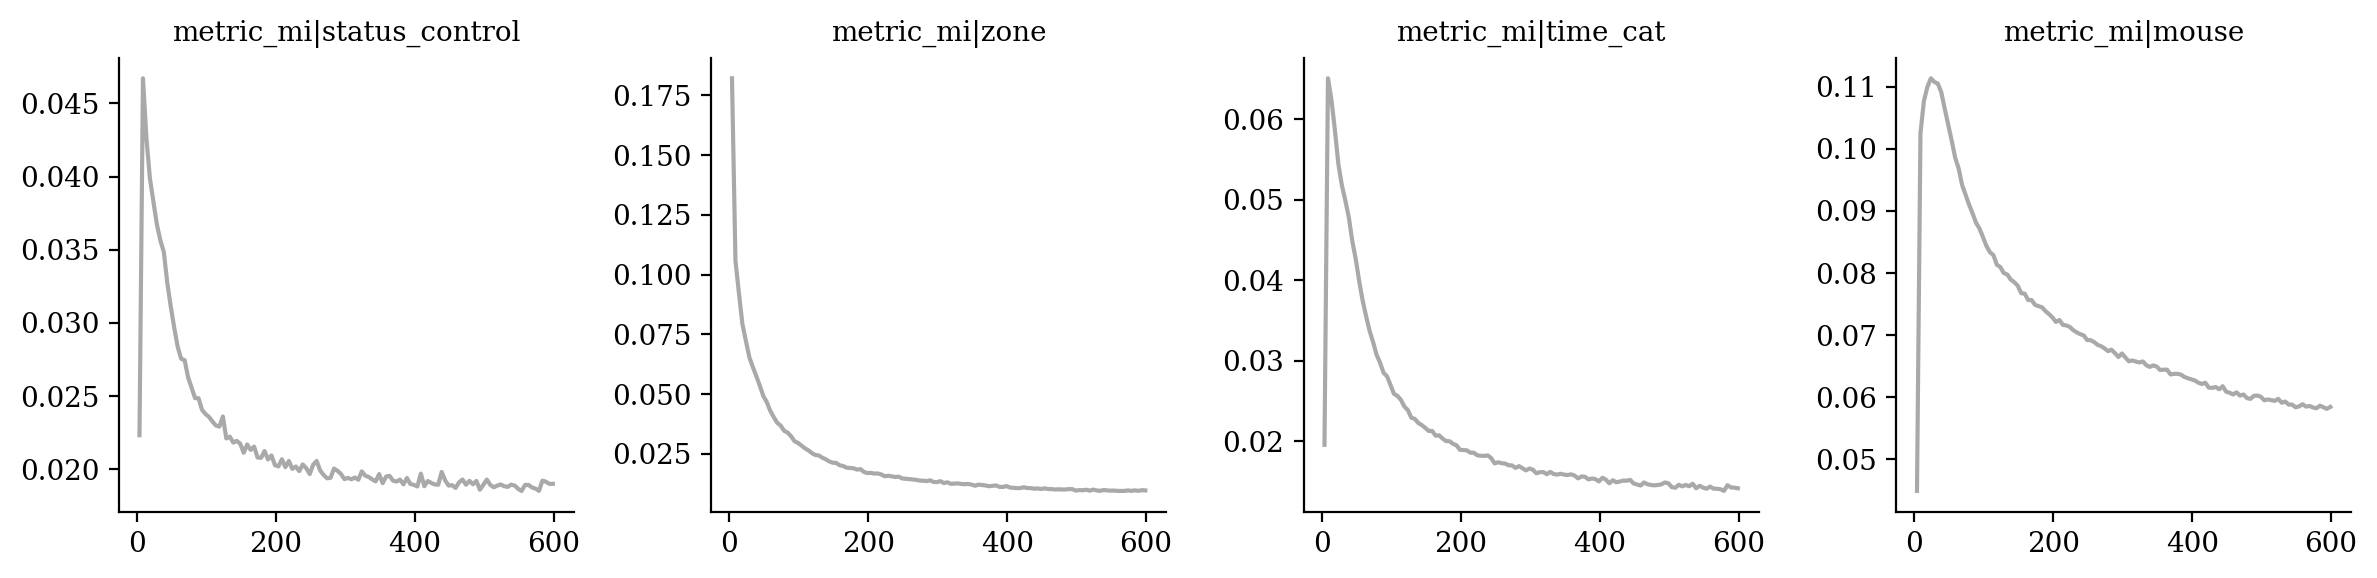

In [11]:
vae.plot_training_history(
    ignore_first=0,
    n_col=4,
    metrics_name=["metric_mi|status_control", "metric_mi|zone", "metric_mi|time_cat", "metric_mi|mouse"]
)

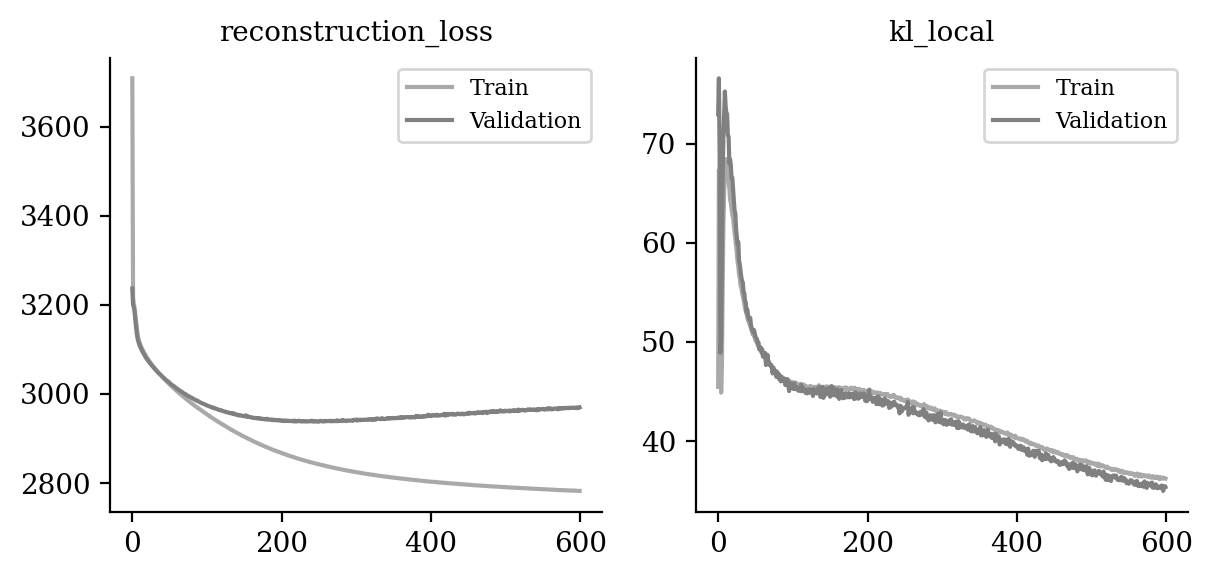

In [12]:
vae.plot_training_history(
    ignore_first=0,
    n_col=4,
    metrics_name=["reconstruction_loss", "kl_local"]
)

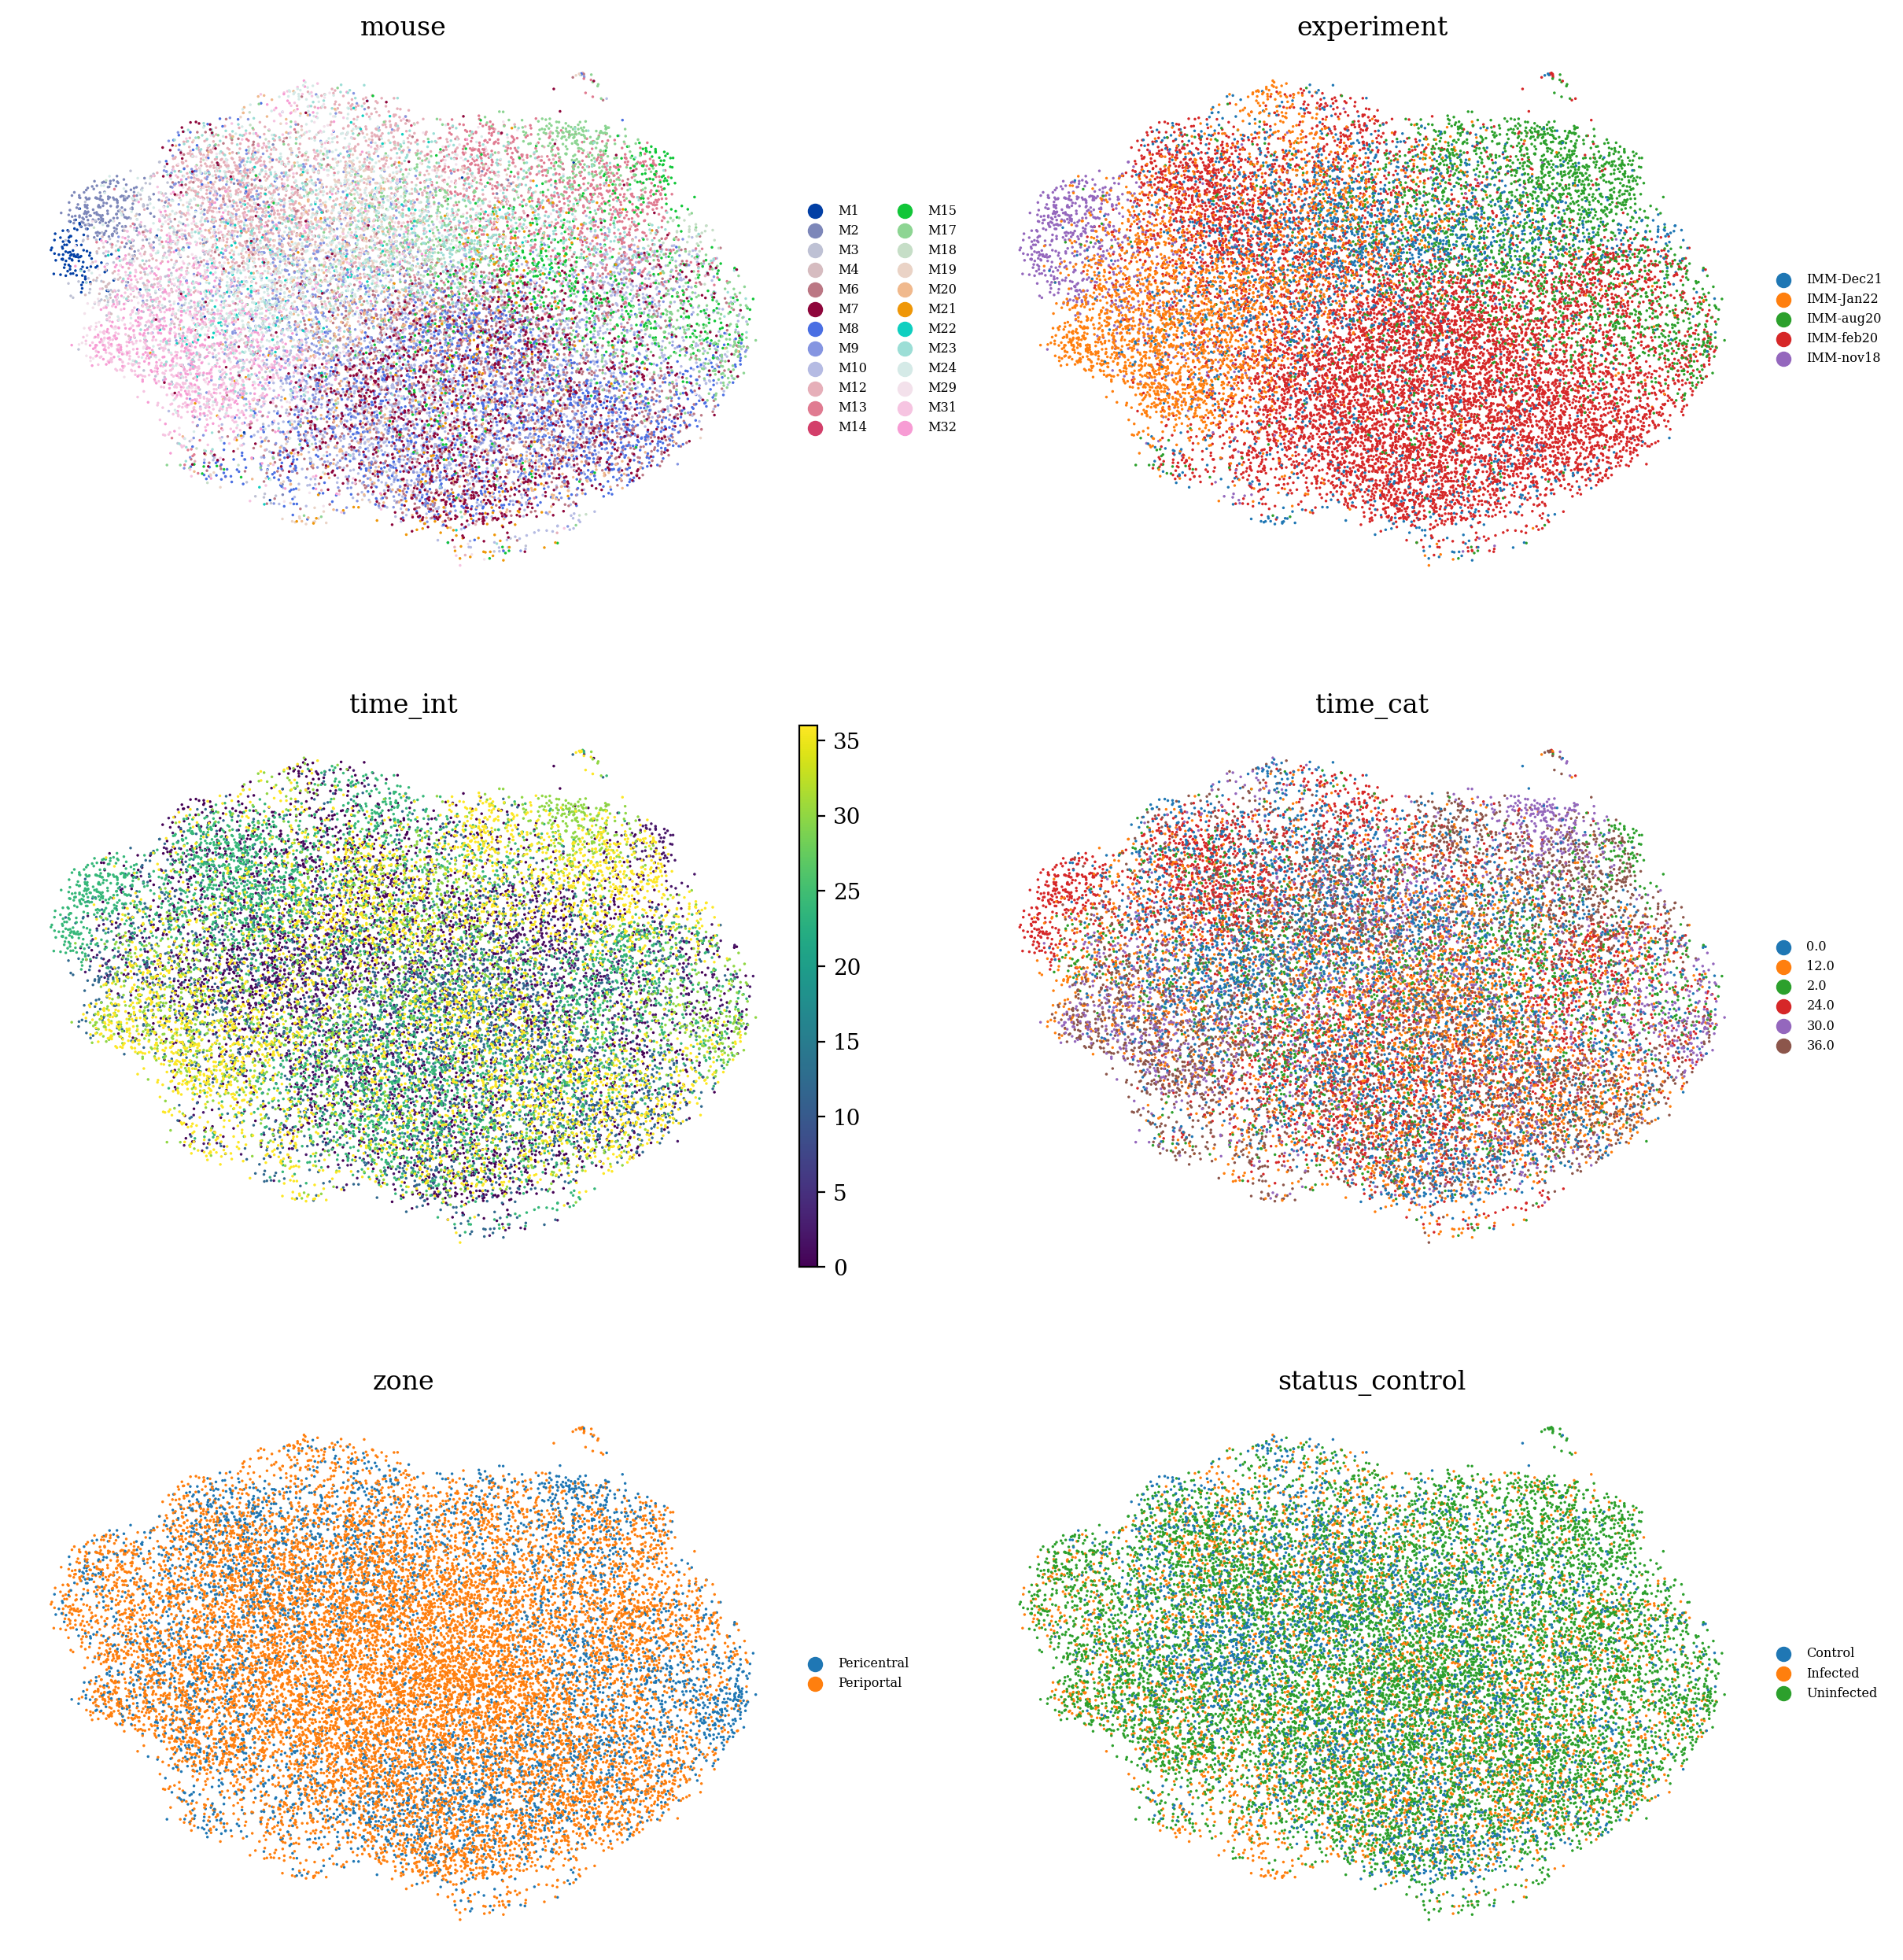

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latent, 
        color=['mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'], 
        ncols=2,
        frameon=False,
        legend_fontsize="xx-small"
    )